In [1]:
# General
import sys
import os
import os.path as op
import glob
from copy import deepcopy
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import warnings
# from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import xarray
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
from scipy import signal

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import astropy.stats.circstats as circstats
import pycircstat
import scikits.bootstrap as boot

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Neuro
import mne
# from fooof import FOOOF, FOOOFGroup
# from fooof.objs.utils import combine_fooofs
#import neurodsp

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
from formatting import *
from helper_funcs import *
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace
from time_cells import spike_preproc, events_proc, time_bin_analysis
from phase_locking import eeg_preproc, spectral_analysis, unit_lfp_comparison

# Colors
colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

proj_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta'

# Load data

In [2]:
# Load spikes.
fr_thresh = 0.2
nspike_thresh = 0
n_rois = 6
expmts = ['ycab', 'goldmine']

# ----------------------
spikes = []
for expmt in expmts:
    print(expmt)
    spikes.append(unit_lfp_comparison.load_all_unit_spikes(fr_thresh=fr_thresh,
                                                           nspike_thresh=nspike_thresh,
                                                           n_rois=n_rois,
                                                           expmt=expmt))
    spikes[-1].insert(0, 'expmt', expmt)
spikes = pd.concat(spikes, axis=0).reset_index(drop=True)

if 'subj_sess_unit' not in spikes:
    spikes.insert(1, 'subj_sess_unit', spikes.apply(lambda x: '{}-{}-{}'.format(x['subj_sess'], x['chan'], x['unit']), axis=1))
    
n_rois = 8
roi_map = spike_preproc.roi_mapping(n_rois)
spikes['roi_gen'] = spikes['hemroi'].apply(lambda x: roi_map[x[1:]])

print('spikes:', spikes.shape)

ycab
spikes: (1633, 10)
Ran in 46.9s
goldmine
10 subjects, 12 sessions
spikes: (448, 10)
Ran in 28.4s
spikes: (2081, 12)


In [3]:
expmts = ['ycab', 'goldmine']
data_dir = {'ycab': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab/phase_locking/10000perm',
            'goldmine': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/game_states/phase_locking'}
freqs = np.arange(1, 31)
n_rois = 8
min_spikes = 50
alpha = 0.05
verbose = False

# -----------------------
timer = Timer()

mask_idx = dio.open_pickle(glob(op.join(data_dir['goldmine'], '*.pkl'))[0]).columns.tolist().index('mask')

pl_files = []
pl_mrls = []
for expmt in expmts:
    pl_files.append(glob(op.join(data_dir[expmt], '*.pkl')))
    pl_mrls.append(pd.concat([dio.open_pickle(f) for f in pl_files[-1]])                     
                     .sort_values(['subj_sess', 'unit', 'lfp_roi_gen'])
                     .reset_index(drop=True))
    pl_mrls[-1].insert(0, 'expmt', expmt)
    if 'mask' not in pl_mrls[-1]:
        pl_mrls[-1].insert(mask_idx, 'mask', 'all')
        
pl_mrls = pd.concat(pl_mrls).reset_index(drop=True)
pl_mrls.insert(1,
               'subj_sess_unit',
               pl_mrls.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['unit']), axis=1))
pl_mrls.insert(pl_mrls.columns.tolist().index('edge')+1,
               'is_local',
               pl_mrls['unit_hemroi'] == pl_mrls['lfp_hemroi'])
pl_mrls.insert(pl_mrls.columns.tolist().index('n_spikes_mask')+1,
               'max_n_spikes_mask',
               pl_mrls['n_spikes_mask'].apply(lambda x: np.nanmax(x)))
pl_mrls.insert(pl_mrls.columns.tolist().index('n_spikes_mask_null')+1,
               'max_n_spikes_mask_null',
               pl_mrls['n_spikes_mask_null'].apply(lambda x: np.nanmean(np.nanmax(x, axis=1))))
pl_mrls.insert(pl_mrls.columns.tolist().index('mrls')+1,
               'max_mrl',
               pl_mrls['mrls'].apply(lambda x: np.nanmax(x)))
pl_mrls.insert(pl_mrls.columns.tolist().index('mrls')+2,
               'max_mrl_freq',
               pl_mrls['mrls'].apply(lambda x: freqs[np.nanargmax(x)]))
pl_mrls.insert(pl_mrls.columns.tolist().index('mrls_null')+1,
               'max_mrl_null',
               pl_mrls['mrls_null'].apply(lambda x: np.nanmean(np.nanmax(x, axis=1))))
pl_mrls.insert(pl_mrls.columns.tolist().index('mrls_null')+2,
               'max_mrl_freq_null',
               pl_mrls['mrls_null'].apply(lambda x: freqs[stats.mode(np.nanargmax(x, axis=1), nan_policy='omit').mode[0]]))
pl_mrls.insert(pl_mrls.columns.tolist().index('pref_phases')+1,
               'max_pref_phase',
               pl_mrls.apply(lambda x: x['pref_phases'][np.nanargmax(x['mrls'])], axis=1))
pl_mrls.insert(pl_mrls.columns.tolist().index('pref_phases')+2,
               'max_z_pref_phase',
               pl_mrls.apply(lambda x: x['pref_phases'][np.nanargmax(x['z_mrls'])], axis=1))
pl_mrls.insert(pl_mrls.columns.tolist().index('max_z_mrl_freq')+1,
               'max_z_mrl_null',
               pl_mrls['mrls_null'].apply(lambda x: np.nanmean(np.nanmax(stats.zscore(x, axis=0, nan_policy='omit'), axis=1))))
pl_mrls.insert(pl_mrls.columns.tolist().index('max_z_mrl_freq')+2,
               'max_z_mrl_freq_null',
               pl_mrls['mrls_null'].apply(lambda x: freqs[stats.mode(np.nanargmax(stats.zscore(x, axis=0, nan_policy='omit'), axis=1), nan_policy='omit').mode[0]]))
pl_mrls.drop(columns=['mrls_null'], inplace=True)

# Reformat regions.
roi_map = spike_preproc.roi_mapping(n_rois)
spikes['roi_gen'] = spikes['hemroi'].apply(lambda x: roi_map[x[1:]])
for cxn in ['unit', 'lfp']:
    pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: roi_map[x[1:]])

# Drop unwanted regions.
drop_idx = pl_mrls.loc[np.isin(pl_mrls['unit_roi_gen'], 'Other') | np.isin(pl_mrls['lfp_roi_gen'], 'Other')].index
pl_mrls = pl_mrls.drop(index=drop_idx).reset_index(drop=True)

drop_rois = ['MC', 'PC', 'TP']
hpc_rois = ['AH', 'MH', 'PH']
mtl_rois = ['A', 'EC']
gen_rois = ['HPC', 'EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
gen_rois2 = ['HPC', 'MTL', 'CTX']
for cxn in ['unit', 'lfp']:
    pl_mrls.insert(pl_mrls.columns.tolist().index('{}_hemroi'.format(cxn))+1,
                   '{}_roi'.format(cxn),
                   pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]))
    pl_mrls = pl_mrls.query("({}_roi!={})".format(cxn, drop_rois)).reset_index(drop=True)

    pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_roi_gen'.format(cxn)].astype(str)
    pl_mrls.loc[pl_mrls['{}_roi_gen'.format(cxn)]=='CC', '{}_roi_gen'.format(cxn)] = 'ACC'
    pl_mrls.loc[pl_mrls['{}_roi_gen'.format(cxn)]=='LTC', '{}_roi_gen'.format(cxn)] = 'STG'
    pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_roi_gen'.format(cxn)].astype(pd.CategoricalDtype(gen_rois, ordered=True))

    pl_mrls.insert(pl_mrls.columns.tolist().index('{}_roi_gen'.format(cxn))+1, '{}_roi_gen2'.format(cxn), '')
    pl_mrls.loc[np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), hpc_rois), '{}_roi_gen2'.format(cxn)] = 'HPC'
    pl_mrls.loc[np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), mtl_rois), '{}_roi_gen2'.format(cxn)] = 'MTL'
    pl_mrls.loc[~np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), hpc_rois + mtl_rois), '{}_roi_gen2'.format(cxn)] = 'CTX'
    pl_mrls['{}_roi_gen2'.format(cxn)] = pl_mrls['{}_roi_gen2'.format(cxn)].astype(pd.CategoricalDtype(gen_rois2, ordered=True))

pl_mrls.insert(pl_mrls.columns.tolist().index('lfp_hemroi')+1, 'lfp_hpc_div', '')
pl_mrls.loc[np.isin(pl_mrls['lfp_hemroi'], ['LAH', 'RAH']), 'lfp_hpc_div'] = 'ant'
pl_mrls.loc[np.isin(pl_mrls['lfp_hemroi'], ['LMH', 'LPH', 'RMH', 'RPH']), 'lfp_hpc_div'] = 'post'

# Drop repeat connections .
mult_edge_neurons = (pl_mrls
                     .query("(edge==['ctx-hpc', 'hpc-hpc'])")
                     .groupby(['mask', 'subj_sess_unit', 'lfp_roi_gen'])
                     .size()
                     .reset_index()
                     .rename(columns={0: 'n_edges'})
                     .query("(n_edges>1)")['subj_sess_unit']
                     .unique()
                     .tolist())
qry = "(edge==['ctx-hpc', 'hpc-hpc']) & (subj_sess_unit=={})".format(mult_edge_neurons)
drop_idx = np.concatenate([unit_lfp_comparison.axe_connections(df)
                           for (idx, df) in pl_mrls.query(qry).groupby('subj_sess_unit')])
pl_mrls = pl_mrls.drop(index=drop_idx).reset_index(drop=True)

# Drop contralateral connections.
pl_mrls = pl_mrls.query("(same_hem==True)").reset_index(drop=True)

# Drop neurons with too few spikes.
pl_mrls = pl_mrls.query("(max_n_spikes_mask>={})".format(min_spikes)).reset_index(drop=True)

# Drop nonlocal connections within the same general region.
drop_idx = pl_mrls.query("(same_roi_gen==True) & (is_local==False)").index.tolist()
pl_mrls.drop(index=drop_idx, inplace=True)

# # Keep only local connections and connections to hippocampal LFPs.
# pl_mrls = pl_mrls.query("(is_local==True) | (lfp_roi_gen=='HPC')").reset_index(drop=True)

# FDR correct p-values, separately within each unit-to-LFP region pair.
pl_mrls.drop(columns=[col for col in list(set(['pval_fdr', 'sig_fdr']) & set(pl_mrls.columns))], inplace=True)
pl_mrls.insert(pl_mrls.columns.tolist().index('sig')+1, 'pval_fdr', np.nan)
pl_mrls.insert(pl_mrls.columns.tolist().index('sig')+2, 'sig_fdr', np.nan)

grp_cols = ['mask', 'is_local', 'unit_roi_gen', 'lfp_roi_gen']
for (mask, is_local, unit_roi_gen, lfp_roi_gen), df in pl_mrls.groupby(grp_cols, observed=True):
    if mask == 'all_matched':
        idx = (pl_mrls
               .query("(is_local=={}) & (unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}')"
                      .format(is_local, unit_roi_gen, lfp_roi_gen))
               .query("((expmt=='goldmine') & (mask=='all_matched')) | ((expmt=='ycab') & (mask=='all'))")
               .index)
    else:
        idx = df.index
    if len(idx) == 0:
        pl_mrls.loc[idx, 'pval_fdr'] = 0
        pl_mrls.loc[idx, 'sig_fdr'] = False
    else:
        sig_fdr, pval_fdr, *_ = sm.stats.multipletests(pl_mrls.loc[idx, 'pval'],
                                                       alpha=alpha,
                                                       method='fdr_tsbky')
        pl_mrls.loc[idx, 'pval_fdr'] = pval_fdr
        pl_mrls.loc[idx, 'sig_fdr'] = sig_fdr
    
    if verbose:
        print('{:>11}, {:>3}, {:>3}: {:>3} neurons'.format(mask, unit_roi_gen, lfp_roi_gen, len(idx)))
    
print('{} saved files'.format(np.sum([len(x) for x in pl_files])))
print('pl_mrls: {}'.format(pl_mrls.shape))
print('{} subjects, {} sessions, {} neurons'
      .format(pl_mrls['subj'].unique().size,
              pl_mrls['subj_sess'].unique().size,
              pl_mrls['subj_sess_unit'].unique().size))
print(timer)

1942 saved files
pl_mrls: (4904, 49)
28 subjects, 55 sessions, 1668 neurons
Ran in 302.9s


# How many neurons?

In [4]:
def circmom(x):
    x = x.values[np.where(np.isfinite(x.values))[0]]
    return '{:.2f}, {:.2f}, p = {:.6f}'.format(*circstats.circmoment(x), circstats.rayleightest(x))

In [110]:
# Drop unwanted regions.
drop_idx = pl_mrls.loc[np.isin(pl_mrls['unit_roi_gen'], 'Other') | np.isin(pl_mrls['lfp_roi_gen'], 'Other')].index
pl_mrls = pl_mrls.drop(index=drop_idx).reset_index(drop=True)

drop_rois = ['MC', 'PC', 'TP']
hpc_rois = ['AH', 'MH', 'PH']
mtl_rois = ['A', 'EC']
gen_rois = ['HPC', 'EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
gen_rois2 = ['HPC', 'MTL', 'CTX']
for cxn in ['unit', 'lfp']:
    if '{}_roi'.format(cxn) in pl_mrls.columns:
        pl_mrls.drop(columns=['{}_roi'.format(cxn)], inplace=True)
    pl_mrls.insert(pl_mrls.columns.tolist().index('{}_hemroi'.format(cxn))+1,
                   '{}_roi'.format(cxn),
                   pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]))
    pl_mrls = pl_mrls.query("({}_roi!={})".format(cxn, drop_rois)).reset_index(drop=True)
    
    pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_roi_gen'.format(cxn)].astype(str)
    pl_mrls.loc[pl_mrls['{}_roi_gen'.format(cxn)]=='CC', '{}_roi_gen'.format(cxn)] = 'ACC'
    pl_mrls.loc[pl_mrls['{}_roi_gen'.format(cxn)]=='LTC', '{}_roi_gen'.format(cxn)] = 'STG'
    pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_roi_gen'.format(cxn)].astype(pd.CategoricalDtype(gen_rois, ordered=True))
    
    if '{}_roi_gen2'.format(cxn) in pl_mrls.columns:
        pl_mrls.drop(columns=['{}_roi_gen2'.format(cxn)], inplace=True)
    pl_mrls.insert(pl_mrls.columns.tolist().index('{}_roi_gen'.format(cxn))+1, '{}_roi_gen2'.format(cxn), '')
    pl_mrls.loc[np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), hpc_rois), '{}_roi_gen2'.format(cxn)] = 'HPC'
    pl_mrls.loc[np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), mtl_rois), '{}_roi_gen2'.format(cxn)] = 'MTL'
    pl_mrls.loc[~np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), hpc_rois + mtl_rois), '{}_roi_gen2'.format(cxn)] = 'CTX'
    pl_mrls['{}_roi_gen2'.format(cxn)] = pl_mrls['{}_roi_gen2'.format(cxn)].astype(pd.CategoricalDtype(gen_rois2, ordered=True))

In [127]:
for expmt in pl_mrls['expmt'].unique():
    print('{:>8}: {} subjects, {} sessions, {} neurons'
          .format(expmt,
                  pl_mrls.query("(expmt=='{}')".format(expmt))['subj'].unique().size,
                  pl_mrls.query("(expmt=='{}')".format(expmt))['subj_sess'].unique().size,
                  pl_mrls.query("(expmt=='{}')".format(expmt))['subj_sess_unit'].unique().size))
print('combined: {} subjects, {} sessions, {} neurons'
      .format(pl_mrls['subj'].unique().size,
              pl_mrls['subj_sess'].unique().size,
              pl_mrls['subj_sess_unit'].unique().size))

    ycab: 17 subjects, 39 sessions, 1170 neurons
goldmine: 10 subjects, 12 sessions, 395 neurons
combined: 27 subjects, 51 sessions, 1565 neurons


In [159]:
# How many neuron-LFP connections do we have between each pair of regions?
(pl_mrls
 .query("(mask=='all')")
 .drop_duplicates(['subj_sess_unit', 'lfp_roi_gen', 'is_local'])
 .groupby(['unit_roi_gen', 'lfp_roi_gen'], observed=True)
 ['subj_sess_unit'].apply(lambda x: len(np.unique(x)))
 .unstack('lfp_roi_gen')
 .fillna(0)
 .astype(int))

lfp_roi_gen   HPC   EC  AMY  OFC  PHG  ACC  STG
unit_roi_gen                                   
HPC           309    0    0    0    0    0    0
EC            249  296    0    0    0    0    0
AMY           305    0  336    0    0    0    0
OFC           157    0    0  168    0    0    0
PHG           145    0    0    0  162    0    0
ACC           108    0    0    0    0  126    0
STG           127    0    0    0    0    0  126

In [160]:
# How many subjects have neuron-LFP connections between each pair of regions?
(pl_mrls
 .query("(mask=='all')")
 .drop_duplicates(['subj_sess_unit', 'lfp_roi_gen', 'is_local'])
 .groupby(['unit_roi_gen', 'lfp_roi_gen'], observed=True)
 ['subj'].apply(lambda x: len(np.unique(x)))
 .unstack('lfp_roi_gen')
 .fillna(0)
 .astype(int))

lfp_roi_gen   HPC  EC  AMY  OFC  PHG  ACC  STG
unit_roi_gen                                  
HPC            25   0    0    0    0    0    0
EC             15  17    0    0    0    0    0
AMY            20   0   21    0    0    0    0
OFC            13   0    0   14    0    0    0
PHG            13   0    0    0   13    0    0
ACC             7   0    0    0    0    8    0
STG             5   0    0    0    0    0    5

In [172]:
# How many neuron-LFP connections do we have between each pair of regions?
(pl_mrls.query("(expmt=='goldmine') & (mask=='all')")
 .drop_duplicates(['subj_sess_unit', 'lfp_roi_gen', 'is_local'])
 .groupby(['unit_roi_gen', 'lfp_roi_gen'], observed=True)
 ['subj_sess_unit'].apply(lambda x: len(np.unique(x)))
 .unstack('lfp_roi_gen')
 .fillna(0)
 .astype(int))

lfp_roi_gen   HPC  EC  AMY  OFC  PHG  ACC  STG
unit_roi_gen                                  
HPC            72   0    0    0    0    0    0
EC             70  96    0    0    0    0    0
AMY            70   0   86    0    0    0    0
OFC            28   0    0   28    0    0    0
PHG            41   0    0    0   63    0    0
ACC            21   0    0    0    0   21    0
STG            21   0    0    0    0    0   21

In [167]:
# How many neuron-LFP connections do we have between each pair of regions?
(pl_mrls.query("(expmt=='goldmine') & (mask=='Encoding')")
 .drop_duplicates(['subj_sess_unit', 'lfp_roi_gen', 'is_local'])
 .groupby(['unit_roi_gen', 'lfp_roi_gen'], observed=True)
 ['subj_sess_unit'].apply(lambda x: len(np.unique(x)))
 .unstack('lfp_roi_gen')
 .fillna(0)
 .astype(int))

lfp_roi_gen   HPC  EC  AMY  OFC  PHG  ACC  STG
unit_roi_gen                                  
HPC            49   0    0    0    0    0    0
EC             48  49    0    0    0    0    0
AMY            37   0   41    0    0    0    0
OFC            19   0    0   13    0    0    0
PHG            23   0    0    0   46    0    0
ACC            14   0    0    0    0   14    0
STG            19   0    0    0    0    0   14

In [170]:
# How many subjects have neuron-LFP connections between each pair of regions?
(pl_mrls
 .query("(expmt=='goldmine') & (mask=='all')")
 .drop_duplicates(['subj_sess_unit', 'lfp_roi_gen', 'is_local'])
 .groupby(['unit_roi_gen', 'lfp_roi_gen'], observed=True)
 ['subj'].apply(lambda x: len(np.unique(x)))
 .unstack('lfp_roi_gen')
 .fillna(0)
 .astype(int))

lfp_roi_gen   HPC  EC  AMY  OFC  PHG  ACC  STG
unit_roi_gen                                  
HPC             9   0    0    0    0    0    0
EC              5   7    0    0    0    0    0
AMY             8   0    9    0    0    0    0
OFC             6   0    0    6    0    0    0
PHG             5   0    0    0    5    0    0
ACC             2   0    0    0    0    3    0
STG             1   0    0    0    0    0    1

In [169]:
# How many subjects have neuron-LFP connections between each pair of regions?
(pl_mrls
 .query("(expmt=='goldmine') & (mask=='Encoding')")
 .drop_duplicates(['subj_sess_unit', 'lfp_roi_gen', 'is_local'])
 .groupby(['unit_roi_gen', 'lfp_roi_gen'], observed=True)
 ['subj'].apply(lambda x: len(np.unique(x)))
 .unstack('lfp_roi_gen')
 .fillna(0)
 .astype(int))

lfp_roi_gen   HPC  EC  AMY  OFC  PHG  ACC  STG
unit_roi_gen                                  
HPC             7   0    0    0    0    0    0
EC              3   5    0    0    0    0    0
AMY             6   0    6    0    0    0    0
OFC             6   0    0    6    0    0    0
PHG             5   0    0    0    5    0    0
ACC             2   0    0    0    0    3    0
STG             1   0    0    0    0    0    1

In [16]:
# How many subjects have neuron-LFP connections between each pair of regions?
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
(pl_mrls
 .query("(expmt=='goldmine') & (mask=={})".format(keep_masks))
 .drop_duplicates(['subj_sess_unit', 'lfp_roi_gen', 'is_local'])
 .groupby(['subj', 'unit_roi_gen', 'lfp_roi_gen'], observed=True)
 ['subj_sess_unit'].apply(lambda x: len(np.unique(x)))
 .unstack('subj')
 .fillna(0)
 .astype(int))

subj                      U518  U521  U526  U527  U530  U532  U536  U537  \
unit_roi_gen lfp_roi_gen                                                   
HPC          HPC            12     2     7     7    11     0     9     0   
EC           HPC             0     0     0     2    36     0    10     0   
             EC              4     0     0     1    27     6    11     0   
AMY          HPC             5     0     0     5     7     7     6     7   
             AMY             0     0     1     6    10    13     5     6   
OFC          HPC             0     0     0     6     3     1     5     1   
             OFC             0     0     0     2     3     1     3     1   
PHG          HPC             4    12     0     0     0     1     3     0   
             PHG            16    17     0     0     0     9     3     0   
ACC          HPC             0     0     0     0     4     0    10     0   
             ACC             0     0     1     0     4     0     9     0   
STG          HPC             0     0     0     0    19     0     0     0   
             STG             0     0     0     0    14     0     0     0   

subj                      U539  U540  
unit_roi_gen lfp_roi_gen              
HPC          HPC             1     0  
EC           HPC             0     0  
             EC              0     0  
AMY          HPC             0     0  
             AMY             0     0  
OFC          HPC             0     3  
             OFC             0     3  
PHG          HPC             0     3  
             PHG             0     1  
ACC          HPC             0     0  
             ACC             0     0  
STG          HPC             0     0  
             STG             0     0

In [8]:
(pl_mrls
 .groupby(['expmt', 'mask'], observed=True)
 .agg({'subj_sess_unit': lambda x: np.unique(x).size}))

subj_sess_unit
expmt    mask                       
goldmine Delay1                  258
         Delay2                  258
         Encoding                258
         Retrieval               258
         all                     395
         all_matched             359
ycab     all                    1273

In [136]:
# How many subjects have neuron-LFP connections between each pair of regions?
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
(pl_mrls
 .query("(expmt=='goldmine') & (mask=={})".format(keep_masks))
 .groupby(['is_local', 'unit_roi_gen', 'lfp_roi_gen', 'mask', 'subj'], observed=True)
#  ['sig_fdr'].apply(count_pct)
 ['max_z_mrl'].apply(lambda x: '{:>4.1f} {:>4}'.format(np.mean(x), '({})'.format(len(x))))
 .unstack(['mask']))

mask                                       Delay1     Delay2   Encoding  \
is_local unit_roi_gen lfp_roi_gen subj                                    
False    EC           HPC         U527   2.5  (2)   2.5  (2)   3.3  (2)   
                                  U530   2.7 (36)   2.8 (36)   4.3 (36)   
                                  U536   1.6 (10)   1.7 (10)   2.5 (10)   
         AMY          HPC         U518   1.6  (5)   1.9  (5)   2.9  (5)   
                                  U527   4.9  (5)   7.2  (5)  11.1  (5)   
                                  U530   2.5  (7)   2.3  (7)   2.7  (7)   
                                  U532   2.2  (7)   2.5  (7)   3.1  (7)   
                                  U536   3.2  (6)   2.3  (6)   2.7  (6)   
                                  U537   4.0  (7)   4.6  (7)   6.3  (7)   
         PHG          HPC         U518   2.4  (4)   2.9  (4)   2.2  (4)   
                                  U521   1.7 (12)   2.0 (12)   1.9 (12)   
                                  U532   2.7  (1)   1.8  (1)   2.0  (1)   
                                  U536   1.4  (3)   2.1  (3)   2.8  (3)   
                                  U540   2.1  (3)   1.8  (3)   2.2  (3)   
         STG          HPC         U530   2.4 (19)   2.6 (19)   2.3 (19)   
         OFC          HPC         U527   1.8  (6)   2.2  (6)   2.0  (6)   
                                  U530   2.9  (3)   2.7  (3)   2.8  (3)   
                                  U532   3.0  (1)   5.0  (1)   1.9  (1)   
                                  U536   1.8  (5)   1.0  (5)   2.4  (5)   
                                  U537   1.5  (1)   1.8  (1)   1.7  (1)   
                                  U540   2.9  (3)   1.9  (3)   2.7  (3)   
         ACC          HPC         U530   2.0  (4)   1.7  (4)   2.0  (4)   
                                  U536   1.9 (10)   1.7 (10)   2.2 (10)   
True     HPC          HPC         U518   5.6 (12)   5.9 (12)  10.0 (12)   
                                  U521   6.1  (2)   6.0  (2)   7.5  (2)   
                                  U526   2.1  (7)   2.2  (7)   2.4  (7)   
                                  U527   4.3  (7)   5.8  (7)   7.9  (7)   
                                  U530   3.2 (11)   3.1 (11)   3.8 (11)   
                                  U536   4.2  (9)   4.1  (9)   4.1  (9)   
                                  U539  12.3  (1)  11.4  (1)  19.1  (1)   
         EC           EC          U518   2.8  (4)   3.5  (4)   4.6  (4)   
                                  U527   3.8  (1)   3.7  (1)   5.1  (1)   
                                  U530   3.7 (27)   3.9 (27)   4.7 (27)   
                                  U532   2.5  (6)   3.0  (6)   5.1  (6)   
                                  U536   1.7 (11)   1.6 (11)   2.3 (11)   
         AMY          AMY         U526   1.7  (1)   1.6  (1)   1.9  (1)   
                                  U527   4.6  (6)   5.4  (6)   6.6  (6)   
                                  U530   1.8 (10)   2.0 (10)   2.5 (10)   
                                  U532   2.7 (13)   3.1 (13)   3.7 (13)   
                                  U536   2.1  (5)   2.3  (5)   2.3  (5)   
                                  U537   5.7  (6)   6.8  (6)   8.0  (6)   
         PHG          PHG         U518   3.8 (16)   3.7 (16)   3.5 (16)   
                                  U521  10.3 (17)  10.5 (17)  12.1 (17)   
                                  U532   2.5  (9)   3.2  (9)   3.0  (9)   
                                  U536   1.8  (3)   2.6  (3)   1.7  (3)   
                                  U540   2.0  (1)   2.6  (1)   2.0  (1)   
         STG          STG         U530   4.3 (14)   4.8 (14)   3.7 (14)   
         OFC          OFC         U527   2.5  (2)   3.0  (2)   2.3  (2)   
                                  U530   2.2  (3)   1.7  (3)   2.0  (3)   
                                  U532   2.7  (1)   2.3  (1)   2.1  (1)   
                                  U536   1.7  (3)   1.5  (3)   1.4  (3)   
                         

In [9]:
(pl_mrls
 .query("((expmt=='ycab') & (mask=='all')) | ((expmt=='goldmine') & (mask=='all_matched'))")
 .query("(edge==['ctx-hpc', 'hpc-local', 'ctx-local'])")
 .groupby(['is_local', 'expmt', 'unit_roi_gen', 'lfp_roi_gen'], observed=True)
 .agg({'sig': count_pct,
       'sig_fdr': count_pct})
 .unstack('expmt'))

sig                   \
expmt                                   goldmine             ycab   
is_local unit_roi_gen lfp_roi_gen                                   
False    EC           HPC          35/66 (53.0%)   81/195 (41.5%)   
         AMY          HPC          22/61 (36.1%)   98/269 (36.4%)   
         OFC          HPC           6/27 (22.2%)   13/130 (10.0%)   
         PHG          HPC            2/36 (5.6%)   16/126 (12.7%)   
         ACC          HPC            0/20 (0.0%)      7/87 (8.0%)   
         STG          HPC            1/21 (4.8%)   13/106 (12.3%)   
True     HPC          HPC          42/67 (62.7%)  147/265 (55.5%)   
         EC           EC           49/80 (61.3%)   74/214 (34.6%)   
         AMY          AMY          41/73 (56.2%)  131/286 (45.8%)   
         OFC          OFC           4/25 (16.0%)   33/140 (23.6%)   
         PHG          PHG          41/60 (68.3%)   16/119 (13.4%)   
         ACC          ACC           4/20 (20.0%)   16/105 (15.2%)   
         STG          STG          14/19 (73.7%)   49/105 (46.7%)   

                                         sig_fdr                   
expmt                                   goldmine             ycab  
is_local unit_roi_gen lfp_roi_gen                                  
False    EC           HPC          29/66 (43.9%)   76/195 (39.0%)  
         AMY          HPC          18/61 (29.5%)   73/269 (27.1%)  
         OFC          HPC            0/27 (0.0%)     5/130 (3.8%)  
         PHG          HPC            0/36 (0.0%)     2/126 (1.6%)  
         ACC          HPC            0/20 (0.0%)      1/87 (1.1%)  
         STG          HPC            0/21 (0.0%)     4/106 (3.8%)  
True     HPC          HPC          42/67 (62.7%)  151/265 (57.0%)  
         EC           EC           43/80 (53.8%)   66/214 (30.8%)  
         AMY          AMY          39/73 (53.4%)  127/286 (44.4%)  
         OFC          OFC           3/25 (12.0%)   21/140 (15.0%)  
         PHG          PHG          38/60 (63.3%)    10/119 (8.4%)  
         ACC          ACC           4/20 (20.0%)     3/105 (2.9%)  
         STG          STG          13/19 (68.4%)   47/105 (44.8%)

In [12]:
(pl_mrls
 .query("(expmt=='goldmine') & (mask==['Delay1', 'Encoding', 'Delay2', 'Retrieval'])")
 .groupby(['is_local', 'unit_roi_gen', 'lfp_roi_gen', 'mask'], observed=True)
 .agg({'max_z_mrl': mean_sem,
#        'sig': count_pct,
#        'sig_fdr': count_pct
      })
 .unstack(['mask']))

max_z_mrl                            \
mask                                    Delay1       Delay2     Encoding   
is_local unit_roi_gen lfp_roi_gen                                          
False    EC           HPC          2.46 ± 0.21  2.58 ± 0.21  3.86 ± 0.42   
         AMY          HPC          3.04 ± 0.32  3.39 ± 0.47  4.63 ± 0.75   
         OFC          HPC          2.19 ± 0.24  2.05 ± 0.28  2.35 ± 0.23   
         PHG          HPC          1.88 ± 0.15  2.12 ± 0.18  2.09 ± 0.13   
         ACC          HPC          1.96 ± 0.22  1.74 ± 0.16  2.15 ± 0.17   
         STG          HPC          2.39 ± 0.19  2.57 ± 0.17  2.26 ± 0.17   
True     HPC          HPC          4.27 ± 0.43  4.50 ± 0.43  6.23 ± 0.77   
         EC           EC           3.04 ± 0.35  3.21 ± 0.36  4.18 ± 0.65   
         AMY          AMY          3.08 ± 0.34  3.58 ± 0.41  4.26 ± 0.51   
         OFC          OFC          2.36 ± 0.24  2.12 ± 0.31  2.06 ± 0.21   
         PHG          PHG          5.76 ± 0.76  6.00 ± 0.80  6.43 ± 0.92   
         ACC          ACC          3.56 ± 0.79  4.47 ± 1.07  6.43 ± 2.24   
         STG          STG          4.28 ± 0.53  4.80 ± 0.61  3.72 ± 0.30   

                                                
mask                                 Retrieval  
is_local unit_roi_gen lfp_roi_gen               
False    EC           HPC          3.73 ± 0.49  
         AMY          HPC          3.94 ± 0.79  
         OFC          HPC          1.93 ± 0.27  
         PHG          HPC          2.44 ± 0.19  
         ACC          HPC          1.88 ± 0.21  
         STG          HPC          2.21 ± 0.15  
True     HPC          HPC          5.97 ± 0.73  
         EC           EC           3.91 ± 0.65  
         AMY          AMY          3.59 ± 0.41  
         OFC          OFC          2.09 ± 0.29  
         PHG          PHG          6.51 ± 0.96  
         ACC          ACC          7.32 ± 2.54  
         STG          STG          3.80 ± 0.29

In [8]:
# Properties of phase-locked neurons.
keep_edges = ['ctx-hpc', 'ctx-local', 'hpc-local']
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
sig_col = 'sig_fdr'

def _nsig(nsig, n):
    return '{}/{} ({:.0%})'.format(nsig, n, nsig/n)

print('All phase-locked')
grp_cols = ['unit_roi_gen', 'lfp_roi_gen', 'mask']
tab = (pl_mrls.query("(edge=={}) & (mask=={})".format(keep_edges, keep_masks))
              .query("((is_local==True) & (same_roi_gen==True)) | (is_local==False)")
#               .query("({}==True)".format(sig_col))
              .groupby(grp_cols, observed=True)
              .agg({'unit': len,
                    'sig': count_pct,
                    sig_col: count_pct,
                    'fr': mean_sem,
                    'max_n_spikes_mask_null': mean_sem,
                    'max_n_spikes_mask': mean_sem,
                    'max_pep': mean_sem,
                    'max_pep_freq': gmean_sem,
                    'max_z_mrl': mean_sem,
                    'max_z_mrl_freq': gmean_sem,
                    'max_z_pref_phase': circmom}))
tab.drop(columns=['unit'], inplace=True)

tab

All phase-locked


sig        sig_fdr  \
unit_roi_gen lfp_roi_gen mask                                      
HPC          HPC         Delay1     21/49 (42.9%)  19/49 (38.8%)   
                         Delay2     24/49 (49.0%)  23/49 (46.9%)   
                         Encoding   28/49 (57.1%)  28/49 (57.1%)   
                         Retrieval  26/49 (53.1%)  26/49 (53.1%)   
EC           HPC         Delay1      7/48 (14.6%)    3/48 (6.2%)   
                         Delay2      8/48 (16.7%)    3/48 (6.2%)   
                         Encoding   17/48 (35.4%)  15/48 (31.2%)   
                         Retrieval  16/48 (33.3%)  13/48 (27.1%)   
             EC          Delay1     14/49 (28.6%)   7/49 (14.3%)   
                         Delay2     18/49 (36.7%)   8/49 (16.3%)   
                         Encoding   20/49 (40.8%)  20/49 (40.8%)   
                         Retrieval  15/49 (30.6%)  12/49 (24.5%)   
AMY          HPC         Delay1      8/37 (21.6%)   7/37 (18.9%)   
                         Delay2     12/37 (32.4%)  11/37 (29.7%)   
                         Encoding   17/37 (45.9%)  16/37 (43.2%)   
                         Retrieval  10/37 (27.0%)   7/37 (18.9%)   
             AMY         Delay1     12/41 (29.3%)  10/41 (24.4%)   
                         Delay2     14/41 (34.1%)  12/41 (29.3%)   
                         Encoding   20/41 (48.8%)  19/41 (46.3%)   
                         Retrieval  18/41 (43.9%)  18/41 (43.9%)   
OFC          HPC         Delay1      2/19 (10.5%)    0/19 (0.0%)   
                         Delay2      2/19 (10.5%)    0/19 (0.0%)   
                         Encoding    3/19 (15.8%)    0/19 (0.0%)   
                         Retrieval    1/19 (5.3%)    0/19 (0.0%)   
             OFC         Delay1       0/13 (0.0%)    0/13 (0.0%)   
                         Delay2       1/13 (7.7%)    0/13 (0.0%)   
                         Encoding     0/13 (0.0%)    0/13 (0.0%)   
                         Retrieval   2/13 (15.4%)    0/13 (0.0%)   
PHG          HPC         Delay1       0/23 (0.0%)    0/23 (0.0%)   
                         Delay2       2/23 (8.7%)    0/23 (0.0%)   
                         Encoding     0/23 (0.0%)    0/23 (0.0%)   
                         Retrieval   3/23 (13.0%)    0/23 (0.0%)   
             PHG         Delay1     24/46 (52.2%)  24/46 (52.2%)   
                         Delay2     27/46 (58.7%)  30/46 (65.2%)   
                         Encoding   25/46 (54.3%)  26/46 (56.5%)   
                         Retrieval  27/46 (58.7%)  27/46 (58.7%)   
ACC          HPC         Delay1       1/14 (7.1%)    0/14 (0.0%)   
                         Delay2       0/14 (0.0%)    0/14 (0.0%)   
                         Encoding     1/14 (7.1%)    0/14 (0.0%)   
                         Retrieval    0/14 (0.0%)    0/14 (0.0%)   
             ACC         Delay1      4/14 (28.6%)   4/14 (28.6%)   
                         Delay2      6/14 (42.9%)   5/14 (35.7%)   
                         Encoding    4/14 (28.6%)   4/14 (28.6%)   
                         Retrieval   4/14 (28.6%)   4/14 (28.6%)   
STG          HPC         Delay1      2/19 (10.5%)    0/19 (0.0%)   
                         Delay2      2/19 (10.5%)    0/19 (0.0%)   
                         Encoding    2/19 (10.5%)    0/19 (0.0%)   
                         Retrieval   2/19 (10.5%)    0/19 (0.0%)   
             STG         Delay1      7/14 (50.0%)   8/14 (57.1%)   
                         Delay2      9/14 (64.3%)   9/14 (64.3%)   
                         Encoding    8/14 (57.1%)   8/14 (57.1%)   
                         Retrieval   9/14 (64.3%)   9/14 (64.3%)   

                                              fr max_n_spikes_mask_null  \
unit_roi_gen lfp_roi_gen mask                                             
HPC          HPC         Delay1      5.86 ± 0.80         411.51 ± 79.53   
                         Delay2      5.86 ± 0.80         411.51 ± 79.53   
                         Encoding    5.86 ± 0.80         411.51 ± 79.53  

In [189]:
# Properties of phase-locked neurons.
keep_edges = ['ctx-hpc', 'ctx-local', 'hpc-local']
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
sig_col = 'sig_fdr'

def _nsig(nsig, n):
    return '{}/{} ({:.0%})'.format(nsig, n, nsig/n)

print('All phase-locked')
grp_cols = ['unit_roi_gen', 'lfp_roi_gen', 'mask']
tab = (pl_mrls.query("(edge=={}) & (mask=={})".format(keep_edges, keep_masks))
              .query("((is_local==True) & (same_roi_gen==True)) | (is_local==False)")
              .query("({}==True)".format(sig_col))
              .groupby(grp_cols, observed=True)
              .agg({'unit': len,
                    'fr': mean_sem,
                    'max_n_spikes_mask_null': mean_sem,
                    'max_n_spikes_mask': mean_sem,
                    'max_pep': mean_sem,
                    'max_pep_freq': gmean_sem,
                    'max_z_mrl': mean_sem,
                    'max_z_mrl_freq': gmean_sem,
                    'max_z_pref_phase': circmom}))
qry = "(same_hem==True) & (edge=={})".format(keep_edges)
n_cells = pl_mrls.query(qry).groupby(grp_cols, observed=True).size()
tab.insert(1,
           sig_col,
           tab.reset_index().apply(lambda x: _nsig(x['unit'], n_cells[(x['unit_roi_gen'],
                                                                       x['lfp_roi_gen'],
                                                                       x['mask'])]),
                                   axis=1).tolist())
tab.drop(columns=['unit'], inplace=True)

tab

All phase-locked


sig_fdr            fr  \
unit_roi_gen lfp_roi_gen mask                                   
HPC          HPC         Delay1     19/49 (39%)   6.33 ± 1.34   
                         Delay2     23/49 (47%)   5.91 ± 1.08   
                         Encoding   28/49 (57%)   6.15 ± 1.16   
                         Retrieval  26/49 (53%)   6.14 ± 1.20   
EC           HPC         Delay1       3/48 (6%)   6.96 ± 2.50   
                         Delay2       3/48 (6%)  16.45 ± 8.43   
                         Encoding   15/48 (31%)   5.58 ± 2.09   
                         Retrieval  13/48 (27%)   7.95 ± 2.80   
             EC          Delay1      7/49 (14%)   9.46 ± 4.09   
                         Delay2      8/49 (16%)   9.18 ± 3.52   
                         Encoding   20/49 (41%)   6.21 ± 1.49   
                         Retrieval  12/49 (24%)   7.67 ± 2.41   
AMY          HPC         Delay1      7/37 (19%)   7.10 ± 1.98   
                         Delay2     11/37 (30%)   6.63 ± 1.39   
                         Encoding   16/37 (43%)   6.16 ± 1.03   
                         Retrieval   7/37 (19%)   5.49 ± 1.29   
             AMY         Delay1     10/41 (24%)   5.58 ± 1.21   
                         Delay2     12/41 (29%)   6.29 ± 1.34   
                         Encoding   19/41 (46%)   5.31 ± 0.95   
                         Retrieval  18/41 (44%)   5.55 ± 1.02   
PHG          PHG         Delay1     24/46 (52%)   5.31 ± 0.98   
                         Delay2     30/46 (65%)   5.22 ± 0.80   
                         Encoding   26/46 (57%)   4.31 ± 0.65   
                         Retrieval  27/46 (59%)   5.45 ± 0.89   
ACC          ACC         Delay1      4/14 (29%)   2.31 ± 0.54   
                         Delay2      5/14 (36%)   2.91 ± 0.73   
                         Encoding    4/14 (29%)   2.31 ± 0.54   
                         Retrieval   4/14 (29%)   2.31 ± 0.54   
STG          STG         Delay1      8/14 (57%)  13.84 ± 2.67   
                         Delay2      9/14 (64%)  13.75 ± 2.36   
                         Encoding    8/14 (57%)  14.77 ± 2.41   
                         Retrieval   9/14 (64%)  13.75 ± 2.36   

                                   max_n_spikes_mask_null max_n_spikes_mask  \
unit_roi_gen lfp_roi_gen mask                                                 
HPC          HPC         Delay1           348.02 ± 101.78    348.44 ± 96.81   
                         Delay2           369.41 ± 104.32    364.86 ± 99.38   
                         Encoding          353.80 ± 87.11    346.42 ± 83.02   
                         Retrieval         370.15 ± 93.00    362.00 ± 88.39   
EC           HPC         Delay1           918.16 ± 606.60   911.08 ± 624.27   
                         Delay2          1652.70 ± 685.50  1646.17 ± 697.60   
                         Encoding         569.15 ± 198.94   571.43 ± 199.94   
                         Retrieval        852.05 ± 244.76   842.26 ± 243.09   
             EC          Delay1           493.94 ± 234.54   477.43 ± 234.17   
                         Delay2           466.97 ± 204.28   446.02 ± 204.93   
                         Encoding          241.77 ± 89.15    236.24 ± 88.12   
                         Retrieval        341.36 ± 143.46   327.93 ± 142.70   
AMY          HPC         Delay1            266.98 ± 64.22    312.26 ± 83.95   
                         Delay2            235.95 ± 48.07    263.12 ± 59.50   
                         Encoding          221.81 ± 35.83    238.55 ± 43.06   
                         Retrieval         231.31 ± 60.76    283.78 ± 85.13   
             AMY         Delay1            193.18 ± 42.13    229.56 ± 58.86   
                         Delay2            201.25 ± 40.23    225.37 ± 52.71   
                         Encoding          186.49 ± 29.58    200.45 ± 36.86   
                         Retrieval         201.64 ± 31.67    218.90 ± 38.84   
PHG          PHG         Delay1            369.86 ± 57.45    364.98 ± 54.49   
            

In [113]:
(pl_mrls
 .query("(sig_fdr==True)")
 .groupby(['expmt', 'mask', 'edge'], observed=True)
 .agg({'subj_sess_unit': len,
       'max_z_mrl': mean_sem}))

subj_sess_unit     max_z_mrl
expmt    mask        edge                                   
goldmine Delay1      ctx-hpc                10   6.60 ± 0.46
                     ctx-local              41   8.07 ± 0.71
                     hpc-local              19   7.18 ± 0.66
         Delay2      ctx-hpc                14   6.87 ± 0.71
                     ctx-local              50   7.75 ± 0.67
                     hpc-local              23   7.00 ± 0.54
         Encoding    ctx-hpc                31   7.52 ± 0.79
                     ctx-local              65   8.13 ± 0.70
                     hpc-local              28   9.28 ± 1.01
         Retrieval   ctx-hpc                20   9.04 ± 1.26
                     ctx-local              57   8.10 ± 0.84
                     hpc-local              26   9.24 ± 0.99
         all         ctx-hpc                59   9.55 ± 0.89
                     ctx-local             163  11.02 ± 0.75
                     hpc-local              43  12.99 ± 1.52
         all_matched ctx-hpc                46   9.42 ± 0.99
                     ctx-local             119  10.70 ± 0.87
                     hpc-local              42  11.51 ± 1.31
ycab     all         ctx-hpc               115   8.19 ± 0.53
                     ctx-local             175   7.79 ± 0.32
                     hpc-local             126  10.10 ± 0.91

In [110]:
(pl_mrls
 .query("(mask==['all', 'all_matched'])")
 .groupby(['mask', 'edge', 'unit_roi_gen', 'lfp_roi_gen'], observed=True)
 .agg({'sig': count_pct,
       'sig_fdr': count_pct}))

sig  \
mask        edge      unit_roi_gen lfp_roi_gen                    
all         ctx-hpc   EC           HPC          107/249 (43.0%)   
                      AMY          HPC           96/281 (34.2%)   
                      OFC          HPC            12/140 (8.6%)   
                      PHG          HPC           16/130 (12.3%)   
            ctx-local EC           EC           130/296 (43.9%)   
                      AMY          AMY          156/317 (49.2%)   
                      OFC          OFC           34/150 (22.7%)   
                      PHG          PHG           59/147 (40.1%)   
            hpc-local HPC          HPC          164/285 (57.5%)   
all_matched ctx-hpc   EC           HPC            35/66 (53.0%)   
                      AMY          HPC            22/61 (36.1%)   
                      OFC          HPC             6/27 (22.2%)   
                      PHG          HPC              2/36 (5.6%)   
            ctx-local EC           EC             49/80 (61.3%)   
                      AMY          AMY            41/73 (56.2%)   
                      OFC          OFC             4/25 (16.0%)   
                      PHG          PHG            41/60 (68.3%)   
            hpc-local HPC          HPC            42/67 (62.7%)   

                                                        sig_fdr  
mask        edge      unit_roi_gen lfp_roi_gen                   
all         ctx-hpc   EC           HPC           98/249 (39.4%)  
                      AMY          HPC           73/281 (26.0%)  
                      OFC          HPC             2/140 (1.4%)  
                      PHG          HPC             1/130 (0.8%)  
            ctx-local EC           EC           116/296 (39.2%)  
                      AMY          AMY          153/317 (48.3%)  
                      OFC          OFC           15/150 (10.0%)  
                      PHG          PHG           54/147 (36.7%)  
            hpc-local HPC          HPC          169/285 (59.3%)  
all_matched ctx-hpc   EC           HPC            28/66 (42.4%)  
                      AMY          HPC            18/61 (29.5%)  
                      OFC          HPC              0/27 (0.0%)  
                      PHG          HPC              0/36 (0.0%)  
            ctx-local EC           EC             38/80 (47.5%)  
                      AMY          AMY            39/73 (53.4%)  
                      OFC          OFC             3/25 (12.0%)  
                      PHG          PHG            39/60 (65.0%)  
            hpc-local HPC          HPC            42/67 (62.7%)

In [105]:
sig_cells = (pl_mrls
             .query("(expmt=='goldmine') & (edge=='ctx-hpc') & (mask=='all') & (sig_fdr==True)")
             .groupby(['subj_sess_unit'], observed=True)
             .size()
             .index
             .tolist())
len(sig_cells)

59

In [ ]:
game_states = ['all', 'all_matched', 'Delay1', 'Encoding', 'Delay2', 'Retrieval']
(pl_mrls
 .query("(expmt=='goldmine') & (mask=='Delay1') & ")
 .groupby(['unit_roi_gen', 'lfp_roi_gen'], observed=True)
 .agg({'subj_sess_unit': lambda x: np.unique(x).size})
 .unstack('lfp_roi_gen')
 .fillna(0))

lfp_roi_gen   HPC  AMY  EC  PHG  OFC  CC  LTC
unit_roi_gen                                 
HPC            26   22  14   13   15  11    8
AMY            22   23  15   13   16   9    6
EC             17   13  19   11    9   7    3
PHG            15   11  10   14    7   5    4
OFC            14   11  10    7   14   7    4
CC             10    8   8    5    8  11    4
LTC             6    4   3    3    3   4    6

In [483]:
for (is_local, unit_roi_gen, lfp_roi_gen), df in pl_mrls.groupby(['is_local', 'unit_roi_gen', 'lfp_roi_gen'], observed=True):
    print('{:>6}, {:>3} -> {:>3}  :  {:>2} subjs, {:>3} units'
          .format('local' if is_local else 'distal', unit_roi_gen, lfp_roi_gen, df['subj'].nunique(), len(df)))

distal, HPC -> AMY  :  22 subjs, 212 units
distal, HPC ->  EC  :  14 subjs, 192 units
distal, HPC -> PHG  :  13 subjs, 153 units
distal, HPC -> OFC  :  15 subjs, 151 units
distal, HPC ->  CC  :  11 subjs, 113 units
distal, HPC -> LTC  :   8 subjs,  81 units
distal, AMY -> HPC  :  22 subjs, 335 units
distal, AMY ->  EC  :  15 subjs, 257 units
distal, AMY -> PHG  :  13 subjs, 148 units
distal, AMY -> OFC  :  16 subjs, 181 units
distal, AMY ->  CC  :   9 subjs, 150 units
distal, AMY -> LTC  :   6 subjs,  67 units
distal,  EC -> HPC  :  17 subjs, 260 units
distal,  EC -> AMY  :  13 subjs, 197 units
distal,  EC -> PHG  :  11 subjs, 139 units
distal,  EC -> OFC  :   9 subjs, 139 units
distal,  EC ->  CC  :   7 subjs, 151 units
distal,  EC -> LTC  :   3 subjs, 133 units
distal, PHG -> HPC  :  15 subjs, 166 units
distal, PHG -> AMY  :  11 subjs, 156 units
distal, PHG ->  EC  :  10 subjs, 118 units
distal, PHG -> OFC  :   7 subjs,  47 units
distal, PHG ->  CC  :   5 subjs,  26 units
distal, PHG

# Phase-locking significance

In [43]:
keep_masks = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
dat = (pl_mrls
       .query("(expmt=='goldmine') & (mask=={})".format(keep_masks))
       .groupby(['unit_roi_gen2', 'lfp_roi_gen2', 'mask'], observed=True)
       .agg({'sig_fdr': count_pct})
       .unstack('mask'))
dat

sig_fdr                                \
mask                               Delay1         Delay2       Encoding   
unit_roi_gen2 lfp_roi_gen2                                                
HPC           HPC           19/49 (38.8%)  23/49 (46.9%)  28/49 (57.1%)   
MTL           HPC           10/85 (11.8%)  14/85 (16.5%)  31/85 (36.5%)   
              MTL           17/90 (18.9%)  20/90 (22.2%)  39/90 (43.3%)   
CTX           HPC             0/75 (0.0%)    0/75 (0.0%)    0/75 (0.0%)   
              CTX           36/87 (41.4%)  44/87 (50.6%)  38/87 (43.7%)   

                                           
mask                            Retrieval  
unit_roi_gen2 lfp_roi_gen2                 
HPC           HPC           26/49 (53.1%)  
MTL           HPC           20/85 (23.5%)  
              MTL           30/90 (33.3%)  
CTX           HPC             0/75 (0.0%)  
              CTX           40/87 (46.0%)

In [32]:
roi_pairs = [('HPC', 'HPC'),
             ('MTL', 'HPC'),
             ('CTX', 'HPC')]
keep_masks = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

keep_rois = [x[0] for x in roi_pairs]
qry = "(expmt=='goldmine') & (mask=={}) & (unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}')"
dat = pd.concat([(pl_mrls
                  .query(qry.format(keep_masks, roi1, roi2)))
                 for (roi1, roi2) in roi_pairs],
                axis=0).reset_index(drop=True).copy()
dat['mask'] = dat['mask'].astype(pd.CategoricalDtype(keep_masks, ordered=True))
dat['unit_roi_gen2'] = dat['unit_roi_gen2'].astype(pd.CategoricalDtype(keep_rois, ordered=True))

In [33]:
keep_rois

['HPC', 'MTL', 'CTX']

209 neurons
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/goldmine_hpc-local_ctx-hpc_max-freq_pct-sig-fdr_across-209-neurons.pdf


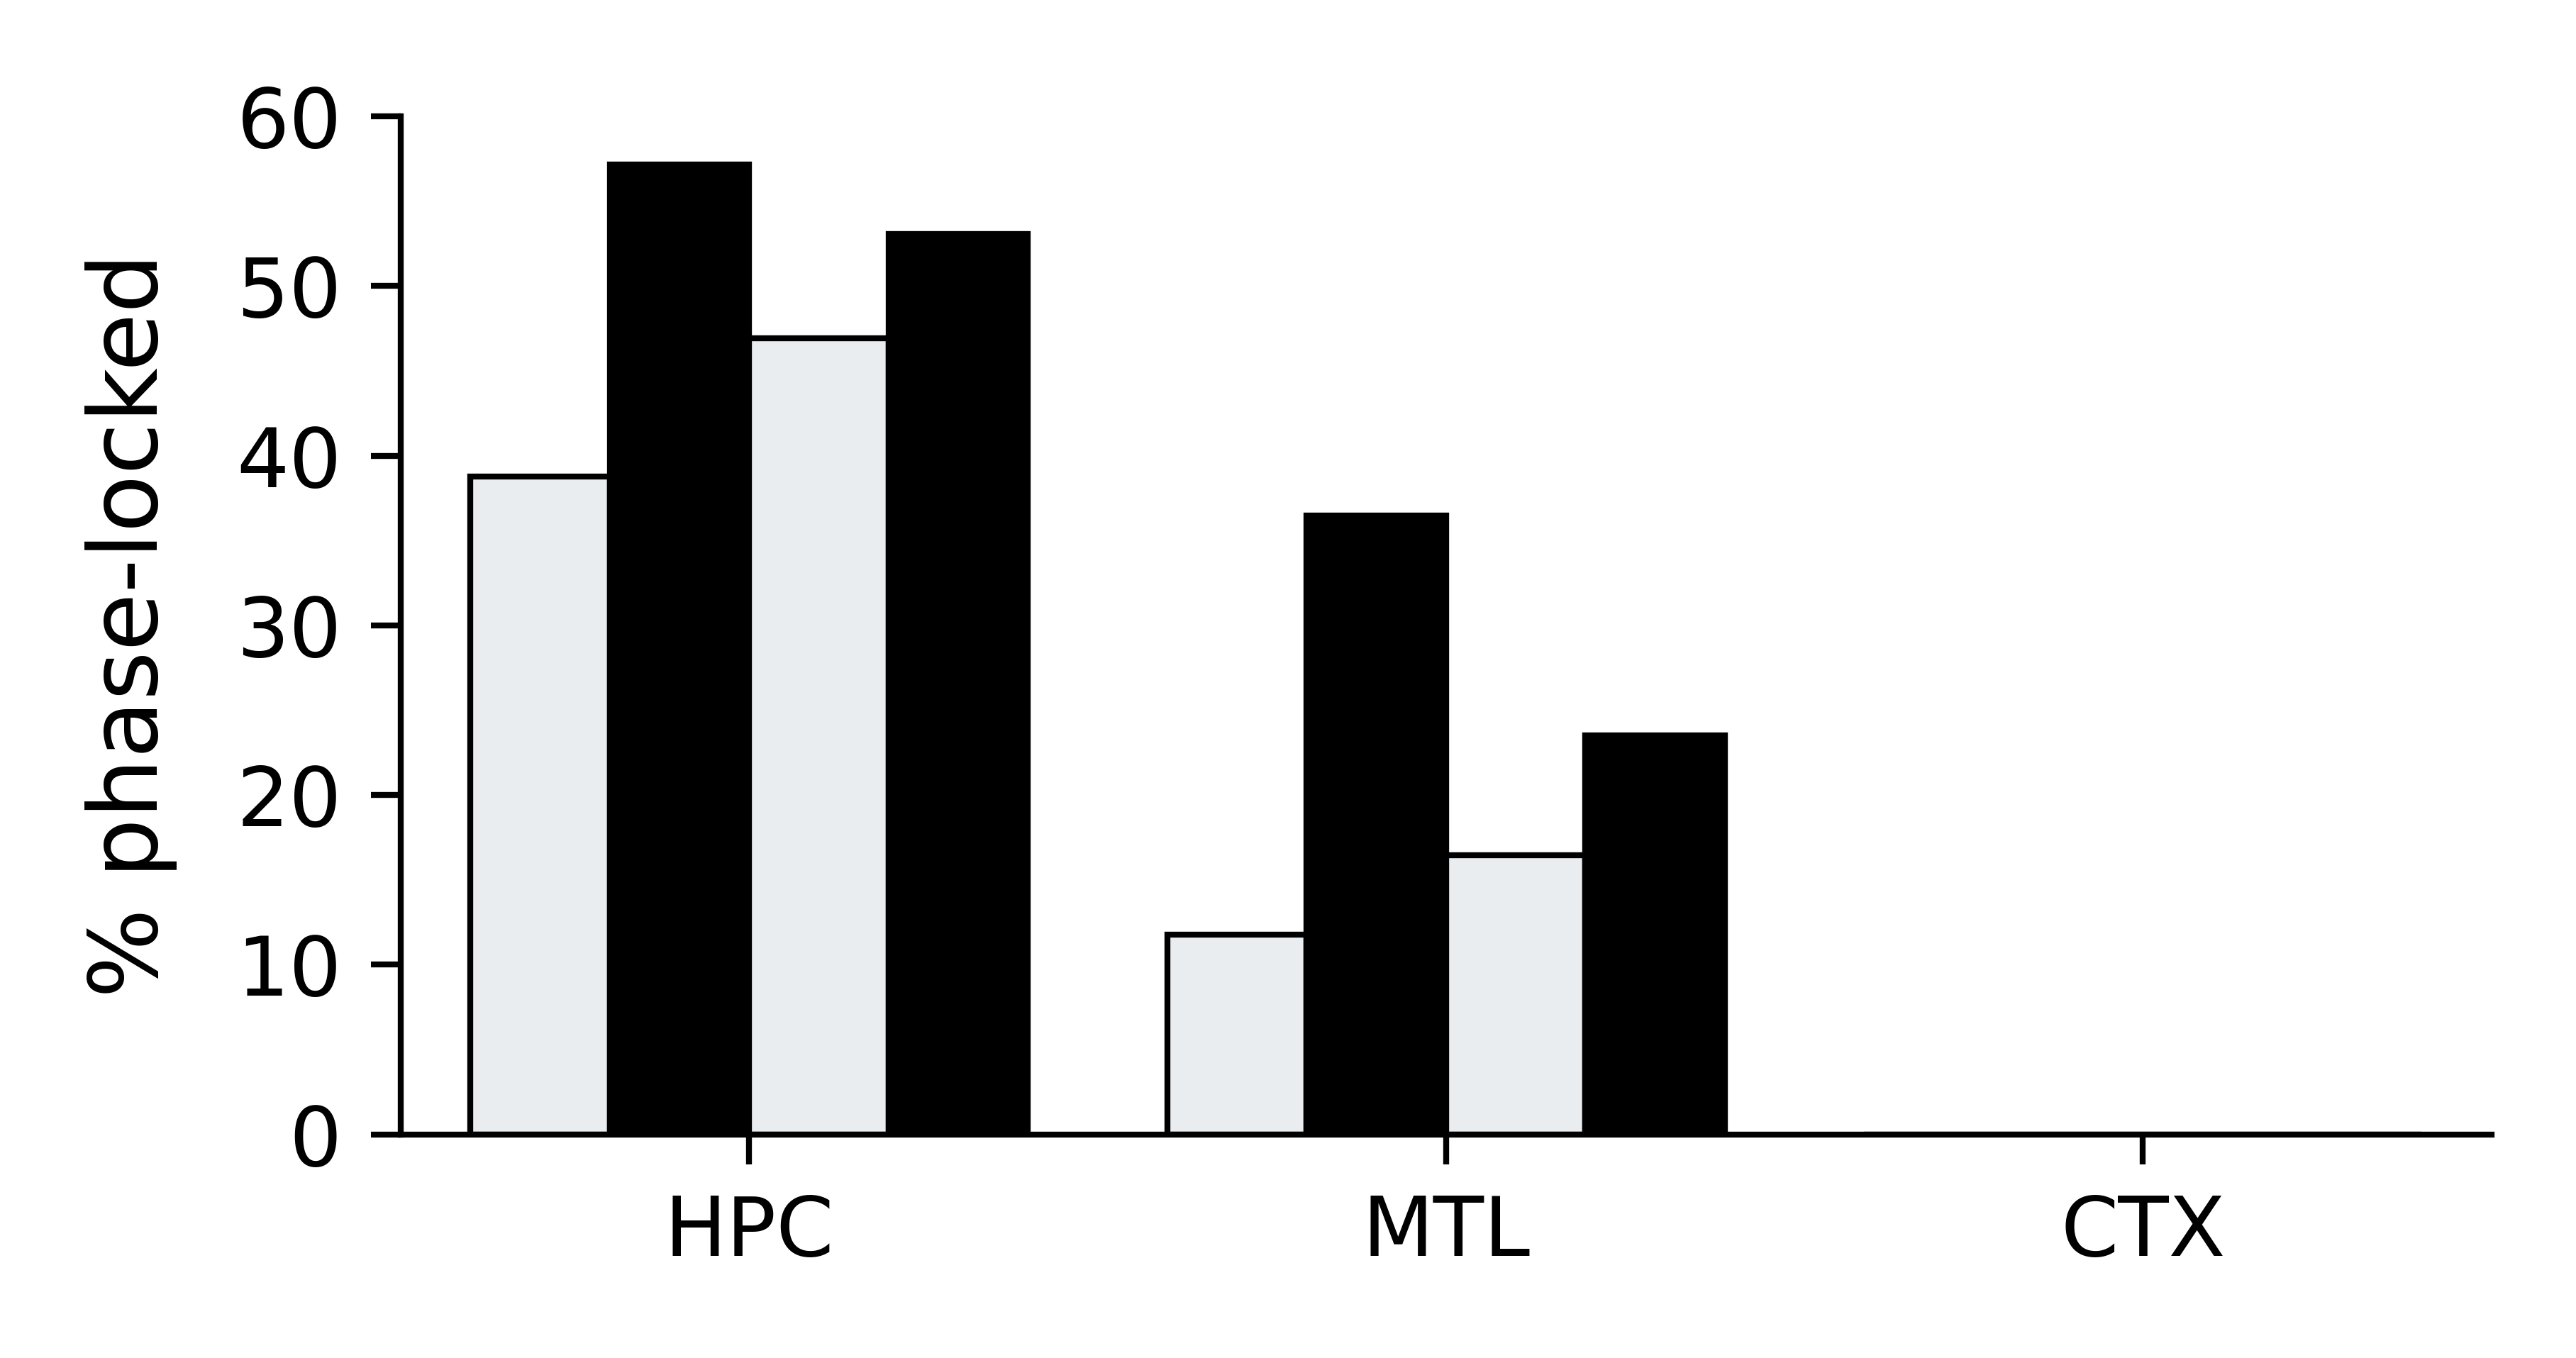

In [38]:
# Plot phase-locking percentage by region for the max phase-locking frequency.
roi_pairs = [('HPC', 'HPC'),
             ('MTL', 'HPC'),
             ('CTX', 'HPC')]
keep_masks = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
keep_rois = ['HPC', 'MTL', 'CTX']

savefig = 1
overwrite = 1
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = .6
yticks = [0, .1, .2, .3, .4, .5, .6]
yticklabs = [0, 10, 20, 30, 40, 50, 60]
bar_lw = 0.5
ebar_lw = 0.75
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
plot_err = False
capsize = 2.5
palette = [co['x1'], co['k']]
xticklabs = keep_rois
sig_col = 'sig_fdr'
is_local = [1, 0]

keys = [('')]

# ----------------------------
# Get the data.
roi_pairs = [('HPC', 'HPC'),
             ('MTL', 'HPC'),
             ('CTX', 'HPC')]
keep_masks = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

keep_rois = [x[0] for x in roi_pairs]
qry = "(expmt=='goldmine') & (mask=={}) & (unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}')"
dat = pd.concat([(pl_mrls
                  .query(qry.format(keep_masks, roi1, roi2)))
                 for (roi1, roi2) in roi_pairs],
                axis=0).reset_index(drop=True).copy()
dat['mask'] = dat['mask'].astype(pd.CategoricalDtype(keep_masks, ordered=True))
dat['unit_roi_gen2'] = dat['unit_roi_gen2'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
n_units = dat['subj_sess_unit'].nunique()
print('{} neurons'.format(n_units))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]

_ax = sns.barplot(x='unit_roi_gen2', y='sig_fdr', hue='mask',
                  order=keep_rois, hue_order=keep_masks,
                  data=dat, ax=_ax, palette=palette, saturation=1, alpha=bar_alpha,
                  ci=None, lw=bar_lw, ec='k')
# _ax = sns.stripplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
#                     palette=palette, size=stripsize, linewidth=spine_lw/2,
#                     alpha=1, dodge=True, jitter=jitter, zorder=1)
if plot_err:
    for iBar, locality in enumerate(is_local):
        _dat = dat.query("(is_local=={})".format(locality))
        xoffsets = [keep_rois.index(roi) + ((iBar - 0.5) * (0.8 / 2)) for roi in _dat['unit_roi_gen']]
        _ax.errorbar(xoffsets,
                     _dat['sig_fdr'].values,
                     yerr=np.abs(_dat['sig_fdr'].values[None, :] - np.array(_dat['ci'].tolist()).T),
                     lw=0, ecolor='k', elinewidth=ebar_lw, capthick=ebar_lw, capsize=capsize)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_rois)))
_ax.set_xticklabels(xticklabs, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs, fontsize=font['tick'])
_ax.set_ylabel('% phase-locked', fontsize=font['label'], labelpad=labelpad)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'goldmine', 
                       'goldmine_hpc-local_ctx-hpc_max-freq_pct-sig-fdr_across-{}-neurons.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

In [134]:
(pl_mrls
 .query("(mask=='all')")
 .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
 .groupby(['unit_roi_gen', 'lfp_roi_gen'])
 .agg({'sig_fdr': count_pct})
 .unstack('lfp_roi_gen'))

sig_fdr                                    \
lfp_roi_gen               HPC               EC              AMY   
unit_roi_gen                                                      
HPC           187/337 (55.5%)              NaN              NaN   
EC            111/265 (41.9%)  127/310 (41.0%)              NaN   
AMY            95/339 (28.0%)              NaN  173/372 (46.5%)   
PHG              2/167 (1.2%)              NaN              NaN   
STG              3/127 (2.4%)              NaN              NaN   
OFC              6/158 (3.8%)              NaN              NaN   
ACC              1/108 (0.9%)              NaN              NaN   

                                                                            
lfp_roi_gen              PHG             STG             OFC           ACC  
unit_roi_gen                                                                
HPC                      NaN             NaN             NaN           NaN  
EC                       NaN             NaN             NaN           NaN  
AMY                      NaN             NaN             NaN           NaN  
PHG           54/182 (29.7%)             NaN             NaN           NaN  
STG                      NaN  64/126 (50.8%)             NaN           NaN  
OFC                      NaN             NaN  25/168 (14.9%)           NaN  
ACC                      NaN             NaN             NaN  7/126 (5.6%)

In [135]:
(pl_mrls
 .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
 .groupby(['unit_roi_gen', 'lfp_roi_gen'])
 .agg({'sig_fdr': count_pct})
 .unstack('lfp_roi_gen'))

sig_fdr                                    \
lfp_roi_gen               HPC               EC              AMY   
unit_roi_gen                                                      
HPC           323/600 (53.8%)              NaN              NaN   
EC            171/523 (32.7%)  211/586 (36.0%)              NaN   
AMY           152/548 (27.7%)              NaN  265/609 (43.5%)   
PHG              2/295 (0.7%)              NaN              NaN   
STG              3/224 (1.3%)              NaN              NaN   
OFC              6/261 (2.3%)              NaN              NaN   
ACC              1/184 (0.5%)              NaN              NaN   

                                                                                
lfp_roi_gen               PHG              STG             OFC             ACC  
unit_roi_gen                                                                    
HPC                       NaN              NaN             NaN             NaN  
EC                        NaN              NaN             NaN             NaN  
AMY                       NaN              NaN             NaN             NaN  
PHG           193/426 (45.3%)              NaN             NaN             NaN  
STG                       NaN  110/201 (54.7%)             NaN             NaN  
OFC                       NaN              NaN  28/245 (11.4%)             NaN  
ACC                       NaN              NaN             NaN  27/202 (13.4%)

In [248]:
min_units = 5
min_subj = 5

# -----------------
df = (pl_mrls
      .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
      .groupby(['subj', 'unit_roi_gen', 'lfp_roi_gen'])
      .agg({'sig_fdr': [len, np.mean]}))
df.columns = ['n_units', 'sig_fdr']
df = (df
      .query("(n_units>={})".format(min_units))
      .groupby(['unit_roi_gen', 'lfp_roi_gen'])
      .agg({'sig_fdr': [len, np.mean]}))
df.columns = ['n_subj', 'sig_fdr']
df = df.unstack('lfp_roi_gen')

mask = np.invert(df['n_subj'] >= min_subj)

In [485]:
# In which regions are neurons most keen on phase-locking to other regions?
(pl_mrls
 .query("(same_roi_gen==False)")
 .groupby(['unit_roi_gen'])
 .agg({'sig_fdr': count_pct}).T)

unit_roi_gen              HPC               AMY                EC  \
sig_fdr       150/902 (16.6%)  214/1138 (18.8%)  164/1019 (16.1%)   

unit_roi_gen           PHG            OFC             CC            LTC  
sig_fdr       2/531 (0.4%)  17/543 (3.1%)  10/690 (1.4%)  19/453 (4.2%)

In [486]:
# In which regions are oscillations synchronizing neurons from other regions?
(pl_mrls
 .query("(same_roi_gen==False)")
 .groupby(['lfp_roi_gen'])
 .agg({'sig_fdr': count_pct}).T)

lfp_roi_gen               HPC              AMY               EC  \
sig_fdr      227/1226 (18.5%)  100/853 (11.7%)  121/887 (13.6%)   

lfp_roi_gen             PHG            OFC            CC            LTC  
sig_fdr      75/592 (12.7%)  38/654 (5.8%)  5/587 (0.9%)  10/477 (2.1%)

In [546]:
df = (pl_mrls
      .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
      .groupby(['subj', 'unit_roi_gen', 'lfp_roi_gen'])
      .agg({'max_z_mrl': [len, np.mean]}))
df.columns = ['n_units', 'max_z_mrl']
df = (df
      .query("(n_units>={})".format(min_units))
      .groupby(['unit_roi_gen', 'lfp_roi_gen'])
      .agg({'max_z_mrl': [len, np.mean]}))
df.columns = ['n_subj', 'max_z_mrl']
df = df.unstack('lfp_roi_gen')
mask = np.invert(df['n_subj'] >= min_subj)
dat = df['max_z_mrl']

In [547]:
df

n_subj                        max_z_mrl                      \
lfp_roi_gen     HPC AMY  EC PHG OFC CC LTC       HPC       AMY        EC   
unit_roi_gen                                                               
HPC              20  13  11   9   9  8   7  6.532310  3.373255  3.642808   
AMY              19  19  13   9  12  8   5  4.889837  5.726503  4.746204   
EC               12   9  14   8   6  6   3  5.429881  3.487240  4.638216   
PHG              10  10   7  10   3  3   2  2.282649  1.916585  2.134528   
OFC              10   8   8   5  11  6   4  2.656537  2.302319  2.085482   
CC                7   4   5   3   5  7   3  2.516528  2.236793  2.071340   
LTC               5   3   3   2   3  4   5  2.902769  2.367317  3.091348   

                                                      
lfp_roi_gen        PHG       OFC        CC       LTC  
unit_roi_gen                                          
HPC           3.281961  2.518145  2.028371  2.133936  
AMY           3.400095  2.648770  2.021186  3.011314  
EC            2.422580  2.508663  2.465615  2.184772  
PHG           4.873728  1.971294  1.985528  2.023887  
OFC           4.271952  4.132241  2.235206  2.222966  
CC            2.427250  2.313876  2.943265  2.128155  
LTC           2.183694  1.945375  1.925917  5.146816

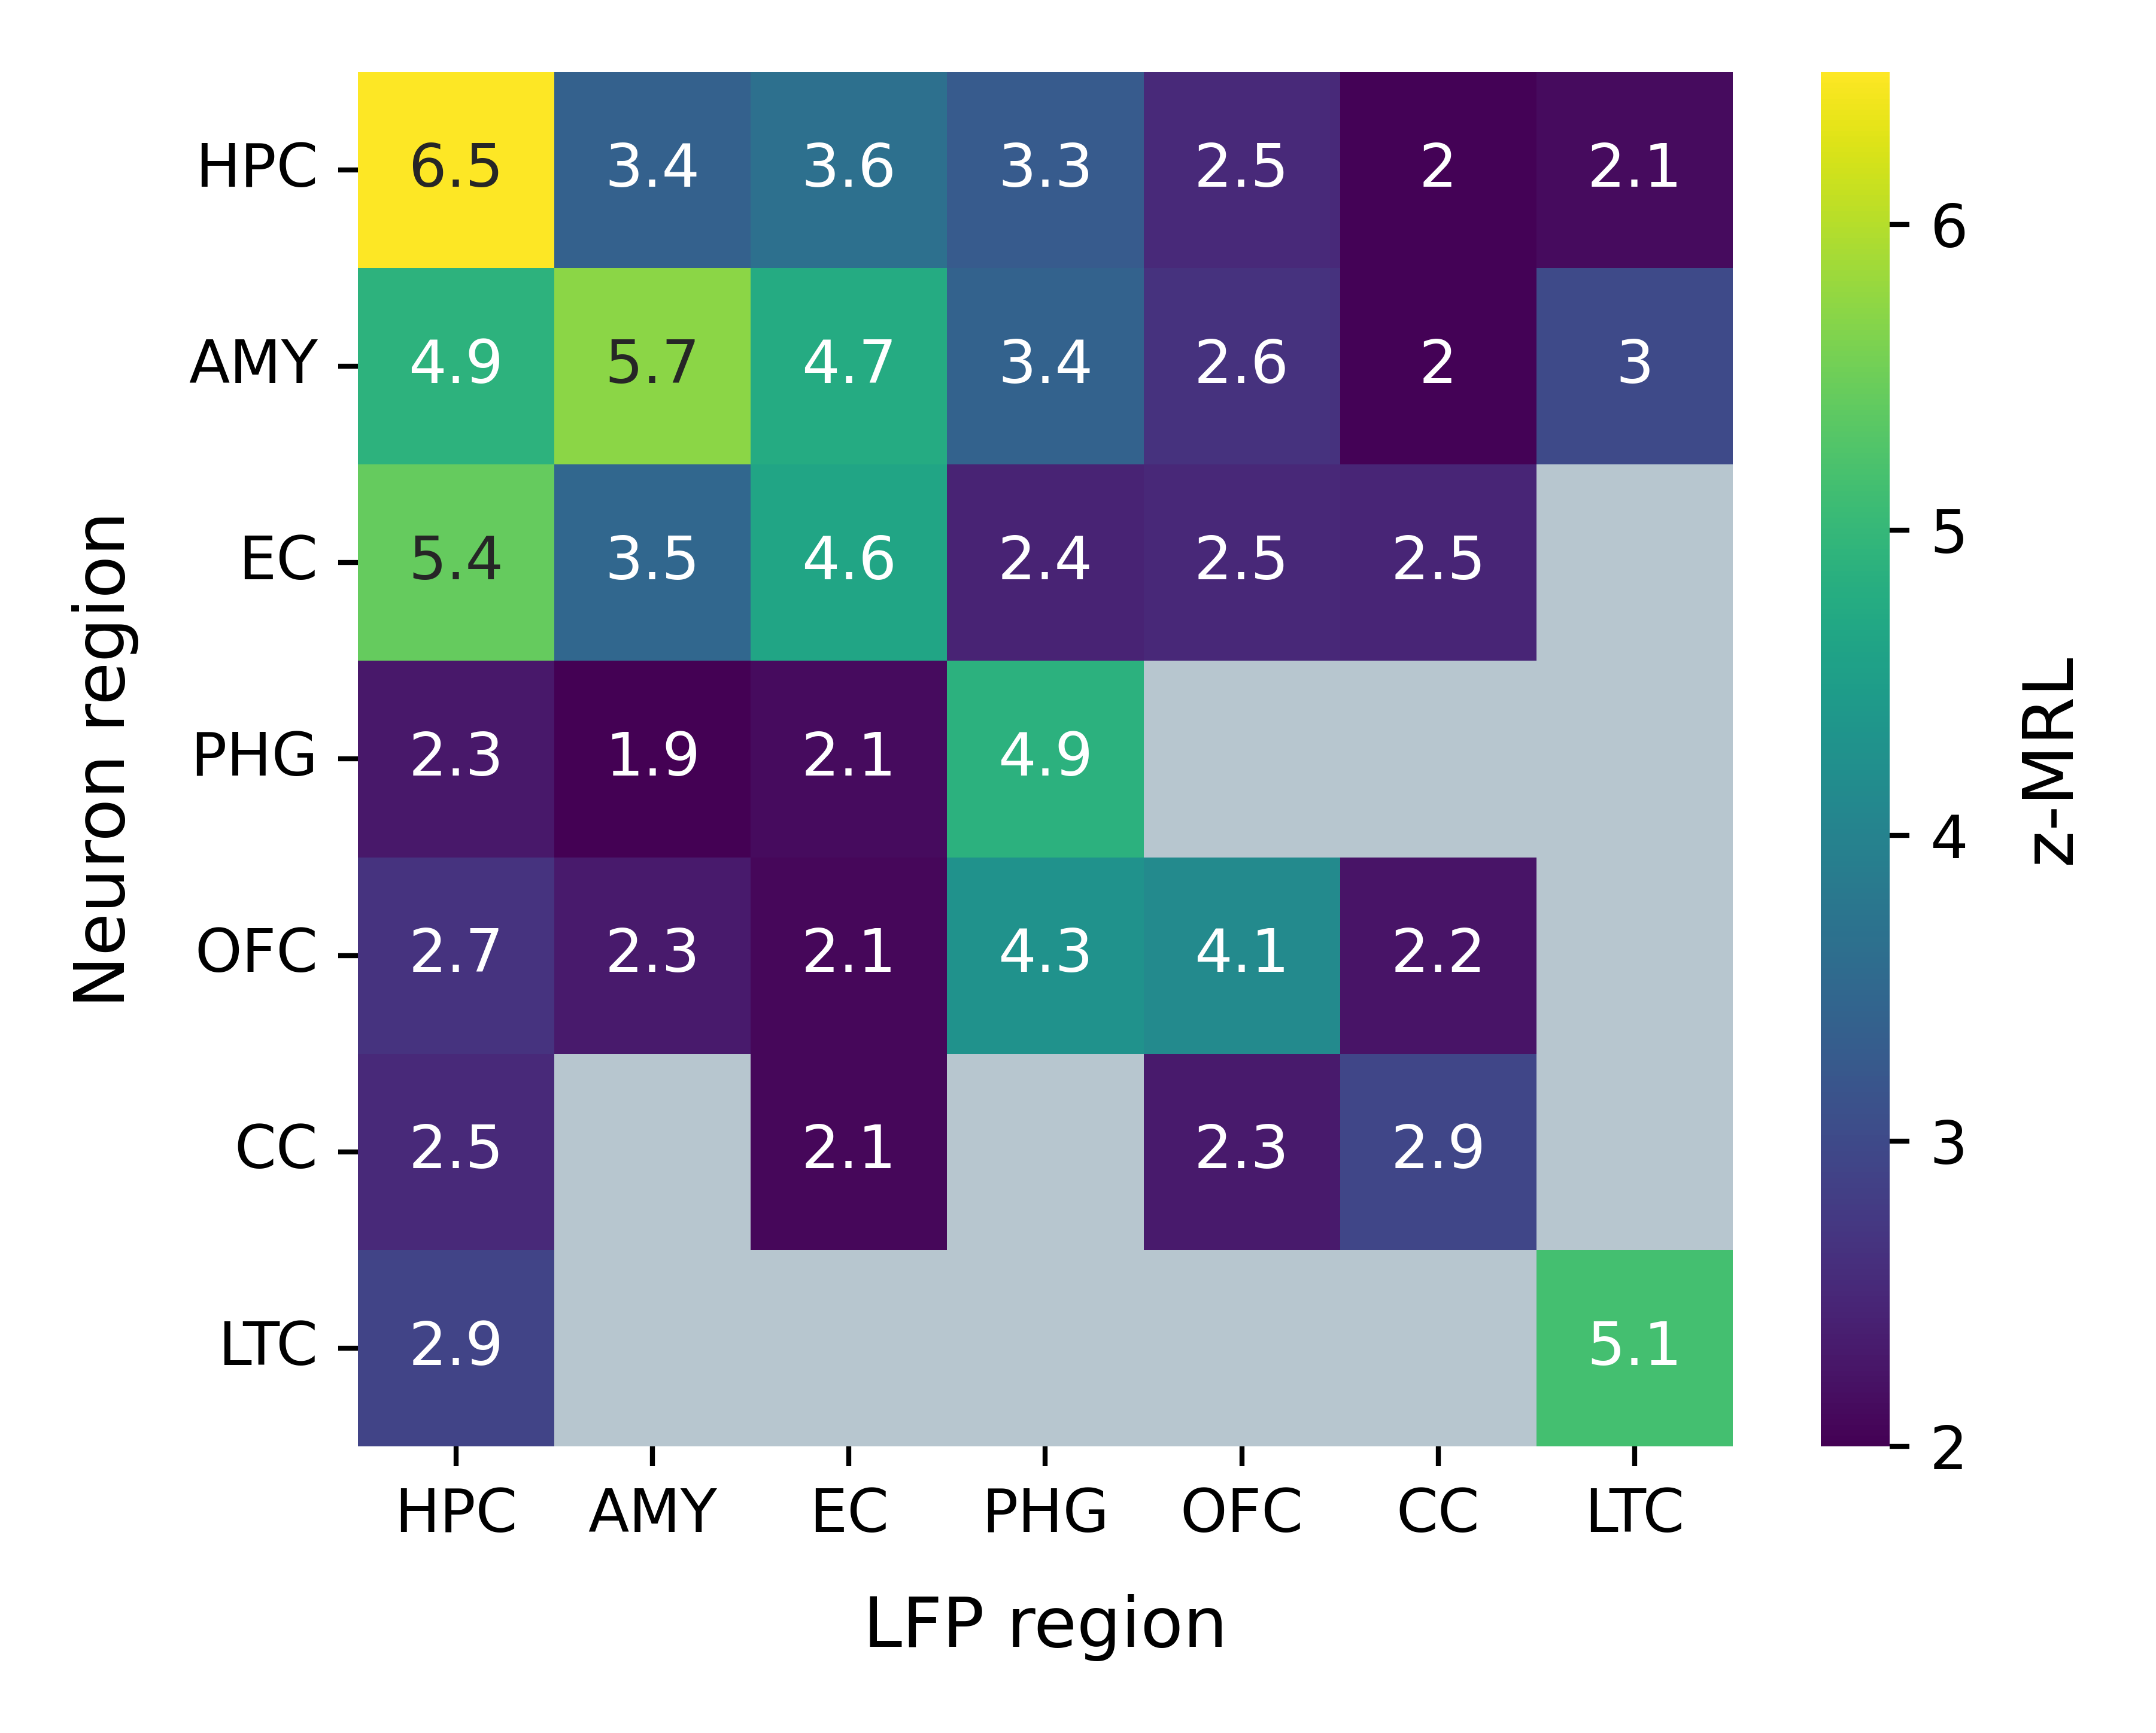

In [550]:
min_units = 5
min_subj = 5
figsize = (colws[2], colws[2]*0.8)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
ax_facecolor = co['x2']
spine_lw = 0.5
ticklen = 2
tickpad = 2
labelpad = 5
xticks = np.arange(len(gen_rois)) + 0.5
xticklabs = gen_rois
yticks = xticks
yticklabs = xticklabs
xlab = 'LFP region'
ylab = 'Neuron region'
cmap = 'viridis'
vmin = 2
vmax = 6.5
cbarticks = [2, 3, 4, 5, 6]
cbarlab = 'z-MRL'

# --------------------
# Get the data.
df = (pl_mrls
      .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
      .groupby(['subj', 'unit_roi_gen', 'lfp_roi_gen'])
      .agg({'max_z_mrl': [len, np.mean]}))
df.columns = ['n_units', 'max_z_mrl']
df = (df
      .query("(n_units>={})".format(min_units))
      .groupby(['unit_roi_gen', 'lfp_roi_gen'])
      .agg({'max_z_mrl': [len, np.mean]}))
df.columns = ['n_subj', 'max_z_mrl']
df = df.unstack('lfp_roi_gen')
mask = np.invert(df['n_subj'] >= min_subj)
dat = df['max_z_mrl']

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.heatmap(dat, mask=mask, vmin=vmin, vmax=vmax, ax=_ax, 
                  square=True, cmap=cmap, cbar=True, annot=True)

_ax.set_facecolor(ax_facecolor)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_xlabel(xlab, fontsize=font['label'], labelpad=labelpad)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel(ylab, fontsize=font['label'], labelpad=labelpad)
cbar = _ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font['tick'], length=ticklen, pad=tickpad, width=spine_lw)
cbar.set_ticks(cbarticks)
cbar.set_ticklabels(cbarticks)
cbar.set_label(cbarlab, fontsize=font['label'], labelpad=labelpad)

fig.show()

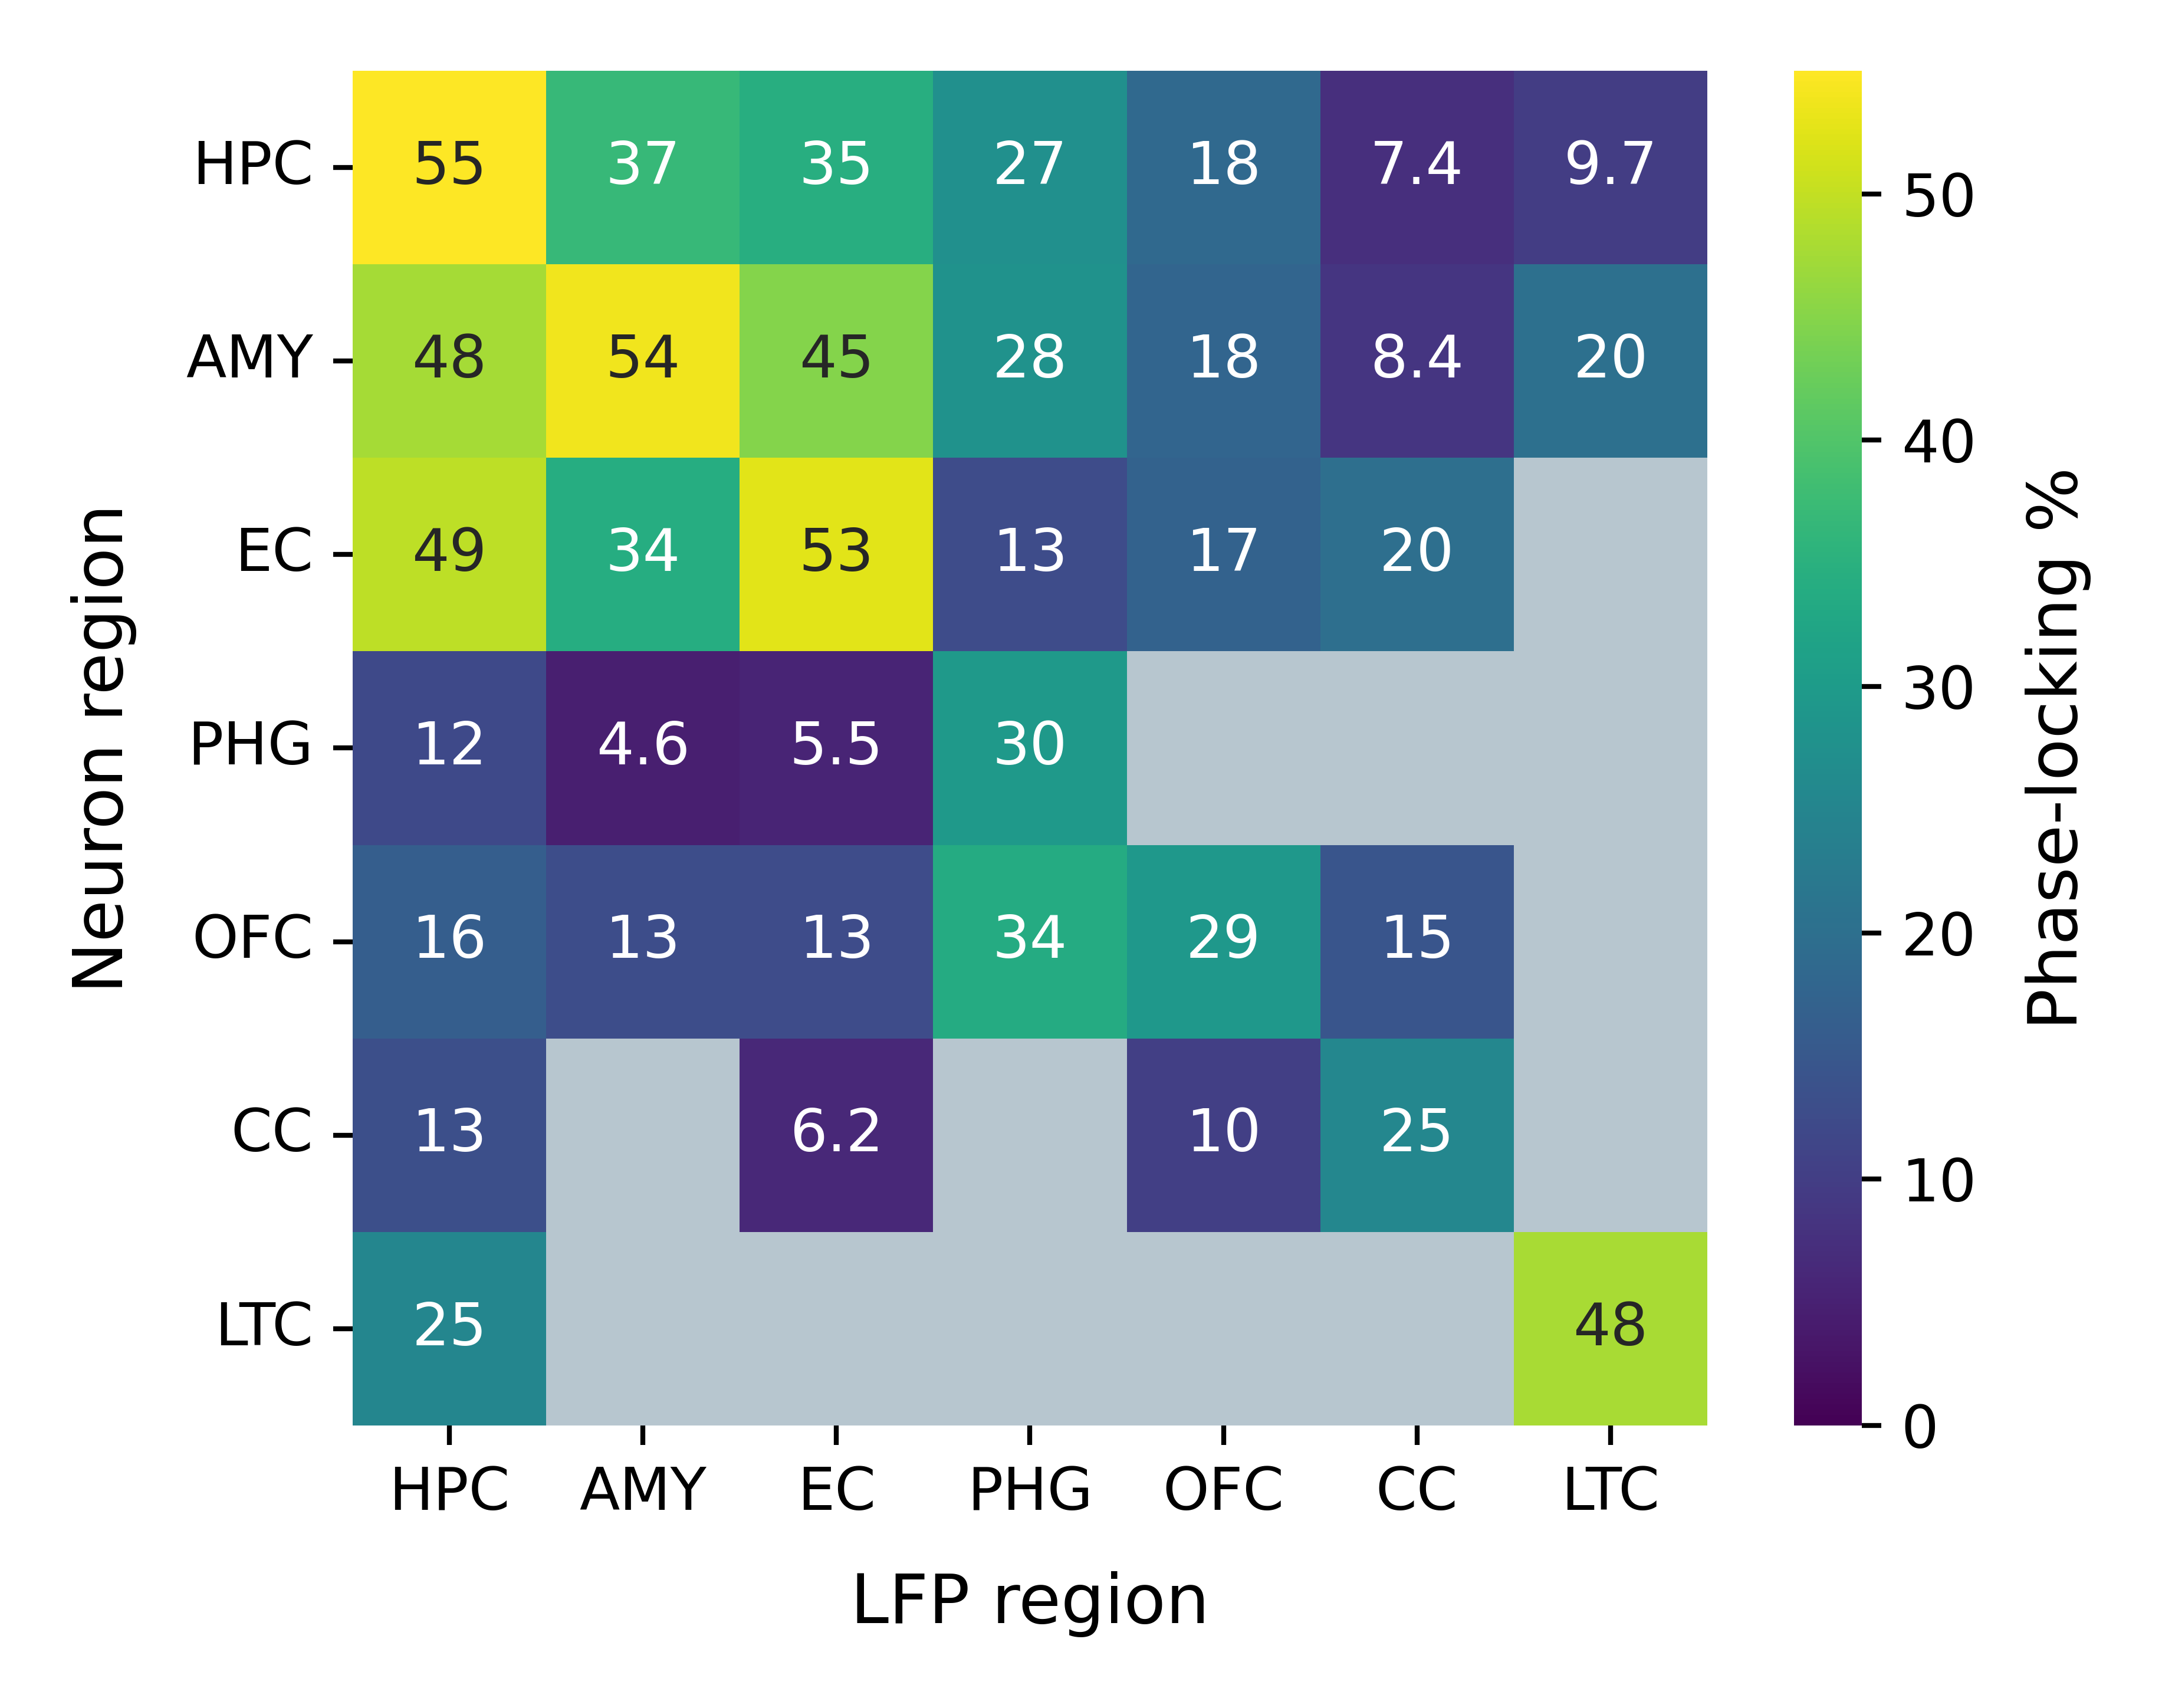

In [552]:
min_units = 5
min_subj = 5
figsize = (colws[2], colws[2]*0.8)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
ax_facecolor = co['x2']
spine_lw = 0.5
ticklen = 2
tickpad = 2
labelpad = 5
xticks = np.arange(len(gen_rois)) + 0.5
xticklabs = gen_rois
yticks = xticks
yticklabs = xticklabs
xlab = 'LFP region'
ylab = 'Neuron region'
cmap = 'viridis'
vmin = 0
vmax = 55
cbarticks = [0, 10, 20, 30, 40, 50]
cbarlab = 'Phase-locking %'

# --------------------
# Get the data.
df = (pl_mrls
      .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
      .groupby(['subj', 'unit_roi_gen', 'lfp_roi_gen'])
      .agg({'sig': [len, np.mean]}))
df.columns = ['n_units', 'sig']
df = (df
      .query("(n_units>={})".format(min_units))
      .groupby(['unit_roi_gen', 'lfp_roi_gen'])
      .agg({'sig': [len, np.mean]}))
df.columns = ['n_subj', 'sig']
df = df.unstack('lfp_roi_gen')
mask = np.invert(df['n_subj'] >= min_subj)
dat = df['sig']
dat *= 100

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.heatmap(dat, mask=mask, vmin=vmin, vmax=vmax, ax=_ax,
                  square=True, cmap=cmap, cbar=True, annot=True)

_ax.set_facecolor(ax_facecolor)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_xlabel(xlab, fontsize=font['label'], labelpad=labelpad)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel(ylab, fontsize=font['label'], labelpad=labelpad)
cbar = _ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font['tick'], length=ticklen, pad=tickpad, width=spine_lw)
cbar.set_ticks(cbarticks)
cbar.set_ticklabels(cbarticks)
cbar.set_label(cbarlab, fontsize=font['label'], labelpad=labelpad)

fig.show()

In [535]:
# FDR correct p-values, separately within each unit-to-LFP region pair.
alpha = 0.05

pl_mrls.drop(columns=[col for col in list(set(['pval_fdr', 'sig_fdr']) & set(pl_mrls.columns))], inplace=True)
pl_mrls.insert(pl_mrls.columns.tolist().index('sig')+1, 'pval_fdr', np.nan)
pl_mrls.insert(pl_mrls.columns.tolist().index('sig')+2, 'sig_fdr', np.nan)

for (is_local, unit_roi_gen, lfp_roi_gen), df in pl_mrls.groupby(['is_local', 'unit_roi_gen', 'lfp_roi_gen'], observed=True):
    sig_fdr, pval_fdr, *_ = sm.stats.multipletests(df['pval'], alpha=alpha, method='fdr_tsbky')
    pl_mrls.loc[df.index, 'pval_fdr'] = pval_fdr
    pl_mrls.loc[df.index, 'sig_fdr'] = sig_fdr

In [538]:
dat = (pl_mrls
       .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
       .groupby(['unit_roi_gen', 'lfp_roi_gen'])
       .agg({'sig': count_pct})
       .unstack('lfp_roi_gen'))
dat

sig                                    \
lfp_roi_gen               HPC              AMY               EC   
unit_roi_gen                                                      
HPC           191/334 (57.2%)   75/212 (35.4%)   58/192 (30.2%)   
AMY           129/335 (38.5%)  173/366 (47.3%)   78/257 (30.4%)   
EC            118/260 (45.4%)   55/197 (27.9%)  133/304 (43.8%)   
PHG            22/166 (13.3%)     9/156 (5.8%)     6/118 (5.1%)   
OFC            18/157 (11.5%)    13/135 (9.6%)   12/108 (11.1%)   
CC             21/170 (12.4%)     8/74 (10.8%)   15/142 (10.6%)   
LTC            24/138 (17.4%)    12/79 (15.2%)    13/70 (18.6%)   

                                                                              
lfp_roi_gen              PHG             OFC              CC             LTC  
unit_roi_gen                                                                  
HPC           39/153 (25.5%)  20/151 (13.2%)    7/113 (6.2%)   10/81 (12.3%)  
AMY           34/148 (23.0%)  35/181 (19.3%)   11/150 (7.3%)    8/67 (11.9%)  
EC            19/139 (13.7%)  26/139 (18.7%)  29/151 (19.2%)   13/133 (9.8%)  
PHG           56/182 (30.8%)     0/47 (0.0%)     1/26 (3.8%)    4/18 (22.2%)  
OFC            15/42 (35.7%)  46/167 (27.5%)    9/70 (12.9%)    5/31 (16.1%)  
CC             15/70 (21.4%)   10/87 (11.5%)  62/188 (33.0%)   13/147 (8.8%)  
LTC             5/40 (12.5%)     1/49 (2.0%)     4/77 (5.2%)  70/138 (50.7%)

In [537]:
dat = (pl_mrls
       .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
       .groupby(['unit_roi_gen', 'lfp_roi_gen'])
       .agg({'sig_fdr': count_pct})
       .unstack('lfp_roi_gen'))
dat

sig_fdr                                    \
lfp_roi_gen               HPC              AMY               EC   
unit_roi_gen                                                      
HPC           195/334 (58.4%)   61/212 (28.8%)   50/192 (26.0%)   
AMY           100/335 (29.9%)  168/366 (45.9%)   56/257 (21.8%)   
EC            110/260 (42.3%)   39/197 (19.8%)  123/304 (40.5%)   
PHG              0/166 (0.0%)     0/156 (0.0%)     0/118 (0.0%)   
OFC              7/157 (4.5%)     0/135 (0.0%)     0/108 (0.0%)   
CC               0/170 (0.0%)      0/74 (0.0%)     6/142 (4.2%)   
LTC             10/138 (7.2%)      0/79 (0.0%)     9/70 (12.9%)   

                                                                              
lfp_roi_gen              PHG             OFC              CC             LTC  
unit_roi_gen                                                                  
HPC           30/153 (19.6%)    7/151 (4.6%)    0/113 (0.0%)     2/81 (2.5%)  
AMY           29/148 (19.6%)  23/181 (12.7%)    0/150 (0.0%)     6/67 (9.0%)  
EC              6/139 (4.3%)    4/139 (2.9%)    5/151 (3.3%)    0/133 (0.0%)  
PHG           43/182 (23.6%)     0/47 (0.0%)     0/26 (0.0%)    2/18 (11.1%)  
OFC            10/42 (23.8%)  28/167 (16.8%)     0/70 (0.0%)     0/31 (0.0%)  
CC               0/70 (0.0%)     4/87 (4.6%)  52/188 (27.7%)    0/147 (0.0%)  
LTC              0/40 (0.0%)     0/49 (0.0%)     0/77 (0.0%)  68/138 (49.3%)

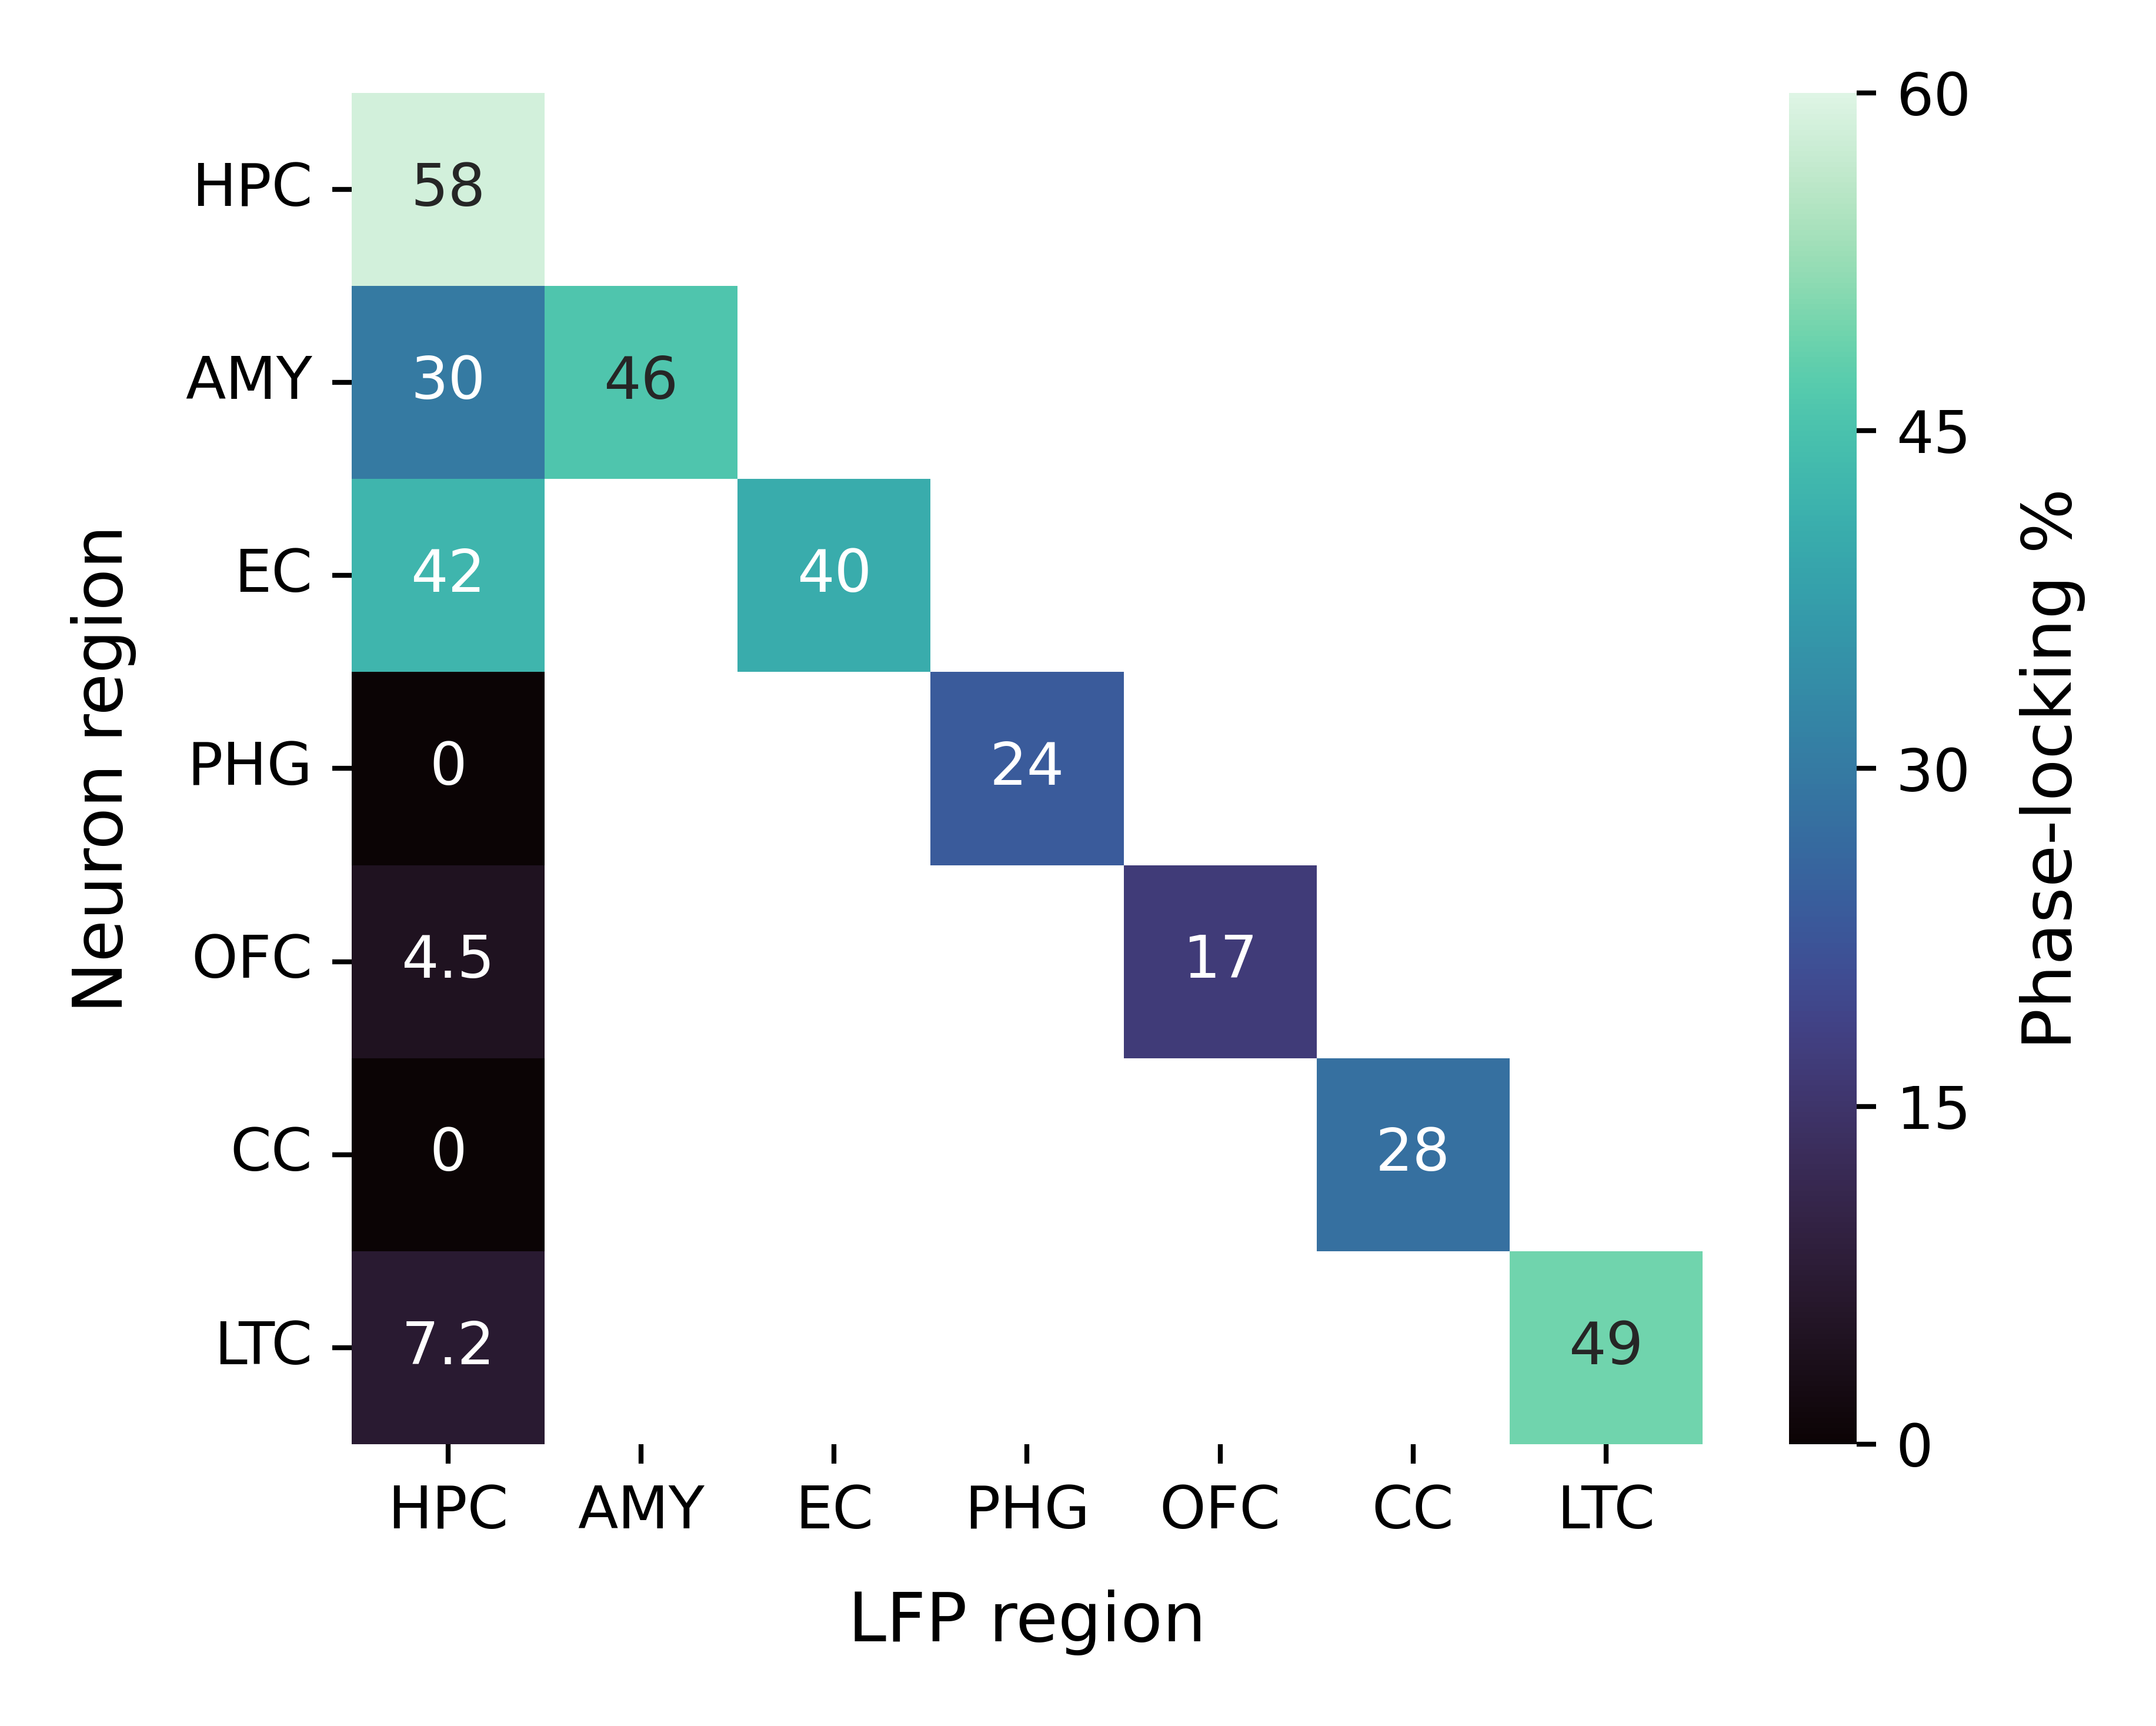

In [542]:
figsize = (colws[2], colws[2]*0.8)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
spine_lw = 0.5
ticklen = 2
tickpad = 2
labelpad = 5
xticks = np.arange(len(gen_rois)) + 0.5
xticklabs = gen_rois
yticks = xticks
yticklabs = xticklabs
xlab = 'LFP region'
ylab = 'Neuron region'
cmap = 'mako'
vmin = 0
vmax = 60
cbarticks = [0, 15, 30, 45, 60]
cbarlab = 'Phase-locking %'

# --------------------
# Get the data.
dat = (pl_mrls
       .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
       .groupby(['unit_roi_gen', 'lfp_roi_gen'])
       .agg({'sig_fdr': np.mean})
       .unstack('lfp_roi_gen'))
dat *= 100

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.heatmap(dat, vmin=vmin, vmax=vmax, ax=_ax,
                  square=True, cmap=cmap, cbar=True, annot=True)

_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_xlabel(xlab, fontsize=font['label'], labelpad=labelpad)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel(ylab, fontsize=font['label'], labelpad=labelpad)
cbar = _ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font['tick'], length=ticklen, pad=tickpad, width=spine_lw)
cbar.set_ticks(cbarticks)
cbar.set_ticklabels(cbarticks)
cbar.set_label(cbarlab, fontsize=font['label'], labelpad=labelpad)
    
fig.show()

# z-MRL by freq: region means

In [107]:
keep_rois = gen_rois2
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']

n_units = (pl_mrls
           .groupby(['unit_roi_gen2', 'lfp_roi_gen2'])
           ['subj_sess_unit'].apply(lambda x: len(np.unique(x))))
n_pl_units = (pl_mrls
              .query("(sig_fdr==True)")
              .groupby(['unit_roi_gen2', 'lfp_roi_gen2'])
              ['subj_sess_unit'].apply(lambda x: len(np.unique(x))))

zmrls = []
for unit_roi in keep_rois:
    for lfp_roi in keep_rois:
        for mask in keep_masks:
            qry = ("(unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}') & (mask=='{}')"
                   .format(unit_roi, lfp_roi, mask))
            _zmrls = np.array(pl_mrls.query(qry)['z_mrls'].tolist())
            if len(_zmrls) > 1:
                _n_subjs = pl_mrls.query(qry)['subj'].nunique()
                _n_units = _zmrls.shape[0]
                pct_units = 100 * (_n_units/n_units[(unit_roi, lfp_roi)])
                pct_pl_units = 100 * (_n_units/n_pl_units[(unit_roi, lfp_roi)])

                _mean_zmrls = np.nanmean(_zmrls, axis=0).tolist()
                _sem_zmrls = stats.sem(_zmrls, axis=0, nan_policy='omit').tolist()
                zmrls.append([unit_roi, lfp_roi, mask, _n_subjs, _n_units,
                              pct_units, pct_pl_units, _mean_zmrls, _sem_zmrls, _zmrls.tolist()])
            
cols = ['unit_roi', 'lfp_roi', 'mask', 'subjs', 'units',
        'pct_units', 'pct_pl_units', 'mean_zmrls', 'sem_zmrls', 'zmrls']
zmrls = pd.DataFrame(zmrls, columns=cols).set_index(['unit_roi', 'lfp_roi', 'mask'])

print('zmrls: {}'.format(zmrls.shape))

zmrls: (20, 7)


In [ ]:
min_units_per_subj = 3
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']

qry = "(mask=={})".format(keep_masks)
subj_zmrls = (pl_mrls
              .query(qry)
              .groupby(['unit_roi_gen2', 'lfp_roi_gen2', 'mask', 'subj'], observed=True)
              .agg({'subj_sess_unit': lambda x: np.unique(x).size,
                    'z_mrls': lambda x: np.nanmean(list(x), axis=0).tolist()})
              .query("(subj_sess_unit>={})".format(min_units_per_subj))
              .reset_index()
              .groupby(['unit_roi_gen2', 'lfp_roi_gen2', 'mask'], observed=True)
              .agg({'subj': len,
                    'subj_sess_unit': [np.sum,
                                       lambda x: list(np.sort(x))],
                    'z_mrls': [lambda x: np.nanmean(np.array(list(x)), axis=0).tolist(),
                               lambda y: stats.sem(np.array(list(y)), axis=0, nan_policy='omit').tolist()]
                   }))
subj_zmrls.columns = ['subjs', 'units', 'units_per_subj', 'mean_zmrls', 'sem_zmrls']
subj_zmrls

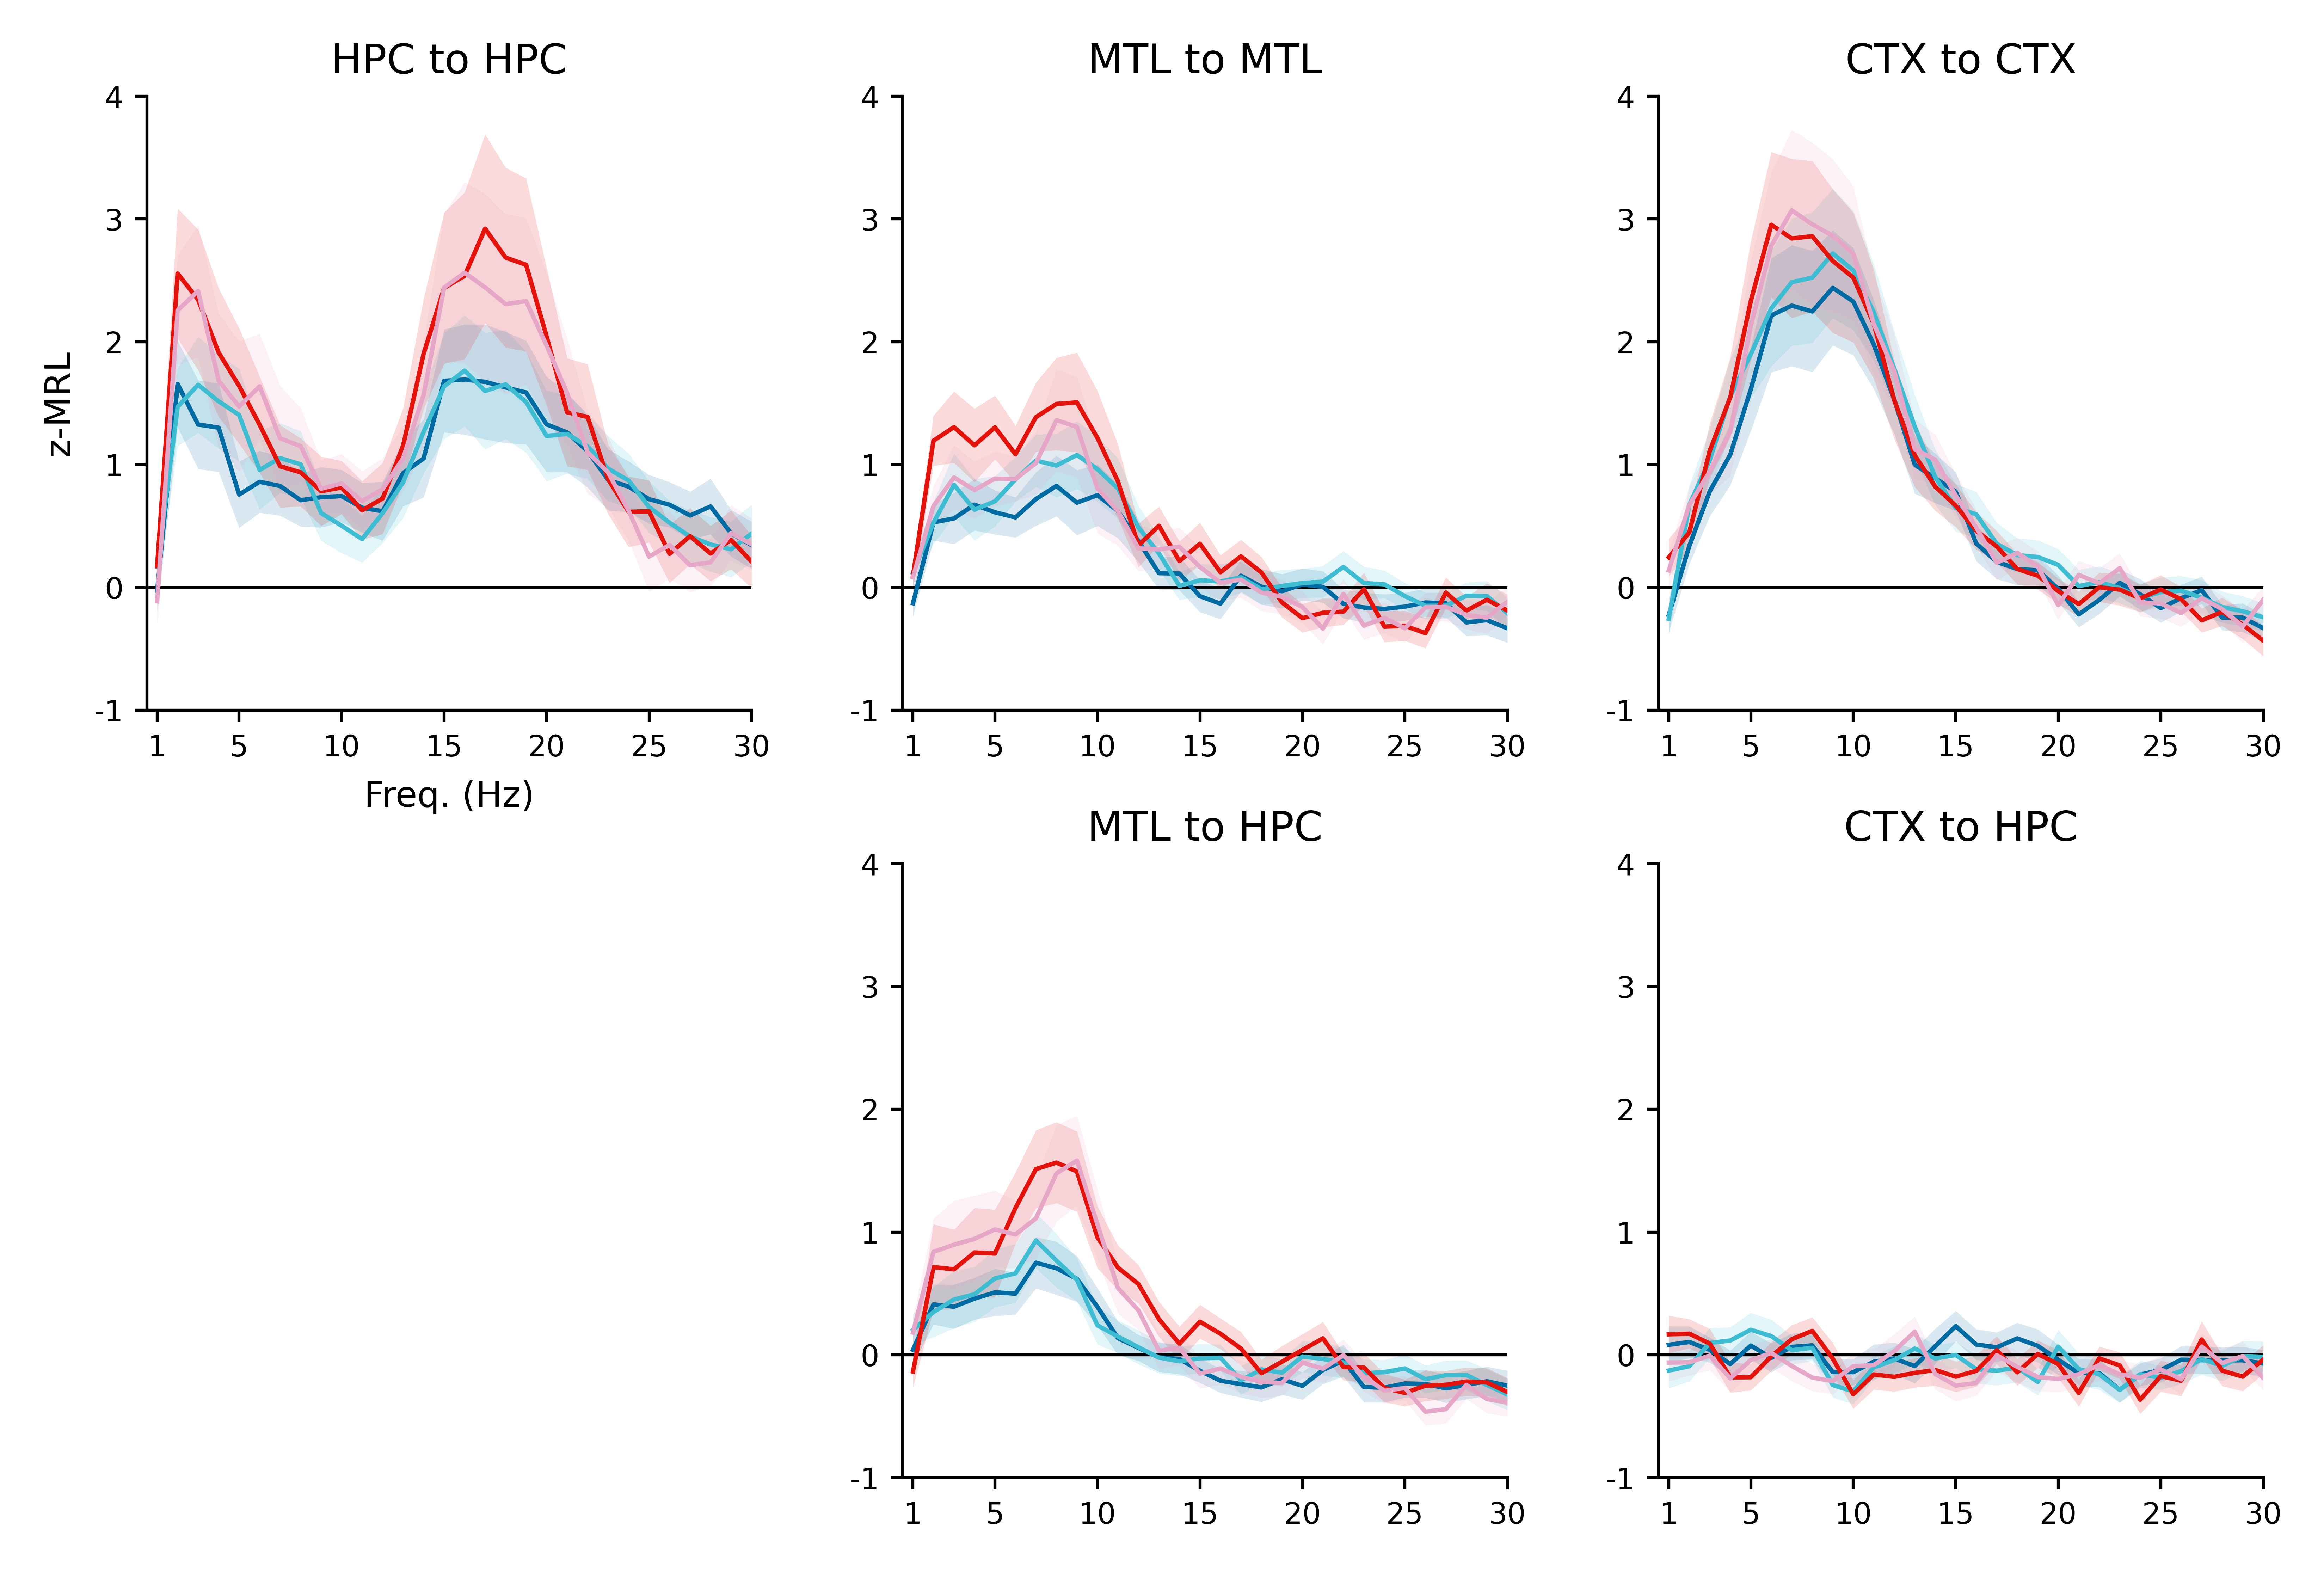

In [ ]:
roi_pairs = [
    ('HPC', 'HPC'),
    ('MTL', 'MTL'),
    ('CTX', 'CTX'),
    ('', ''),
    ('MTL', 'HPC'),
    ('CTX', 'HPC'),
]
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
savefig = 0
overwrite = 0
figsize = (colws[3], colws[3]*0.67)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
spine_lw = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0.5, 30]
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (-1, 4)
yticks = [-1, 0, 1, 2, 3, 4]
yticklabs = yticks
lw = 0.75
linecolor = {'Delay1': co['b'],
             'Delay2': co['c'],
             'Encoding': co['r'],
             'Retrieval': co['p2']}
linewidths = {'local': 1,
              'distal': 1}
plot_hline = True
hline = 0
hline_color = co['k']
verbose = False

# ------------------------------------
# Plot the data.
plt.close()
fig, ax = plt.subplots(2, 3, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for (iax, (unit_roi, lfp_roi)) in enumerate(roi_pairs):
    _ax = ax[iax]
    if iax == 3:
        _ax.axis('off')
        continue
    
    if plot_hline:
        _ax.axhline(hline, color=hline_color, lw=spine_lw)

    for mask in keep_masks:
        _means = np.array(zmrls.at[(unit_roi, lfp_roi, mask), 'mean_zmrls'])
        _sems = np.array(zmrls.at[(unit_roi, lfp_roi, mask), 'sem_zmrls'])
        _ax.fill_between(xvals,
                         _means + _sems,
                         _means - _sems,
                         alpha=0.15, lw=0, color=linecolor[mask])
        _ax.plot(xvals, _means, lw=lw, color=linecolor[mask])
        
        if verbose:
            print('{} to {}, {}: {} neurons, {} subjs, min={:.2f}, max={:.2f}'
                  .format(unit_roi,
                          lfp_roi,
                          mask,
                          zmrls.at[(unit_roi, lfp_roi, mask), 'units'],
                          zmrls.at[(unit_roi, lfp_roi, mask), 'subjs'],
                          np.nanmin(_means - _sems),
                          np.nanmax(_means + _sems)))

    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
    _ax.set_xlim(xlim)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticks, fontsize=font['tick'])
    if iax == 0:
        _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('z-MRL', fontsize=font['label'], labelpad=labelpad)
    _ax.set_title('{} to {}'.format(unit_roi, lfp_roi), fontsize=font['fig'], y=0.98)

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'phase_lock_freqs', 
                       'zMRL-by-freq_{}-{}Hz-sig-fdr-phase-locked_{}-neurons.pdf'
                       .format(low, high,
                               '_'.join(['{}{}-{}'
                                         .format(zmrls.at[(unit_roi, lfp_roi, band), 'units'],
                                                 unit_roi,
                                                 'local' if (unit_roi==lfp_roi) else lfp_roi)
                                         for (unit_roi, lfp_roi) in roi_pairs])))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

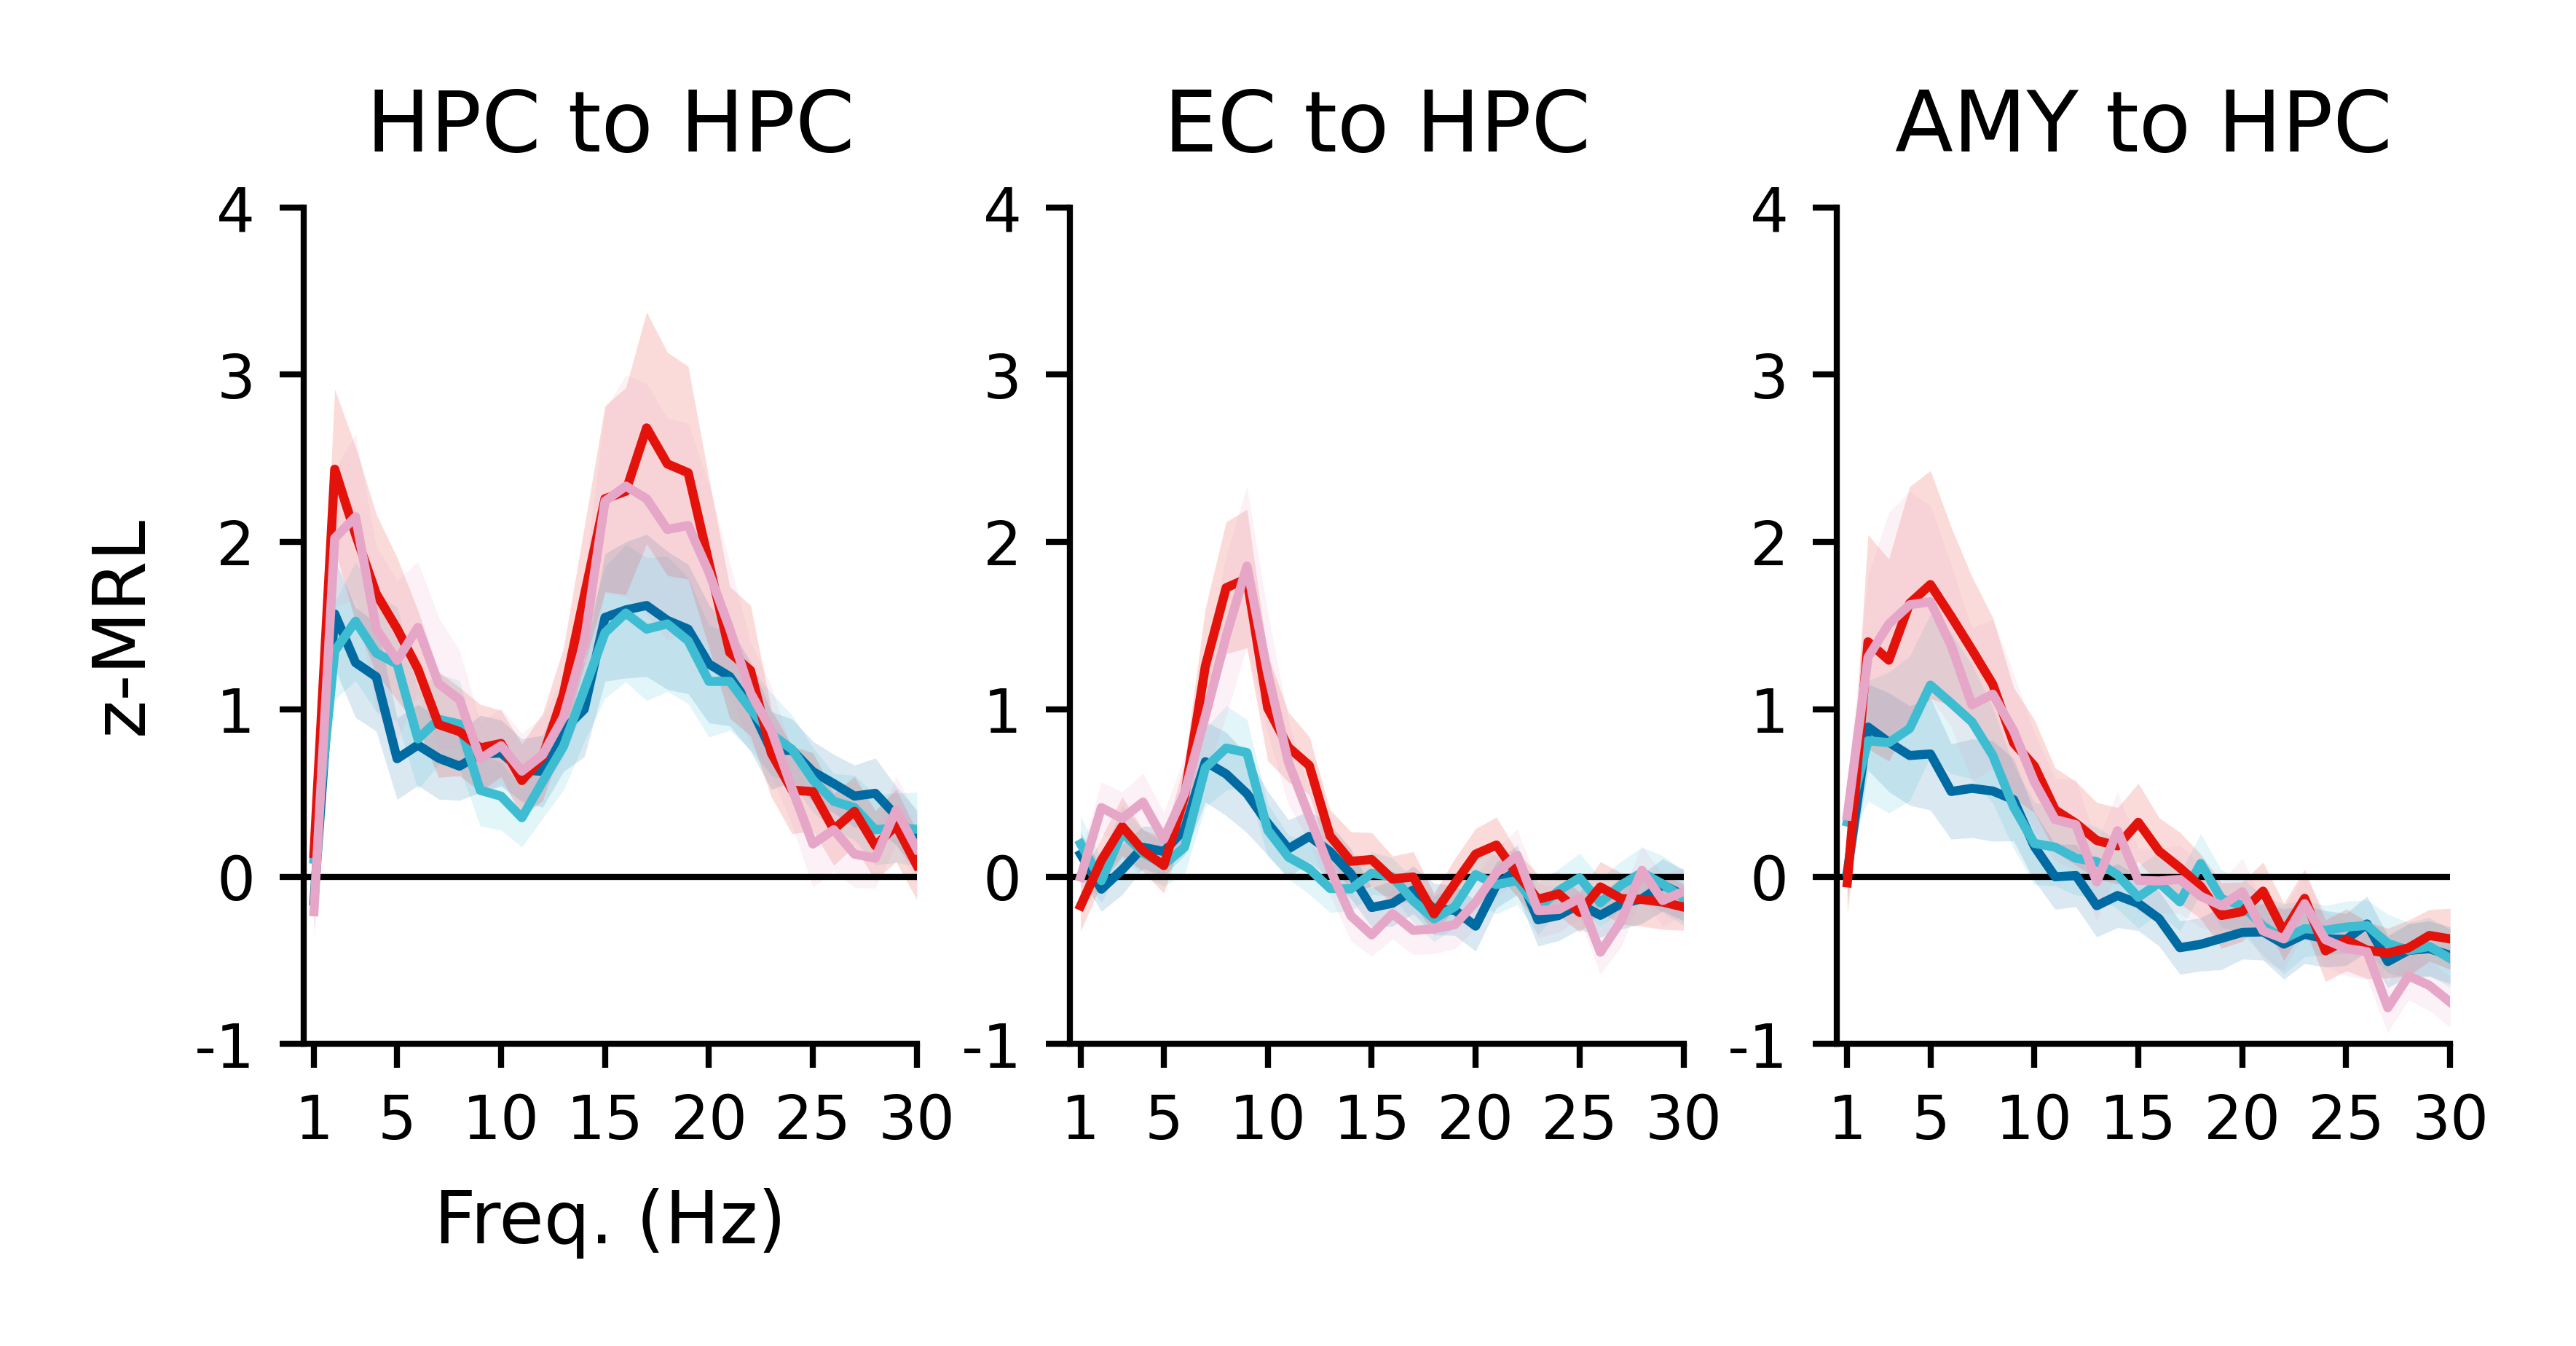

In [ ]:
roi_pairs = [
    ('HPC', 'HPC'),
#     ('OFC', 'OFC'),
#     ('OFC', 'HPC'),
#     ('AMY', 'AMY'),
#     ('EC', 'EC'),
    ('EC', 'HPC'),
    ('AMY', 'HPC'),
]
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2]*0.4)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
spine_lw = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0.5, 30]
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (-1, 4)
yticks = [-1, 0, 1, 2, 3, 4]
yticklabs = yticks
lw = 0.75
linecolor = {'Delay1': co['b'],
             'Delay2': co['c'],
             'Encoding': co['r'],
             'Retrieval': co['p2']}
linewidths = {'local': 1,
              'distal': 1}
plot_hline = True
hline = 0
hline_color = co['k']
verbose = False

# ------------------------------------
# Plot the data.
plt.close()
fig, ax = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for (iax, (unit_roi, lfp_roi)) in enumerate(roi_pairs):
    _ax = ax[iax]
    
    if plot_hline:
        _ax.axhline(hline, color=hline_color, lw=spine_lw)

    for mask in keep_masks:
        _means = np.array(zmrls.at[(unit_roi, lfp_roi, mask), 'mean_zmrls'])
        _sems = np.array(zmrls.at[(unit_roi, lfp_roi, mask), 'sem_zmrls'])
        _ax.fill_between(xvals,
                         _means + _sems,
                         _means - _sems,
                         alpha=0.15, lw=0, color=linecolor[mask])
        _ax.plot(xvals, _means, lw=lw, color=linecolor[mask])
        
        if verbose:
            print('{} to {}, {}: {} neurons, {} subjs, min={:.2f}, max={:.2f}'
                  .format(unit_roi,
                          lfp_roi,
                          mask,
                          zmrls.at[(unit_roi, lfp_roi, mask), 'n_units'],
                          zmrls.at[(unit_roi, lfp_roi, mask), 'n_subjs'],
                          np.nanmin(_means - _sems),
                          np.nanmax(_means + _sems)))

    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
    _ax.set_xlim(xlim)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticks, fontsize=font['tick'])
    if iax == 0:
        _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('z-MRL', fontsize=font['label'], labelpad=labelpad)
    _ax.set_title('{} to {}'.format(unit_roi, lfp_roi), fontsize=font['fig'], y=0.98)

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'phase_lock_freqs', 
                       'zMRL-by-freq_{}-{}Hz-sig-fdr-phase-locked_{}-neurons.pdf'
                       .format(low, high,
                               '_'.join(['{}{}-{}'
                                         .format(zmrls.at[(unit_roi, lfp_roi, band), 'n_units'],
                                                 unit_roi,
                                                 'local' if (unit_roi==lfp_roi) else lfp_roi)
                                         for (unit_roi, lfp_roi) in roi_pairs])))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

HPC to HPC,    Delay1: 5 subjs, 46 neurons, min=-0.18, max=2.24
HPC to HPC,    Delay2: 5 subjs, 46 neurons, min=-0.04, max=2.46
HPC to HPC,  Encoding: 5 subjs, 46 neurons, min=-0.51, max=4.05
HPC to HPC, Retrieval: 5 subjs, 46 neurons, min=-0.48, max=3.55
MTL to MTL,    Delay1: 6 subjs, 89 neurons, min=-0.50, max=2.22
MTL to MTL,    Delay2: 6 subjs, 89 neurons, min=-0.35, max=2.92
MTL to MTL,  Encoding: 6 subjs, 89 neurons, min=-0.56, max=3.50
MTL to MTL, Retrieval: 6 subjs, 89 neurons, min=-0.54, max=2.91
CTX to CTX,    Delay1: 6 subjs, 83 neurons, min=-0.50, max=3.47
CTX to CTX,    Delay2: 6 subjs, 83 neurons, min=-0.42, max=3.77
CTX to CTX,  Encoding: 6 subjs, 83 neurons, min=-0.65, max=4.03
CTX to CTX, Retrieval: 6 subjs, 83 neurons, min=-0.44, max=4.40
MTL to HPC,    Delay1: 6 subjs, 85 neurons, min=-0.64, max=1.19
MTL to HPC,    Delay2: 6 subjs, 85 neurons, min=-0.59, max=1.88
MTL to HPC,  Encoding: 6 subjs, 85 neurons, min=-0.70, max=2.91
MTL to HPC, Retrieval: 6 subjs, 85 neuro

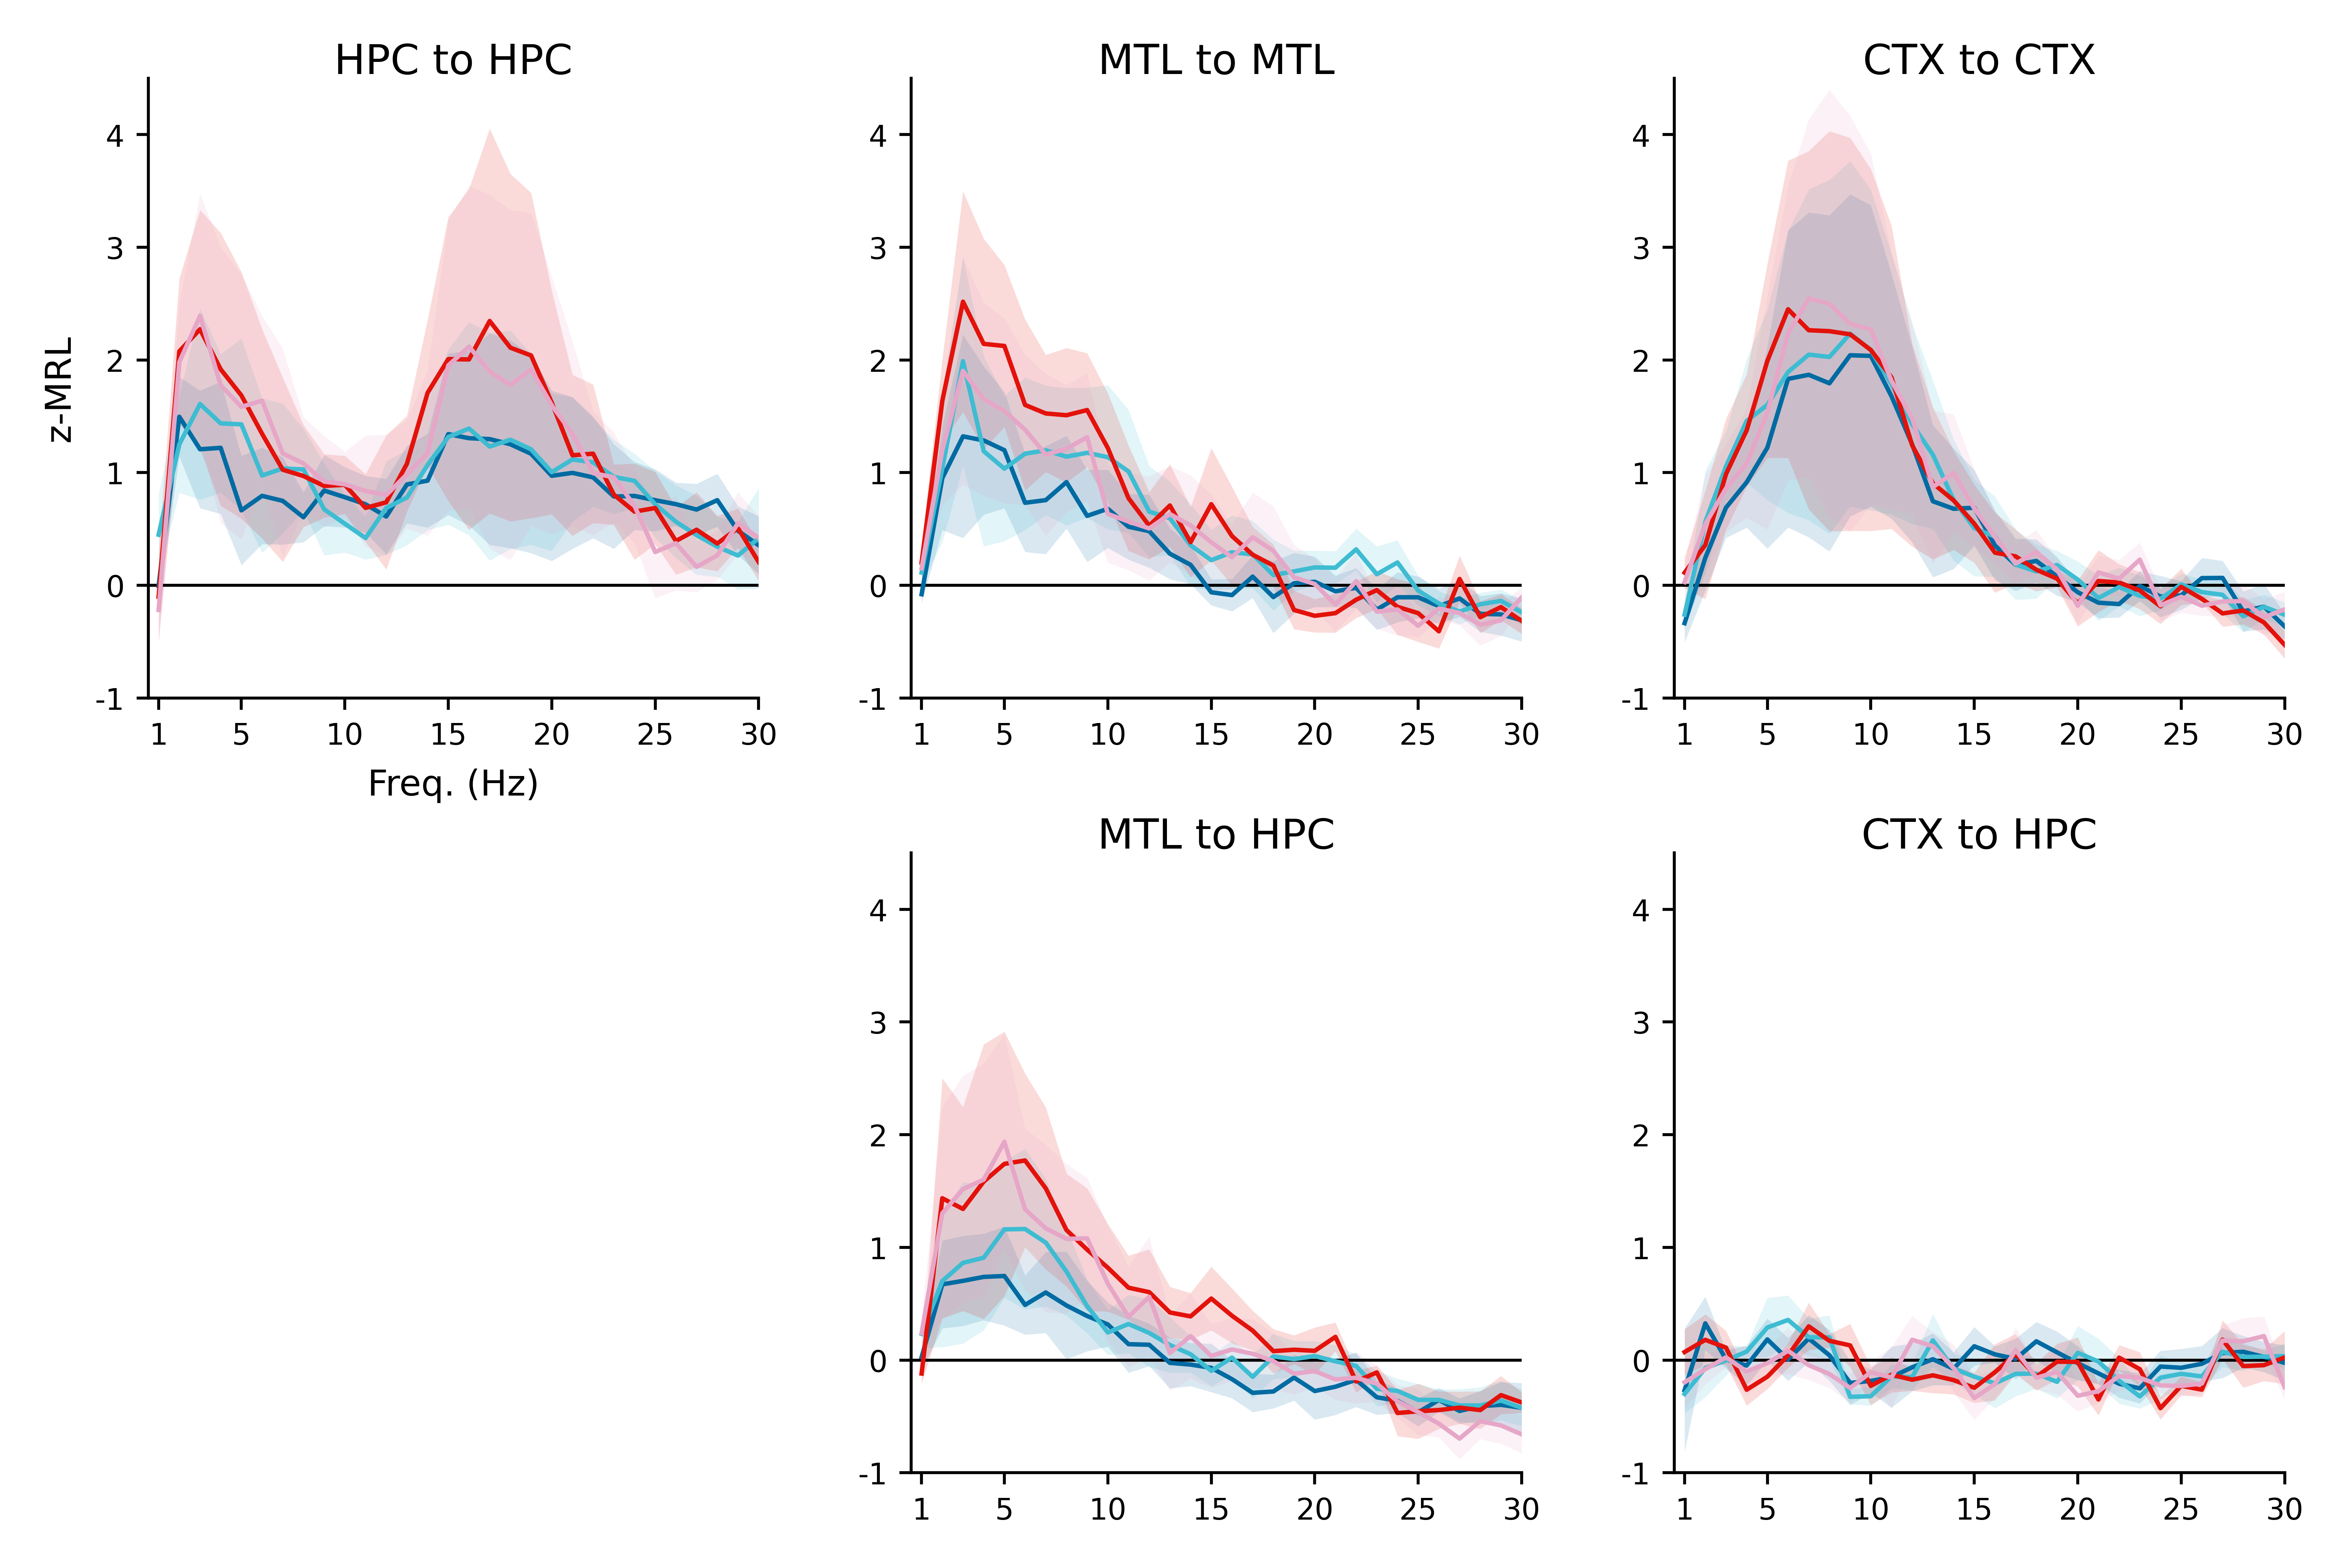

In [ ]:
roi_pairs = [
    ('HPC', 'HPC'),
    ('MTL', 'MTL'),
    ('CTX', 'CTX'),
    ('', ''),
    ('MTL', 'HPC'),
    ('CTX', 'HPC'),
]
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
savefig = 0
overwrite = 0
figsize = (colws[3], colws[3]*0.67)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
spine_lw = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0.5, 30]
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (-1, 4.5)
yticks = [-1, 0, 1, 2, 3, 4]
yticklabs = yticks
lw = 0.75
linecolor = {'Delay1': co['b'],
             'Delay2': co['c'],
             'Encoding': co['r'],
             'Retrieval': co['p2']}
linewidths = {'local': 1,
              'distal': 1}
plot_hline = True
hline = 0
hline_color = co['k']
verbose = True

# ------------------------------------
# Plot the data.
plt.close()
fig, ax = plt.subplots(2, 3, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for (iax, (unit_roi, lfp_roi)) in enumerate(roi_pairs):
    _ax = ax[iax]
    if unit_roi == '':
        _ax.axis('off')
        continue
    
    if plot_hline:
        _ax.axhline(hline, color=hline_color, lw=spine_lw)

    for mask in keep_masks:
        _means = np.array(subj_zmrls.at[(unit_roi, lfp_roi, mask), 'mean_zmrls'])
        _sems = np.array(subj_zmrls.at[(unit_roi, lfp_roi, mask), 'sem_zmrls'])
        _ax.fill_between(xvals,
                         _means + _sems,
                         _means - _sems,
                         alpha=0.15, lw=0, color=linecolor[mask])
        _ax.plot(xvals, _means, lw=lw, color=linecolor[mask])
        
        if verbose:
            print('{} to {}, {:>9}: {} subjs, {} neurons, min={:.2f}, max={:.2f}'
                  .format(unit_roi,
                          lfp_roi,
                          mask,
                          subj_zmrls.at[(unit_roi, lfp_roi, mask), 'subjs'],
                          subj_zmrls.at[(unit_roi, lfp_roi, mask), 'units'],
                          np.nanmin(_means - _sems),
                          np.nanmax(_means + _sems)))

    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
    _ax.set_xlim(xlim)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticks, fontsize=font['tick'])
    if iax == 0:
        _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('z-MRL', fontsize=font['label'], labelpad=labelpad)
    _ax.set_title('{} to {}'.format(unit_roi, lfp_roi), fontsize=font['fig'], y=0.95)

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'phase_lock_freqs', 
                       'zMRL-by-freq_{}-{}Hz-sig-fdr-phase-locked_{}-neurons.pdf'
                       .format(low, high,
                               '_'.join(['{}{}-{}'
                                         .format(subj_zmrls.at[(unit_roi, lfp_roi, band), 'units'],
                                                 unit_roi,
                                                 'local' if (unit_roi==lfp_roi) else lfp_roi)
                                         for (unit_roi, lfp_roi) in roi_pairs])))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

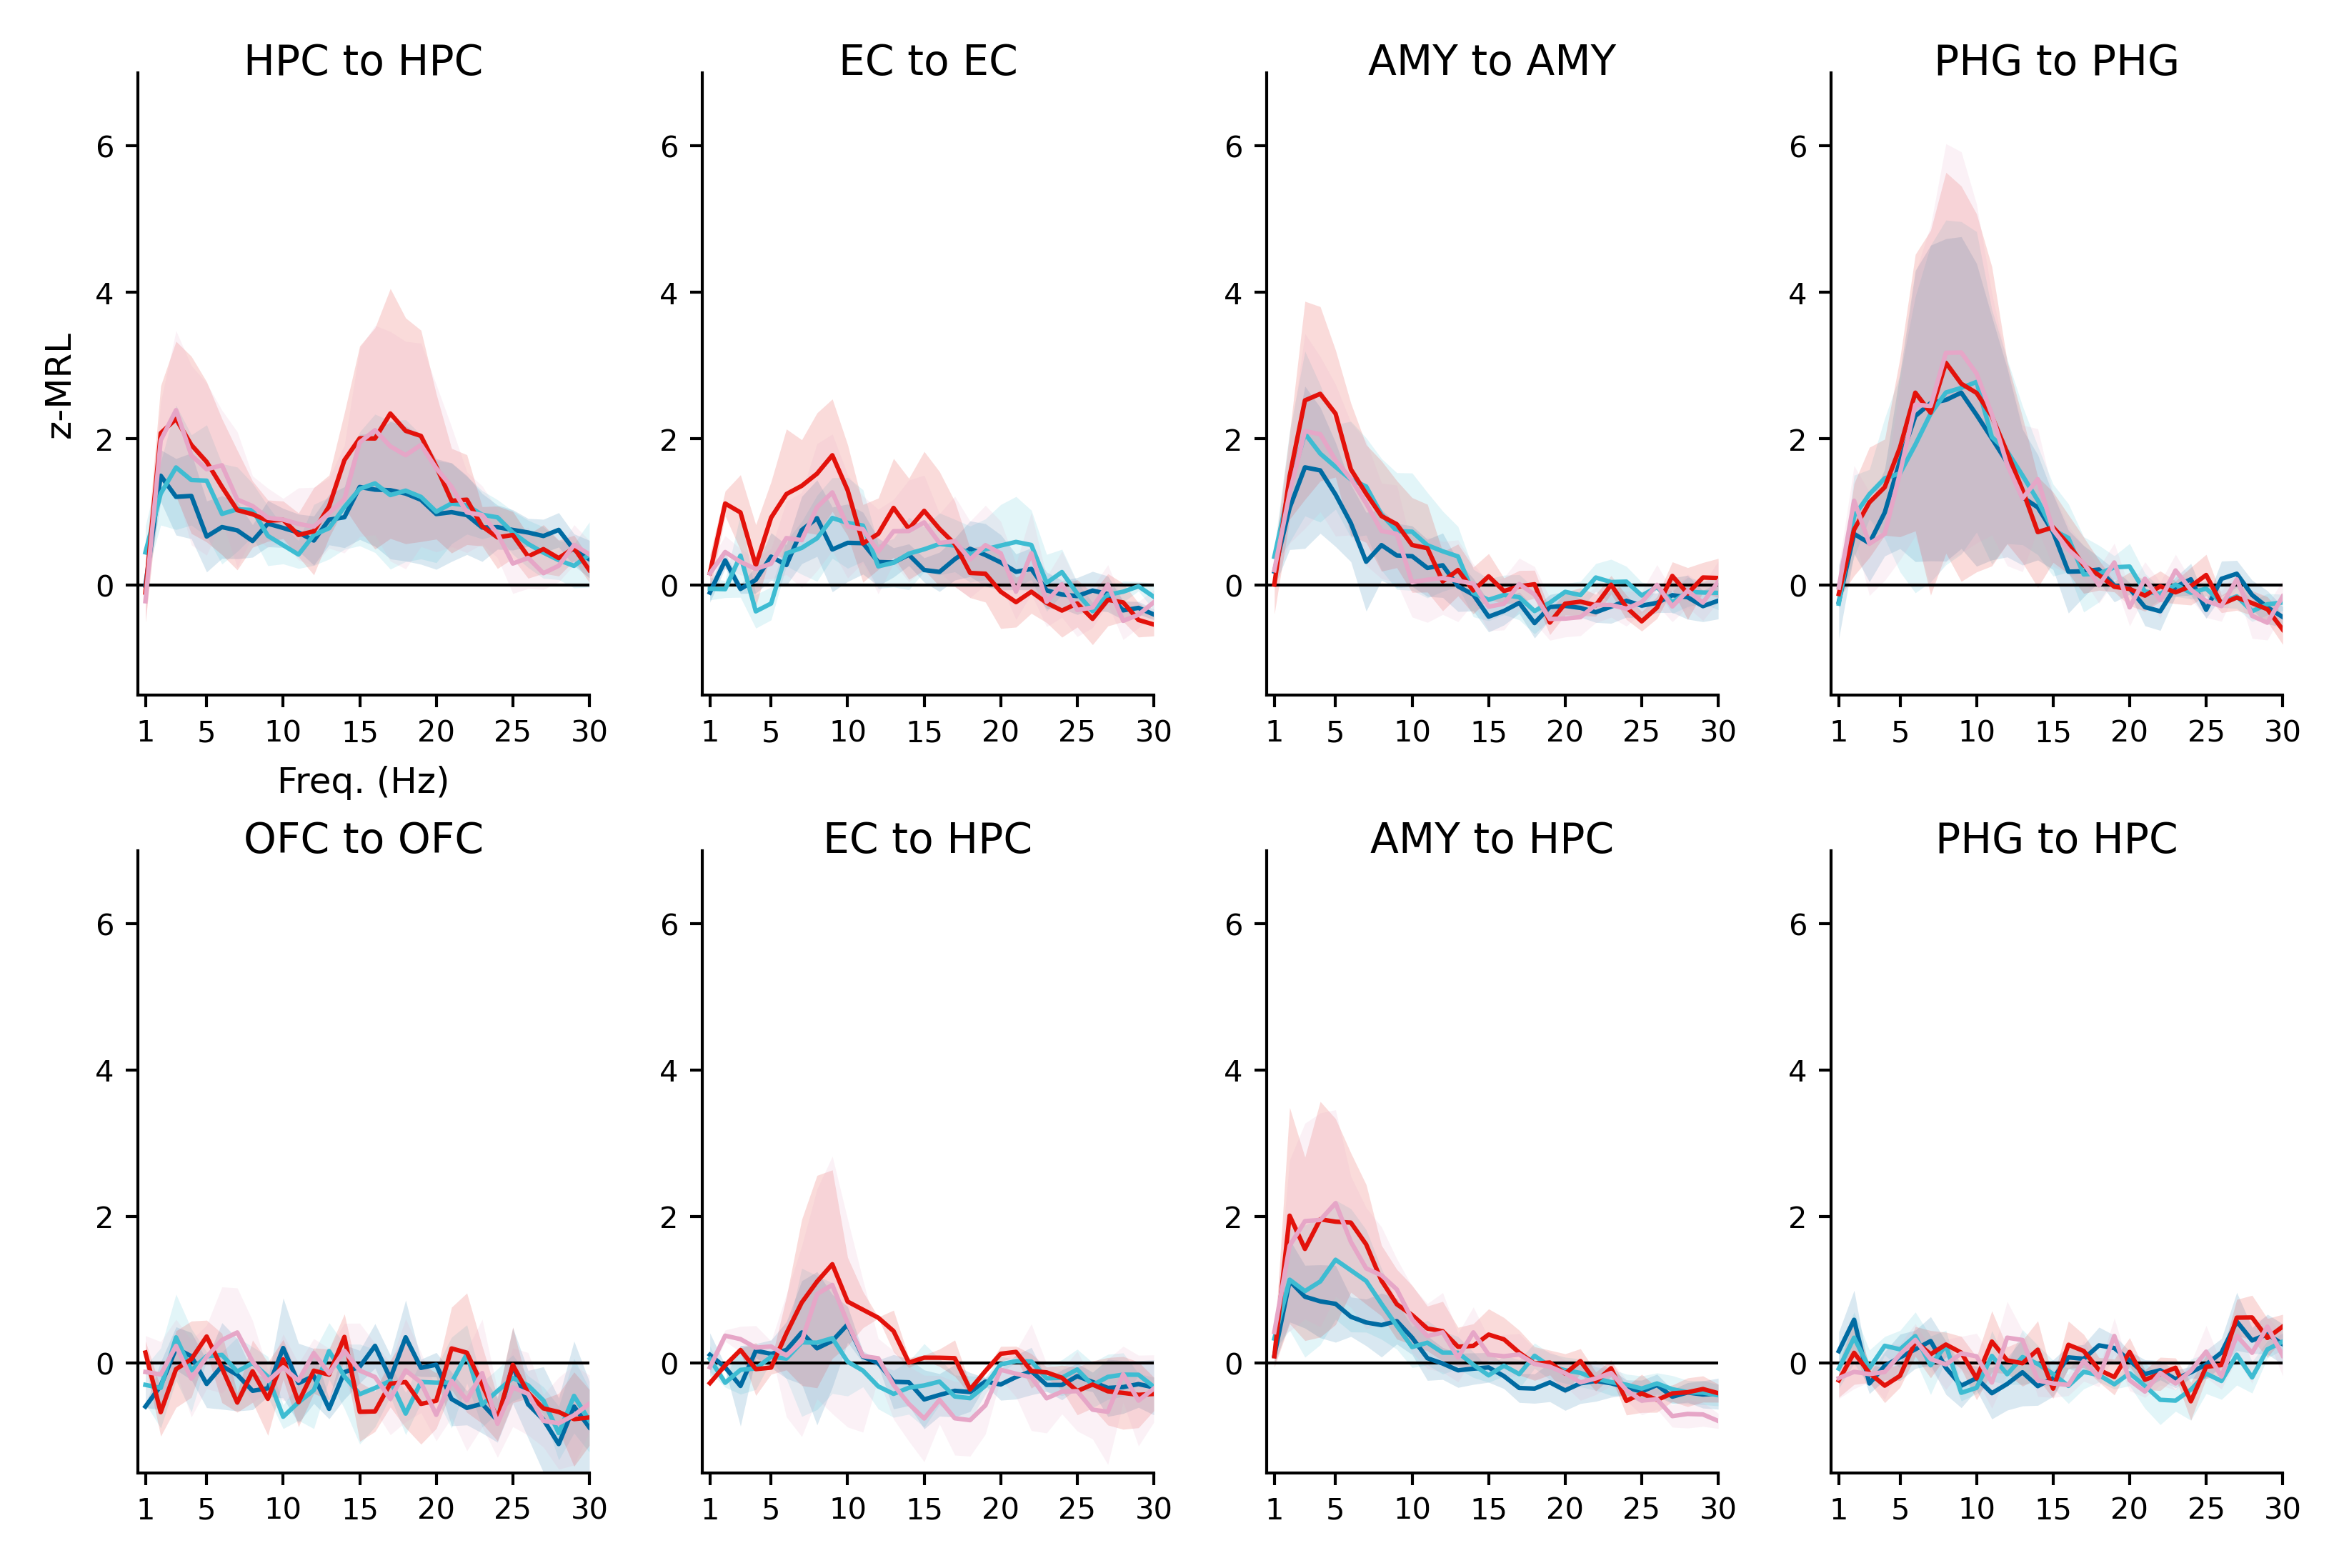

In [106]:
roi_pairs = [
    ('HPC', 'HPC'),
    ('EC', 'EC'),
    ('AMY', 'AMY'),
    ('PHG', 'PHG'),
    ('OFC', 'OFC'),
    ('EC', 'HPC'),
    ('AMY', 'HPC'),
    ('PHG', 'HPC'),
]
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
savefig = 0
overwrite = 0
figsize = (colws[3], colws[3] * 0.67)
dpi = 600
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
spine_lw = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0.5, 30]
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (-1.5, 7)
yticks = [0, 2, 4, 6]
yticklabs = yticks
lw = 0.75
linecolor = {'Delay1': co['b'],
             'Delay2': co['c'],
             'Encoding': co['r'],
             'Retrieval': co['p2']}
linewidths = {'local': 1,
              'distal': 1}
plot_hline = True
hline = 0
hline_color = co['k']
verbose = False

# ------------------------------------
# Plot the data.
plt.close('all')
fig, ax = plt.subplots(2, 4, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for (iax, (unit_roi, lfp_roi)) in enumerate(roi_pairs):
    _ax = ax[iax]
    
    if plot_hline:
        _ax.axhline(hline, color=hline_color, lw=spine_lw)

    for mask in keep_masks:
        _means = np.array(subj_zmrls.at[(unit_roi, lfp_roi, mask), 'mean_zmrls'])
        _sems = np.array(subj_zmrls.at[(unit_roi, lfp_roi, mask), 'sem_zmrls'])
        _ax.fill_between(xvals,
                         _means + _sems,
                         _means - _sems,
                         alpha=0.15, lw=0, color=linecolor[mask])
        _ax.plot(xvals, _means, lw=lw, color=linecolor[mask])
        
        if verbose:
            print('{} to {}, {}: {} neurons, {} subjs, min={:.2f}, max={:.2f}'
                  .format(unit_roi,
                          lfp_roi,
                          mask,
                          subj_zmrls.at[(unit_roi, lfp_roi, mask), 'units'],
                          subj_zmrls.at[(unit_roi, lfp_roi, mask), 'subjs'],
                          np.nanmin(_means - _sems),
                          np.nanmax(_means + _sems)))

    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
    _ax.set_xlim(xlim)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticks, fontsize=font['tick'])
    if iax == 0:
        _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('z-MRL', fontsize=font['label'], labelpad=labelpad)
    _ax.set_title('{} to {}'.format(unit_roi, lfp_roi), fontsize=font['fig'], y=0.94)

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'phase_lock_freqs', 
                       'zMRL-by-freq_{}-{}Hz-sig-fdr-phase-locked_{}-neurons.pdf'
                       .format(low, high,
                               '_'.join(['{}{}-{}'
                                         .format(subj_zmrls.at[(unit_roi, lfp_roi, band), 'units'],
                                                 unit_roi,
                                                 'local' if (unit_roi==lfp_roi) else lfp_roi)
                                         for (unit_roi, lfp_roi) in roi_pairs])))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

In [146]:
df = pd.concat((pl_mrls.query(qry_nav).groupby('subj_sess_unit')['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0)),
                pl_mrls.query(qry_delay).groupby('subj_sess_unit')['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))),
               axis=1)
df.columns = ['z_mrls_nav', 'z_mrls_delay']
# df['z_mrls_nav_sub_delay'] = df.apply(lambda x: list(np.array(x['z_mrls_nav']) - np.array(x['z_mrls_delay'])), axis=0)
df['z_mrls_nav_sub_delay'] = [list(nav - delay) for (nav, delay) in zip(df['z_mrls_nav'].tolist(), df['z_mrls_delay'].tolist())]
df.shape

/tmp/ipykernel_105874/1856241082.py:1: RuntimeWarning: Mean of empty slice
  df = pd.concat((pl_mrls.query(qry_nav).groupby('subj_sess_unit')['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0)),
/tmp/ipykernel_105874/1856241082.py:2: RuntimeWarning: Mean of empty slice
  pl_mrls.query(qry_delay).groupby('subj_sess_unit')['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))),


(87, 3)

In [147]:
qry_nav = ("(unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}') & (mask=={})"
           .format(unit_roi, lfp_roi, ['Encoding', 'Retrieval']))
qry_delay = ("(unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}') & (mask=={})"
             .format(unit_roi, lfp_roi, ['Delay1', 'Delay2']))
df = pd.concat((pl_mrls.query(qry_nav).groupby('subj_sess_unit')['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0)),
                pl_mrls.query(qry_delay).groupby('subj_sess_unit')['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))),
               axis=1)
df.columns = ['z_mrls_nav', 'z_mrls_delay']
df['z_mrls_nav_sub_delay'] = [list(nav - delay) for (nav, delay) in zip(df['z_mrls_nav'].tolist(), df['z_mrls_delay'].tolist())]

/tmp/ipykernel_105874/1410209381.py:5: RuntimeWarning: Mean of empty slice
  df = pd.concat((pl_mrls.query(qry_nav).groupby('subj_sess_unit')['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0)),
/tmp/ipykernel_105874/1410209381.py:6: RuntimeWarning: Mean of empty slice
  pl_mrls.query(qry_delay).groupby('subj_sess_unit')['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))),


In [7]:
keep_rois = gen_rois2
n_units = (pl_mrls
           .groupby(['unit_roi_gen2', 'lfp_roi_gen2'])
           ['subj_sess_unit'].apply(lambda x: len(np.unique(x))))
n_pl_units = (pl_mrls
              .query("(sig_fdr==True)")
              .groupby(['unit_roi_gen2', 'lfp_roi_gen2'])
              ['subj_sess_unit'].apply(lambda x: len(np.unique(x))))

warnings.filterwarnings('ignore')
zmrl_diffs = []
for unit_roi in keep_rois:
    for lfp_roi in keep_rois:
        qry_nav = ("(expmt=='goldmine') & (unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}') & (mask=={})"
                   .format(unit_roi, lfp_roi, ['Encoding', 'Retrieval']))
        qry_delay = ("(expmt=='goldmine') & (unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}') & (mask=={})"
                     .format(unit_roi, lfp_roi, ['Delay1', 'Delay2']))
        df = pd.concat((pl_mrls.query(qry_nav).groupby('subj_sess_unit')['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0)),
                        pl_mrls.query(qry_delay).groupby('subj_sess_unit')['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))),
                       axis=1)
        df.columns = ['z_mrls_nav', 'z_mrls_delay']
        df['z_mrls_nav_sub_delay'] = [list(nav - delay) for (nav, delay) in zip(df['z_mrls_nav'].tolist(), df['z_mrls_delay'].tolist())]
        
        _zmrl_diffs = np.array(df['z_mrls_nav_sub_delay'].tolist())
        

        dat_nav = np.array(pl_mrls.query(qry_nav)
                           .groupby(['subj_sess_unit'])
                           ['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))
                           .tolist())
        dat_delay = np.array(pl_mrls.query(qry_delay)
                           .groupby(['subj_sess_unit'])
                           ['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))
                           .tolist())
        
        if len(_zmrl_diffs) > 1:
            _n_subjs = pl_mrls.query(qry)['subj'].nunique()
            _n_units = _zmrl_diffs.shape[0]
            pct_units = 100 * (_n_units/n_units[(unit_roi, lfp_roi)])
            pct_pl_units = 100 * (_n_units/n_pl_units[(unit_roi, lfp_roi)])

            _mean_zmrl_diffs = np.nanmean(_zmrl_diffs, axis=0).tolist()
            _sem_zmrl_diffs = stats.sem(_zmrl_diffs, axis=0, nan_policy='omit').tolist()
            zmrl_diffs.append([unit_roi, lfp_roi, _n_subjs, _n_units,
                               pct_units, pct_pl_units, _mean_zmrl_diffs, _sem_zmrl_diffs, _zmrl_diffs.tolist()])
            
cols = ['unit_roi', 'lfp_roi', 'subjs', 'units',
        'pct_units', 'pct_pl_units', 'mean_zmrls', 'sem_zmrls', 'zmrls']
zmrl_diffs = pd.DataFrame(zmrl_diffs, columns=cols).set_index(['unit_roi', 'lfp_roi'])

warnings.resetwarnings()
print('zmrl_diffs: {}'.format(zmrl_diffs.shape))

zmrl_diffs: (5, 7)


In [8]:
zmrl_diffs

subjs  units  pct_units  pct_pl_units  \
unit_roi lfp_roi                                          
HPC      HPC          2     49  14.540059     24.873096   
MTL      HPC          2     85  14.072848     39.906103   
         MTL          2     90  13.196481     28.846154   
CTX      HPC          2     75  13.392857    576.923077   
         CTX          2     87  14.451827     54.716981   

                                                         mean_zmrls  \
unit_roi lfp_roi                                                      
HPC      HPC      [-0.03983309429423281, 0.843205062436638, 0.89...   
MTL      HPC      [-0.09908025603995509, 0.3969921473857969, 0.3...   
         MTL      [0.0950951729908144, 0.4008815934024264, 0.401...   
CTX      HPC      [0.07575879582486629, 0.04970232282796522, -0....   
         CTX      [0.4313867851737548, 0.05414877755051396, 0.11...   

                                                          sem_zmrls  \
unit_roi lfp_roi                                                      
HPC      HPC      [0.1157155011007594, 0.2809999392720757, 0.280...   
MTL      HPC      [0.10884156773237785, 0.19952384634289203, 0.1...   
         MTL      [0.08924022085574618, 0.12338594377335922, 0.1...   
CTX      HPC      [0.1303433182254411, 0.10953936194521433, 0.11...   
         CTX      [0.1320911518717288, 0.13821367793313533, 0.21...   

                                                              zmrls  
unit_roi lfp_roi                                                     
HPC      HPC      [[-0.5257328075164751, -0.10305444042471201, 0...  
MTL      HPC      [[-0.10336504555732928, -1.1853574992675282, 1...  
         MTL      [[0.021660521651545306, 2.509890040798952, 0.8...  
CTX      HPC      [[-1.6412855365334214, 0.06852489310036702, 0....  
         CTX      [[nan, 1.192353966306802, 0.8293497620264045, ...

In [14]:
zmrl_diffs

subjs  units  pct_units  pct_pl_units  \
unit_roi lfp_roi                                          
HPC      HPC          2     49  14.540059     24.873096   
MTL      HPC          2     85  14.072848     39.906103   
         MTL          2     90  13.196481     28.846154   
CTX      HPC          2     75  13.392857    576.923077   
         CTX          2     87  14.451827     54.716981   

                                                         mean_zmrls  \
unit_roi lfp_roi                                                      
HPC      HPC      [-0.03983309429423281, 0.843205062436638, 0.89...   
MTL      HPC      [-0.09908025603995509, 0.3969921473857969, 0.3...   
         MTL      [0.0950951729908144, 0.4008815934024264, 0.401...   
CTX      HPC      [0.07575879582486629, 0.04970232282796522, -0....   
         CTX      [0.4313867851737548, 0.05414877755051396, 0.11...   

                                                          sem_zmrls  \
unit_roi lfp_roi                                                      
HPC      HPC      [0.1157155011007594, 0.2809999392720757, 0.280...   
MTL      HPC      [0.10884156773237785, 0.19952384634289203, 0.1...   
         MTL      [0.08924022085574618, 0.12338594377335922, 0.1...   
CTX      HPC      [0.1303433182254411, 0.10953936194521433, 0.11...   
         CTX      [0.1320911518717288, 0.13821367793313533, 0.21...   

                                                              zmrls  
unit_roi lfp_roi                                                     
HPC      HPC      [[-0.5257328075164751, -0.10305444042471201, 0...  
MTL      HPC      [[-0.10336504555732928, -1.1853574992675282, 1...  
         MTL      [[0.021660521651545306, 2.509890040798952, 0.8...  
CTX      HPC      [[-1.6412855365334214, 0.06852489310036702, 0....  
         CTX      [[nan, 1.192353966306802, 0.8293497620264045, ...

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/zMRL-by-freq_nav-sub-delay_1-30Hz-sig-fdr-phase-locked.pdf


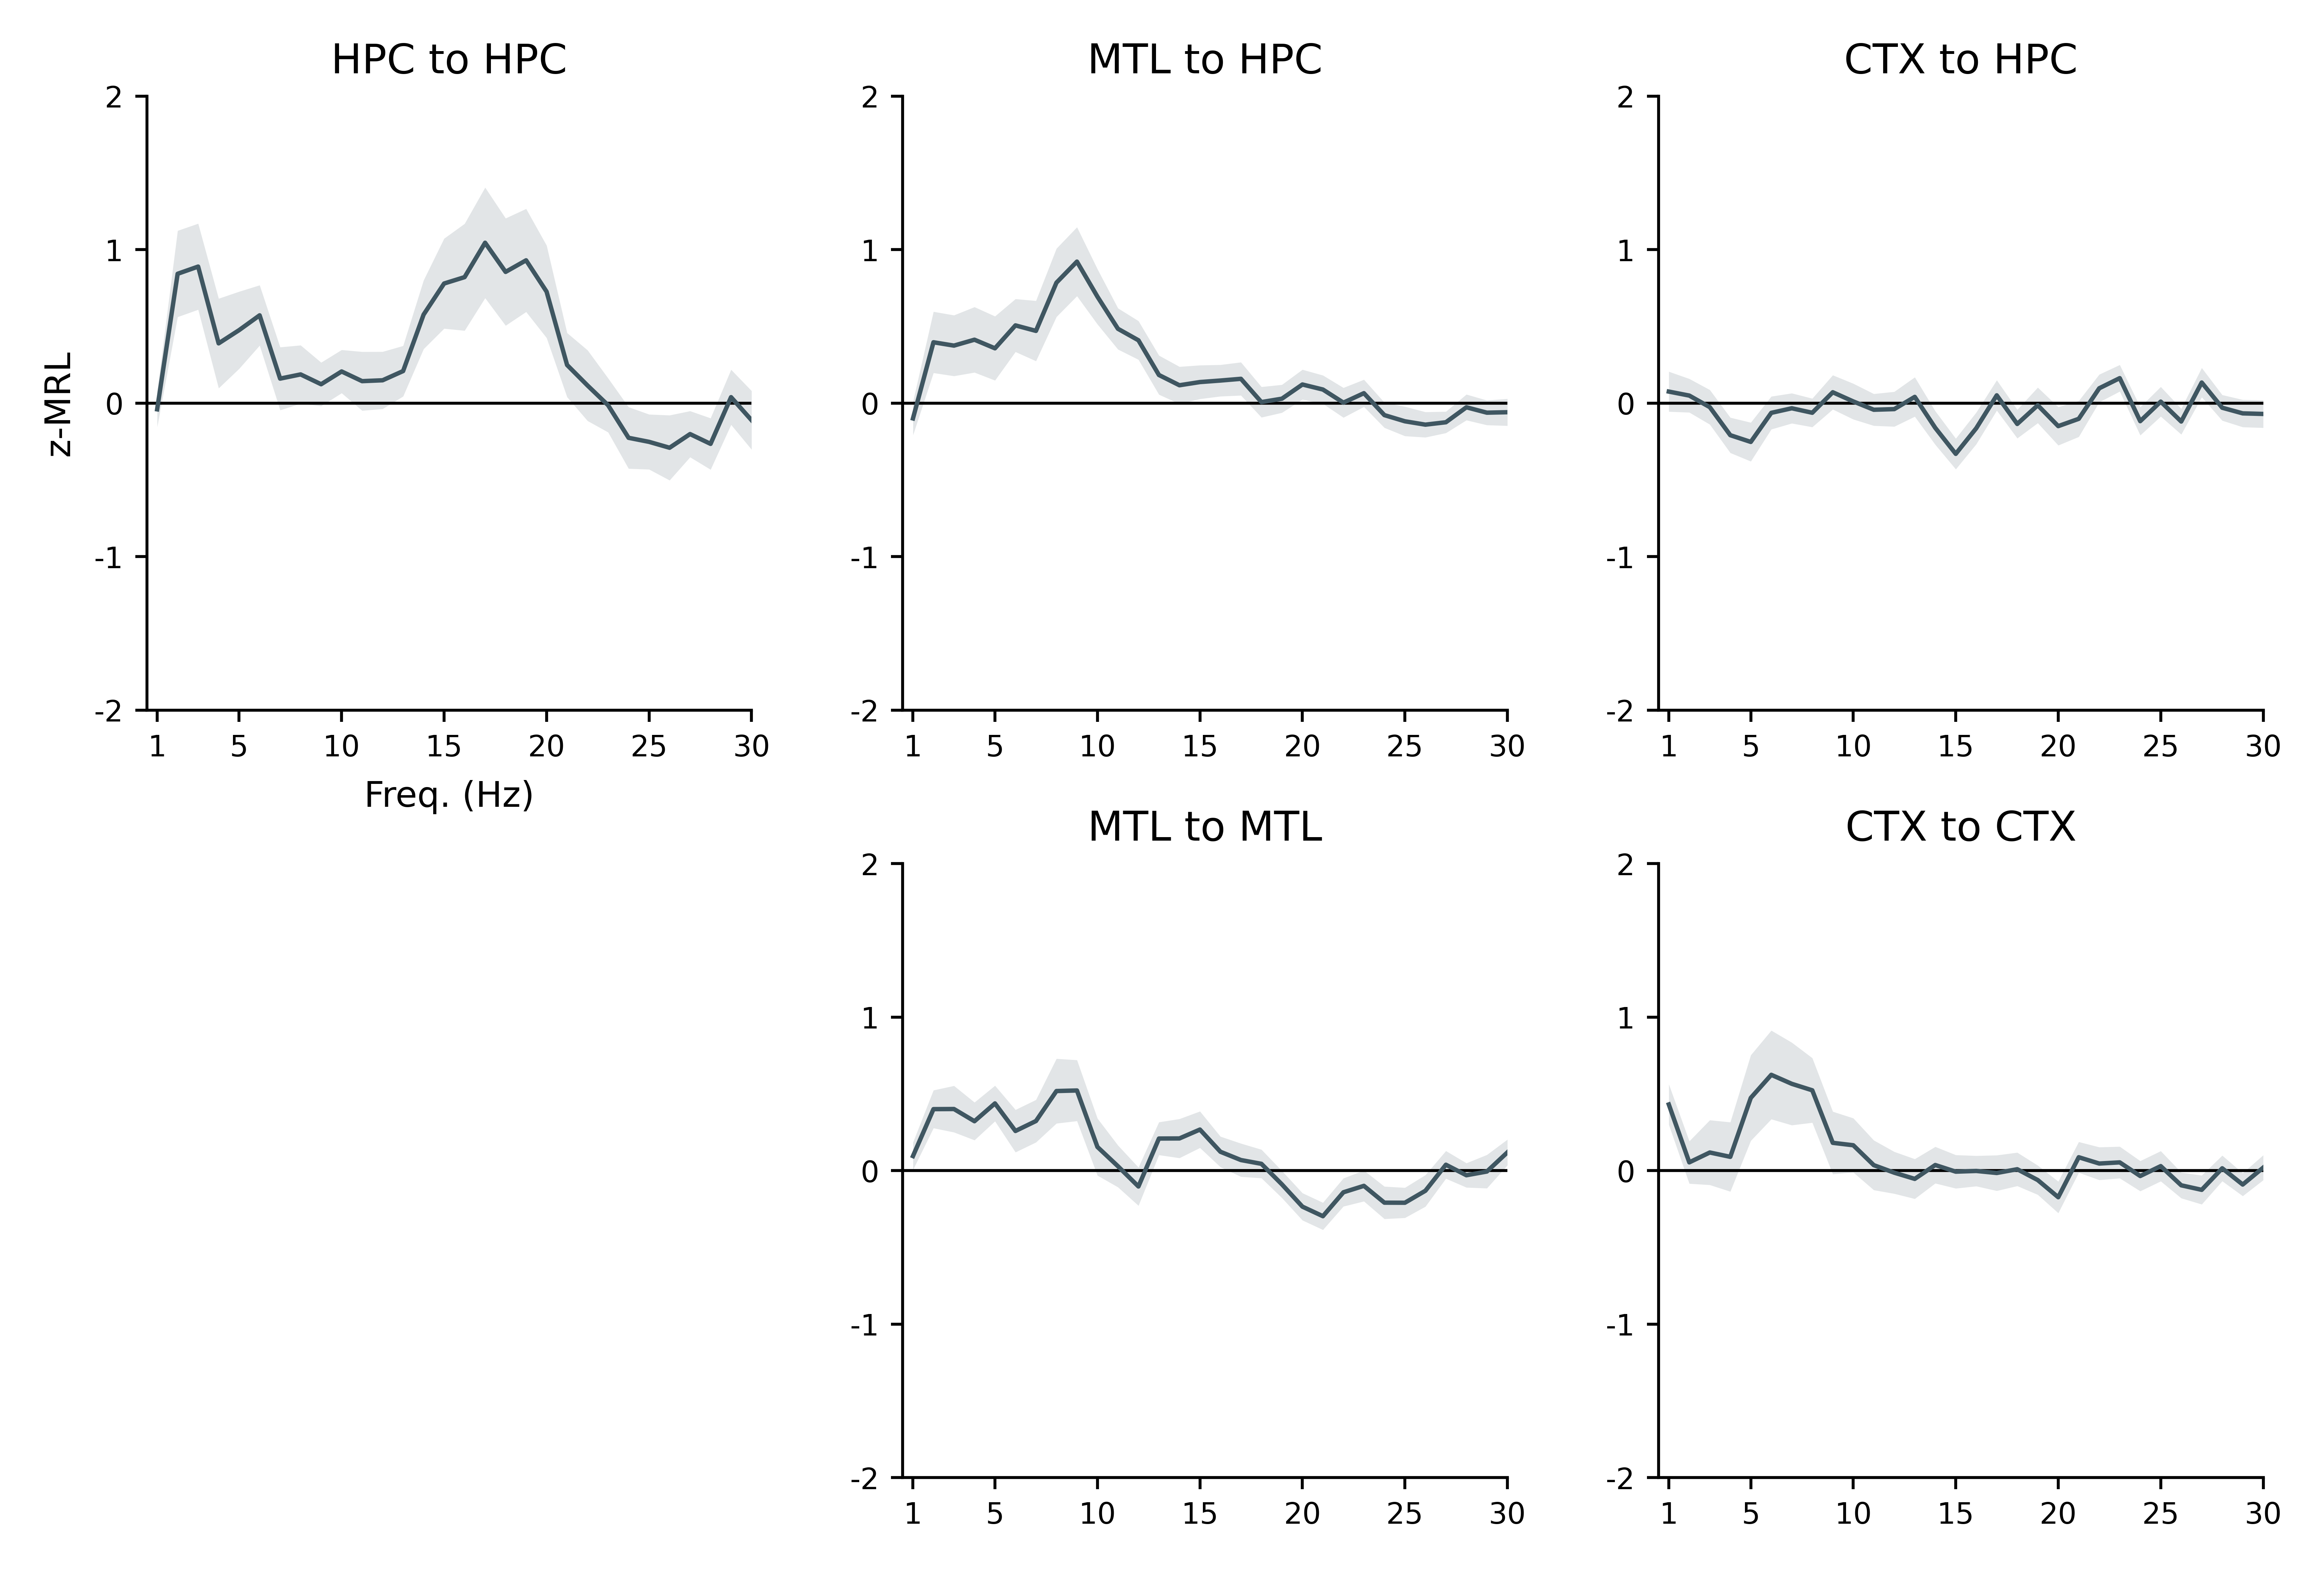

In [17]:
roi_pairs = [
    ('HPC', 'HPC'),
    ('MTL', 'HPC'),
    ('CTX', 'HPC'),
    ('', ''),
    ('MTL', 'MTL'),
    ('CTX', 'CTX'),
]
savefig = 1
overwrite = 0
figsize = (colws[3], colws[3]*0.67)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
spine_lw = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0.5, 30]
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (-2, 2)
yticks = [-2, -1, 0, 1, 2]
yticklabs = yticks
lw = 0.75
linecolor = co['x4']
linewidths = {'local': 1,
              'distal': 1}
plot_hline = True
hline = 0
hline_color = co['k']
verbose = False

# ------------------------------------
# Plot the data.
plt.close()
fig, ax = plt.subplots(2, 3, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for (iax, (unit_roi, lfp_roi)) in enumerate(roi_pairs):
    _ax = ax[iax]
    if iax == 3:
        _ax.axis('off')
        continue
    
    if plot_hline:
        _ax.axhline(hline, color=hline_color, lw=spine_lw)

    _means = np.array(zmrl_diffs.at[(unit_roi, lfp_roi), 'mean_zmrls'])
    _sems = np.array(zmrl_diffs.at[(unit_roi, lfp_roi), 'sem_zmrls'])
    _ax.fill_between(xvals,
                     _means + _sems,
                     _means - _sems,
                     alpha=0.15, lw=0, color=linecolor)
    _ax.plot(xvals, _means, lw=lw, color=linecolor)

    if verbose:
        print('{} to {}: {} neurons, {} subjs, min={:.2f}, max={:.2f}'
              .format(unit_roi,
                      lfp_roi,
                      zmrl_diffs.at[(unit_roi, lfp_roi), 'units'],
                      zmrl_diffs.at[(unit_roi, lfp_roi), 'subjs'],
                      np.nanmin(_means - _sems),
                      np.nanmax(_means + _sems)))

    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
    _ax.set_xlim(xlim)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticks, fontsize=font['tick'])
    if iax == 0:
        _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('z-MRL', fontsize=font['label'], labelpad=labelpad)
    _ax.set_title('{} to {}'.format(unit_roi, lfp_roi), fontsize=font['fig'], y=0.98)

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'goldmine', 
                       'zMRL-by-freq_nav-sub-delay_1-30Hz-sig-fdr-phase-locked.pdf')                       
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

# Heatmaps

In [19]:
keep_masks = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

sig_cells = pl_mrls.query("(mask=={}) & (sig_fdr==True)".format(keep_masks))['subj_sess_unit'].unique().tolist()
sig_cells = (pl_mrls
             .query("(mask=={}) & (subj_sess_unit=={})".format(keep_masks, sig_cells))
             .sort_values(['max_z_mrl'], ascending=[False])
             .drop_duplicates(['subj_sess_unit'])
             .sort_values(['max_z_mrl_freq'])
             ['subj_sess_unit'].tolist())
_pl_mrls = pl_mrls.query("(mask=={}) & (subj_sess_unit=={})".format(keep_masks, sig_cells)).copy()
_pl_mrls.insert(0, 'order', _pl_mrls['subj_sess_unit'].apply(lambda x: sig_cells.index(x)))
_pl_mrls = _pl_mrls.sort_values('order').reset_index(drop=True)

HPC to HPC: 34/49 (69.4%)
HPC to HPC, Delay1: 34 neurons, vmin=-1.7, vmax=10.4
HPC to HPC, Encoding: 34 neurons, vmin=-2.2, vmax=16.0
HPC to HPC, Delay2: 34 neurons, vmin=-1.7, vmax=10.2
HPC to HPC, Retrieval: 34 neurons, vmin=-2.3, vmax=14.8


/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning: NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.convert(mode='P', dither=Image.NONE,
/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  palette=Image.ADAPTIVE, colors=num_colors)


Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/all-sig-fdr-phase-locked_34HPC-neurons-to-HPC_game-state_heatmaps.pdf
MTL to HPC: 35/85 (41.2%)
MTL to HPC, Delay1: 35 neurons, vmin=-2.3, vmax=6.9
MTL to HPC, Encoding: 35 neurons, vmin=-2.2, vmax=11.4
MTL to HPC, Delay2: 35 neurons, vmin=-2.0, vmax=7.4
MTL to HPC, Retrieval: 35 neurons, vmin=-2.5, vmax=12.1


/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning: NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.convert(mode='P', dither=Image.NONE,
/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  palette=Image.ADAPTIVE, colors=num_colors)


Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/all-sig-fdr-phase-locked_35MTL-neurons-to-HPC_game-state_heatmaps.pdf
MTL to MTL: 43/90 (47.8%)
MTL to MTL, Delay1: 43 neurons, vmin=-2.3, vmax=6.8
MTL to MTL, Encoding: 43 neurons, vmin=-2.4, vmax=10.3
MTL to MTL, Delay2: 43 neurons, vmin=-2.1, vmax=8.2
MTL to MTL, Retrieval: 43 neurons, vmin=-2.4, vmax=9.6


/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning: NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.convert(mode='P', dither=Image.NONE,
/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  palette=Image.ADAPTIVE, colors=num_colors)


Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/all-sig-fdr-phase-locked_43MTL-neurons-to-MTL_game-state_heatmaps.pdf
CTX to CTX: 51/87 (58.6%)
CTX to CTX, Delay1: 51 neurons, vmin=-2.2, vmax=12.8
CTX to CTX, Encoding: 51 neurons, vmin=-2.6, vmax=19.4
CTX to CTX, Delay2: 51 neurons, vmin=-2.3, vmax=15.4
CTX to CTX, Retrieval: 51 neurons, vmin=-2.4, vmax=20.3


/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning: NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.convert(mode='P', dither=Image.NONE,
/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  palette=Image.ADAPTIVE, colors=num_colors)


Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/all-sig-fdr-phase-locked_51CTX-neurons-to-CTX_game-state_heatmaps.pdf


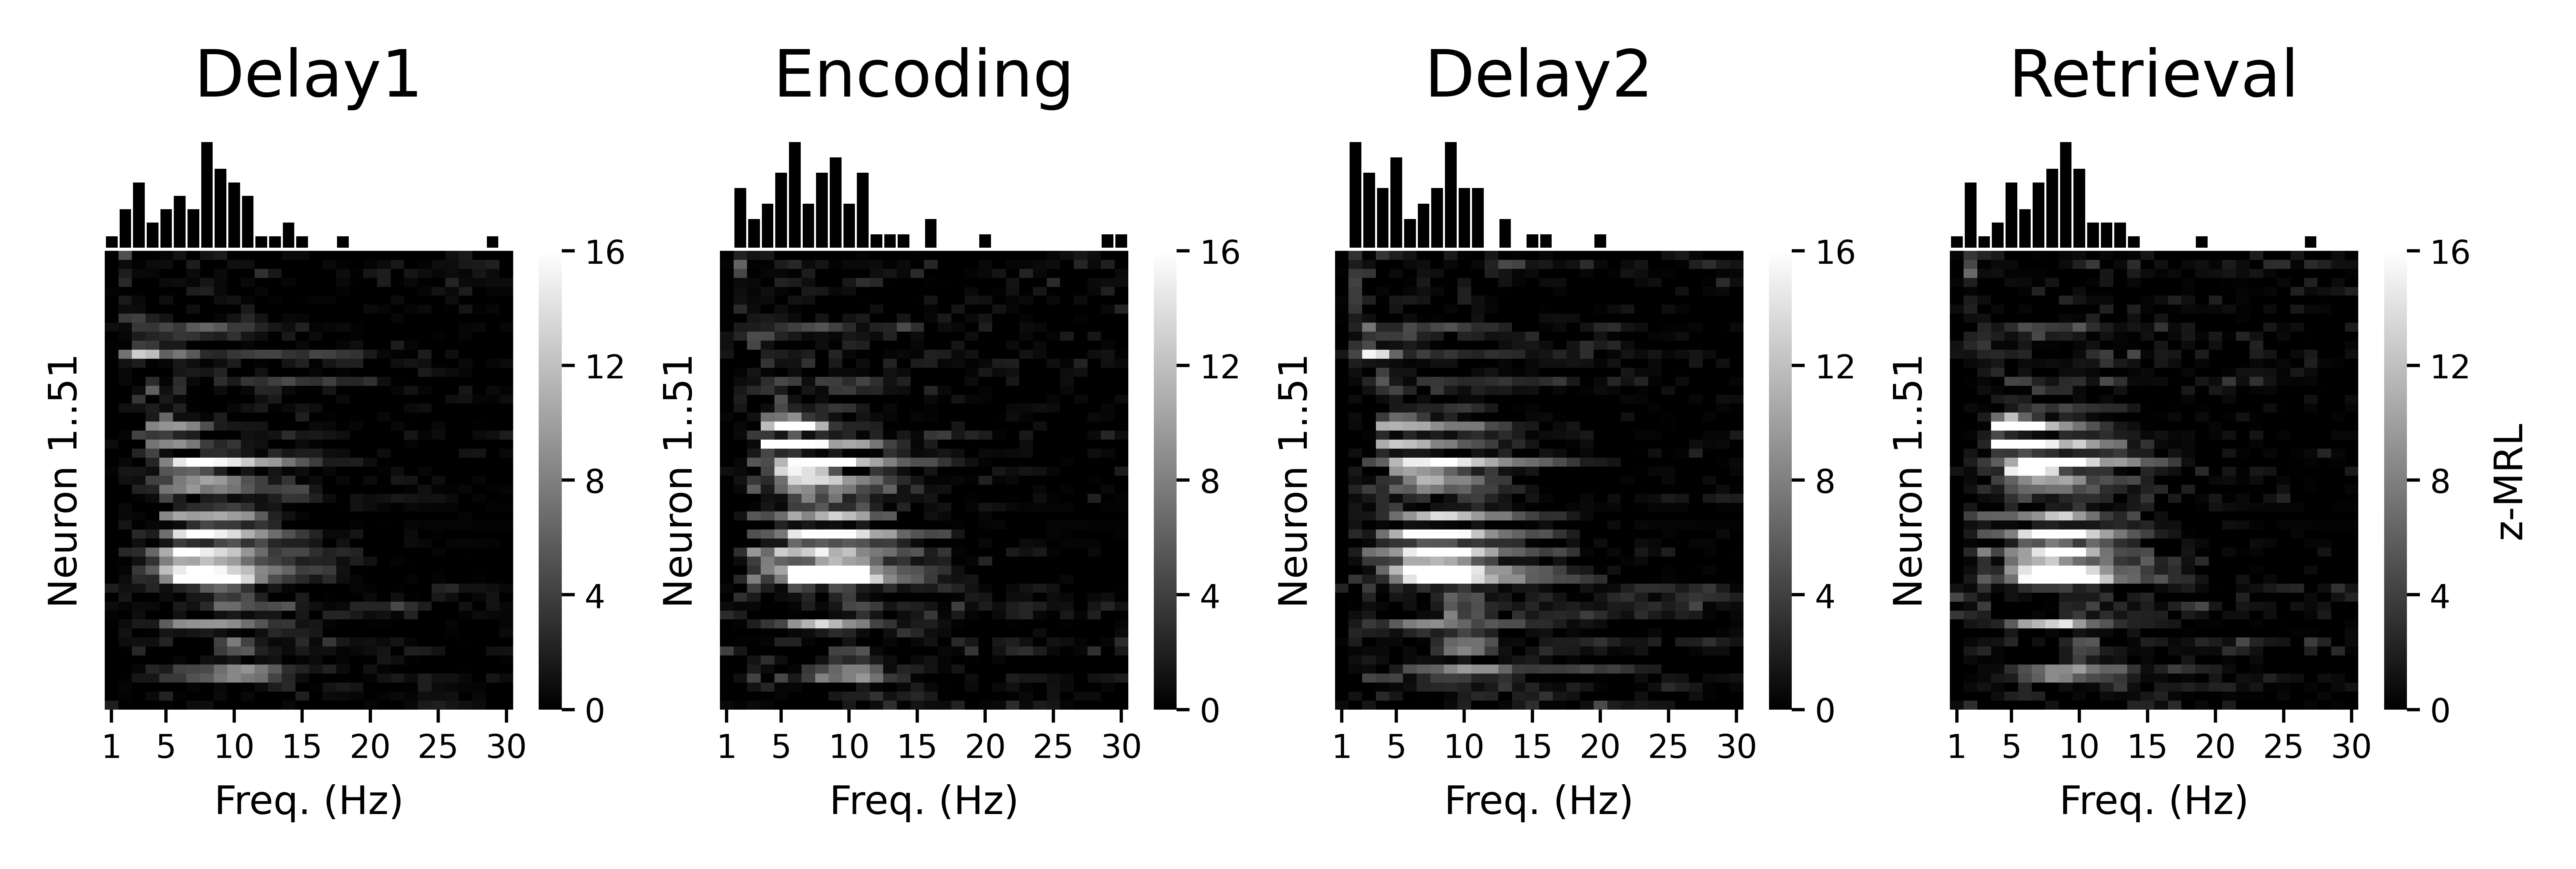

In [45]:
keep_pairs = [
    ('HPC', 'HPC'),
    ('MTL', 'HPC'),
    ('CTX', 'HPC'),
    ('MTL', 'MTL'),
    ('CTX', 'CTX'),
]
keep_masks = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
savefig = 1
overwrite = 1
figsize = (colws[3], colws[3]*0.25) # (50/230)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
labelpad = 3
ticklen = 2
tickpad = 1.5
freqs = np.arange(1, 31)
density = True
hist_lw = 0.3
hist_ec = 'w'
hist_barcolor = 'k'
hist_spinecolor = None
xlim = [1, 30]
xticks = np.array([1, 5, 10, 15, 20, 25, 30]) - 0.5
xticklabs = (xticks + 0.5).astype(int)
cmap = 'binary_r' #'mako'
vmin = 0
vmax = 16
vticks = np.linspace(vmin, vmax, 5).astype(int)
rescale = False
redefine_vmax = True
vmax_thresh = 0.8

# -----------------------
for (unit_roi_gen, lfp_roi_gen) in keep_pairs:
    # Get the data
    _pl_mrls = (pl_mrls
                .query("(unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}') & (mask=={})"
                       .format(unit_roi_gen, lfp_roi_gen, keep_masks))
                .copy())
    sig_cells = _pl_mrls.query("(sig_fdr==True)")['subj_sess_unit'].unique().tolist()
    if len(sig_cells) == 0:
        continue
    n = _pl_mrls['subj_sess_unit'].nunique()
    nsig = len(sig_cells)
    sig_cells = (_pl_mrls
                 .query("(subj_sess_unit=={})".format(sig_cells))
                 .sort_values('max_z_mrl', ascending=False)
                 .drop_duplicates('subj_sess_unit')
                 .sort_values('max_z_mrl_freq')
                 ['subj_sess_unit'].tolist())
    _pl_mrls = _pl_mrls.query("(subj_sess_unit=={})".format(sig_cells)).copy()
    _pl_mrls.insert(0, 'order', _pl_mrls['subj_sess_unit'].apply(lambda x: sig_cells.index(x)))
    _pl_mrls = _pl_mrls.sort_values('order').reset_index(drop=True)
    print('{} to {}: {}/{} ({:.1%})'
          .format(unit_roi_gen, lfp_roi_gen, nsig, n, nsig/n))
    
    # Make the plot
    plt.close('all')
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    grid_shp = [50, 230]
    ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=10, colspan=40),
          plt.subplot2grid(grid_shp, (10, 0), rowspan=40, colspan=50),
          plt.subplot2grid(grid_shp, (0, 60), rowspan=10, colspan=40),
          plt.subplot2grid(grid_shp, (10, 60), rowspan=40, colspan=50),
          plt.subplot2grid(grid_shp, (0, 120), rowspan=10, colspan=40),
          plt.subplot2grid(grid_shp, (10, 120), rowspan=40, colspan=50),
          plt.subplot2grid(grid_shp, (0, 180), rowspan=10, colspan=40),
          plt.subplot2grid(grid_shp, (10, 180), rowspan=40, colspan=50)]
        
    iax = 0
    for mask in keep_masks:
        # Histogram.
        _ax = ax[iax]
        qry = ("(unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}') & (mask=='{}') & (subj_sess_unit=={})"
               .format(unit_roi_gen, lfp_roi_gen, mask, sig_cells))
        _counts = _pl_mrls.query(qry).groupby('max_z_mrl_freq').size()
        hist = np.array([_counts.get(freq, 0) for freq in freqs])
        if density:
            hist = hist / hist.sum()
        _ax.bar(freqs-0.5, hist, width=1, lw=hist_lw, color=hist_barcolor, ec=hist_ec)
        _ax.set_xlim([0, len(freqs)])
        _ax.set_xticks(np.arange(len(freqs))[::2]+0.5)
        _ax.set_xticklabels('')
        _ax.set_xticks([])
        _ax.set_yticks([])
        _ax.set_xlabel('')
        _ax.set_ylabel('')
        for spine in ['left', 'bottom']:
        #     _ax.spines[spine].set_visible(False)
            _ax.spines[spine].set_edgecolor(hist_spinecolor)
        _ax.grid(False)
        _ax.set_title(mask)
        
        # Heatmap.
        iax += 1
        _ax = ax[iax]
        dat = np.array(_pl_mrls.query(qry)['z_mrls'].tolist())
        if rescale:
            dat = ((dat - np.nanmin(dat, axis=1)[:, None]) /
                   (np.nanmax(dat, axis=1)[:, None] - np.nanmin(dat, axis=1)[:, None]))
            vmin = 0
            vmax = 1
            vticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
        elif (vmin is None) or (vmax is None):
            vmin = z_thresh
            if redefine_vmax:
                vmax = np.quantile(np.nanmax(dat, axis=1), vmax_thresh)
            vticks = np.linspace(vmin, vmax, 5).astype(int)

        dat[np.isnan(dat)] = 0
        n_neurons = dat.shape[0]
        print('{} to {}, {}: {} neurons, vmin={:.1f}, vmax={:.1f}'
              .format(unit_roi_gen, lfp_roi_gen, mask, n_neurons,
                      np.quantile(np.nanmin(dat, axis=1), 0.1),
                      np.quantile(np.nanmax(dat, axis=1), 0.9)))

        sns.heatmap(dat, ax=_ax, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True)
        _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
        _ax.set_xlim([0, len(freqs)])
        _ax.set_xticks(xticks)
        _ax.set_xticklabels(xticklabs)
        _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_yticks([])
        _ax.set_ylabel('Neuron 1..{}'.format(n_neurons), fontsize=font['label'], labelpad=labelpad)
        cbar = _ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
        cbar.set_ticks(vticks)
        cbar.set_ticklabels(vticks)
        if iax == len(ax)-1:
            cbar.set_label('z-MRL', fontsize=font['label'], labelpad=labelpad)
        else:
            cbar.set_label('')

        iax += 1
        
    if savefig:
        filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2', 'goldmine',
                           'all-sig-fdr-phase-locked_{}{}-neurons-to-{}_game-state_heatmaps.pdf'
                           .format(n_neurons, unit_roi_gen, lfp_roi_gen))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
            print('Saved {}'.format(filename))
    
fig.show()

HPC to HPC: 34/49 (69.4%)
HPC to HPC, Retrieval: 34 neurons, vmin=-3.0, vmax=6.5
MTL to HPC: 35/85 (41.2%)
MTL to HPC, Retrieval: 35 neurons, vmin=-3.1, vmax=6.5
CTX to HPC: 0/75 (0.0%)
MTL to MTL: 43/90 (47.8%)
MTL to MTL, Retrieval: 43 neurons, vmin=-2.5, vmax=4.4
CTX to CTX: 51/87 (58.6%)
CTX to CTX, Retrieval: 51 neurons, vmin=-3.7, vmax=4.9


/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning: NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.convert(mode='P', dither=Image.NONE,
/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  palette=Image.ADAPTIVE, colors=num_colors)


Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/all-sig-fdr-phase-locked_nav-sub-delay_heatmaps.pdf


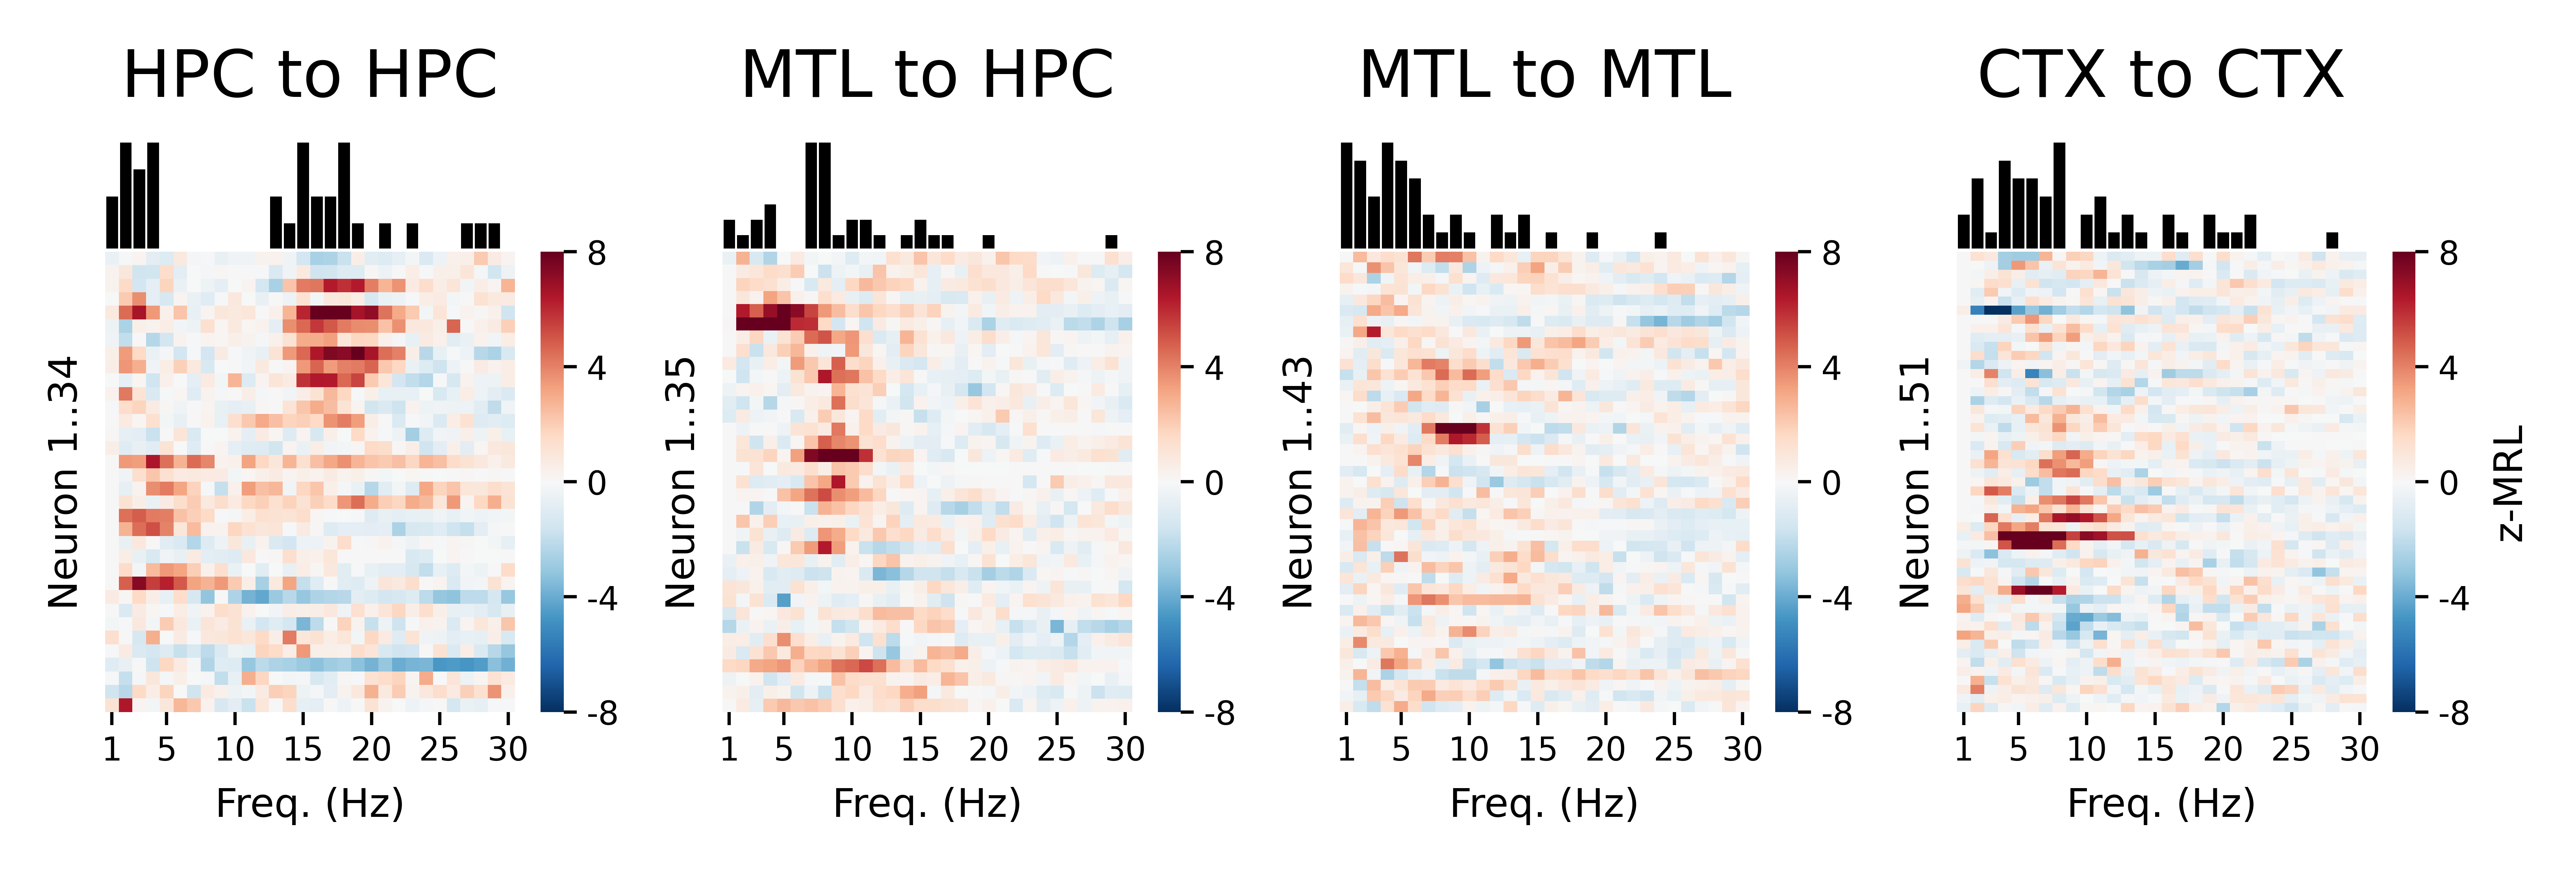

In [33]:
keep_pairs = [
    ('HPC', 'HPC'),
    ('MTL', 'HPC'),
    ('CTX', 'HPC'),
    ('MTL', 'MTL'),
    ('CTX', 'CTX'),
]
keep_masks = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
savefig = 0
overwrite = 1
figsize = (colws[3], colws[3]*0.25) # (50/230)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
labelpad = 3
ticklen = 2
tickpad = 1.5
freqs = np.arange(1, 31)
density = True
hist_lw = 0.3
hist_ec = 'w'
hist_barcolor = 'k'
hist_spinecolor = None
xlim = [1, 30]
xticks = np.array([1, 5, 10, 15, 20, 25, 30]) - 0.5
xticklabs = (xticks + 0.5).astype(int)
cmap = 'RdBu_r' #'binary_r' #'mako'
vmin = -8
vmax = 8
vticks = np.linspace(vmin, vmax, 5).astype(int)
rescale = False
redefine_vmax = True
vmax_thresh = 0.8

# -----------------------
# Make the plot
plt.close('all')
fig = plt.figure(figsize=figsize, dpi=dpi)

grid_shp = [50, 230]
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=10, colspan=40),
      plt.subplot2grid(grid_shp, (10, 0), rowspan=40, colspan=50),
      plt.subplot2grid(grid_shp, (0, 60), rowspan=10, colspan=40),
      plt.subplot2grid(grid_shp, (10, 60), rowspan=40, colspan=50),
      plt.subplot2grid(grid_shp, (0, 120), rowspan=10, colspan=40),
      plt.subplot2grid(grid_shp, (10, 120), rowspan=40, colspan=50),
      plt.subplot2grid(grid_shp, (0, 180), rowspan=10, colspan=40),
      plt.subplot2grid(grid_shp, (10, 180), rowspan=40, colspan=50)]
    
iax_track = 0
for (unit_roi_gen, lfp_roi_gen) in keep_pairs:
    # Get the data
    warnings.filterwarnings('ignore')
    _pl_mrls = (pl_mrls
                .query("(unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}') & (mask=={})"
                       .format(unit_roi_gen, lfp_roi_gen, keep_masks))
                .copy())
    sig_cells = _pl_mrls.query("(sig_fdr==True)")['subj_sess_unit'].unique().tolist()
    n = _pl_mrls['subj_sess_unit'].nunique()
    nsig = len(sig_cells)
    sig_cells = (_pl_mrls
                 .query("(subj_sess_unit=={})".format(sig_cells))
                 .sort_values('max_z_mrl', ascending=False)
                 .drop_duplicates('subj_sess_unit')
                 .sort_values('max_z_mrl_freq')
                 ['subj_sess_unit'].tolist())
    _pl_mrls = _pl_mrls.query("(subj_sess_unit=={})".format(sig_cells)).copy()
    _pl_mrls.insert(0, 'order', _pl_mrls['subj_sess_unit'].apply(lambda x: sig_cells.index(x)))
    _pl_mrls = _pl_mrls.sort_values('order').reset_index(drop=True)
    print('{} to {}: {}/{} ({:.1%})'
          .format(unit_roi_gen, lfp_roi_gen, nsig, n, nsig/n))
    warnings.resetwarnings()
    if len(sig_cells) == 0:
        continue

    # Heatmap
    iax = iax_track + 1
    _ax = ax[iax]
    warnings.filterwarnings('ignore')
    qry_nav = ("(unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}') & (mask=={}) & (subj_sess_unit=={})"
               .format(unit_roi_gen, lfp_roi_gen, ['Encoding', 'Retrieval'], sig_cells))
    qry_delay = ("(unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}') & (mask=={}) & (subj_sess_unit=={})"
                 .format(unit_roi_gen, lfp_roi_gen, ['Delay1', 'Delay2'], sig_cells))
    dat_nav = np.array(_pl_mrls.query(qry_nav)
                       .groupby(['subj_sess_unit'], sort=False)
                       ['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))
                       .tolist())
    dat_delay = np.array(_pl_mrls.query(qry_delay)
                         .groupby(['subj_sess_unit'], sort=False)
                         ['z_mrls'].apply(lambda x: np.nanmean(list(x), axis=0))
                         .tolist())
    dat = dat_nav - dat_delay
    dat[np.isnan(dat)] = 0
    n_neurons = dat.shape[0]
    warnings.resetwarnings()
    if rescale:
        dat = ((dat - np.nanmin(dat, axis=1)[:, None]) /
               (np.nanmax(dat, axis=1)[:, None] - np.nanmin(dat, axis=1)[:, None]))
        vmin = 0
        vmax = 1
        vticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
    elif (vmin is None) or (vmax is None):
        vmin = z_thresh
        if redefine_vmax:
            vmax = np.quantile(np.nanmax(dat, axis=1), vmax_thresh)
        vticks = np.linspace(vmin, vmax, 5).astype(int)
    print('{} to {}, nav - delay: {} neurons, vmin={:.1f}, vmax={:.1f}'
          .format(unit_roi_gen, lfp_roi_gen, n_neurons,
                  np.quantile(np.nanmin(dat, axis=1), 0.1),
                  np.quantile(np.nanmax(dat, axis=1), 0.9)))

    sns.heatmap(dat, ax=_ax, vmin=vmin, vmax=vmax, cmap=cmap, cbar=True)
#     _ax.axvline(x=200, color='k', linewidth=0.75, alpha=1)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
    _ax.set_xlim([0, len(freqs)])
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_xlabel('Freq. (Hz)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_yticks([])
    _ax.set_ylabel('Neuron 1...{}'.format(n_neurons), fontsize=font['label'], labelpad=labelpad)
    cbar = _ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
    cbar.set_ticks(vticks)
    cbar.set_ticklabels(vticks)
    if iax == len(ax)-1:
        cbar.set_label('z-MRL', fontsize=font['label'], labelpad=labelpad)
    else:
        cbar.set_label('')
    
    # Histogram
    iax = iax_track + 0
    _ax = ax[iax]
    _counts = pd.Series(np.nanargmax(dat, axis=1)).value_counts()
    hist = np.array([_counts.get(freq, 0) for freq in freqs])
    if density:
        hist = hist / hist.sum()
    _ax.bar(freqs-0.5, hist, width=1, lw=hist_lw, color=hist_barcolor, ec=hist_ec)
    _ax.set_xlim([0, len(freqs)])
    _ax.set_xticks(np.arange(len(freqs))[::2]+0.5)
    _ax.set_xticklabels('')
    _ax.set_xticks([])
    _ax.set_yticks([])
    _ax.set_xlabel('')
    _ax.set_ylabel('')
    for spine in ['left', 'bottom']:
    #     _ax.spines[spine].set_visible(False)
        _ax.spines[spine].set_edgecolor(hist_spinecolor)
    _ax.grid(False)
    _ax.set_title('{} to {}'.format(unit_roi_gen, lfp_roi_gen))
    
    iax_track += 2
    
if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta/figs2', 'goldmine',
                       'all-sig-fdr-phase-locked_nav-sub-delay_heatmaps.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
    
fig.show()

# Firing rates by game state

In [46]:
spikes.query("(expmt=='goldmine')").groupby('subj_sess').size()

subj_sess
U518_ses0    36
U518_ses1    38
U521_ses0    27
U526_ses0    25
U527_ses0    32
U530_ses0    64
U530_ses1    35
U532_ses0    63
U536_ses0    70
U537_ses0    13
U539_ses0    10
U540_ses0    35
dtype: int64

In [47]:
# Get firing rates for each neuron, in each game state.
save_output = 0
overwrite = 0
keep_masks = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
n_rois = 8
alpha = 0.05
table_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/tables'

# --------------------
timer = Timer()

roi_map = spike_preproc.roi_mapping(n_rois)
roi_map2 = {'AH': 'HPC',
            'MH': 'HPC',
            'PH': 'HPC',
            'A': 'MTL',
            'EC': 'MTL'}

unit_frs = []
unit_fr_diffs = []
for subj_sess, _spikes in spikes.query("(expmt=='goldmine')").groupby('subj_sess'):
    event_times = unit_lfp_comparison.load_event_times(subj_sess, game_states=keep_masks)
    for ii, unit in _spikes.iterrows():
        event_time_spikes = unit_lfp_comparison.load_event_time_spikes(event_times, unit['spike_times'])
        event_time_spikes['fr'] = event_time_spikes.apply(lambda x: (len(x['spike_times'])*1e3) /
                                                                    (x['stop_time']-x['start_time']),
                                                          axis=1)
        event_time_spikes['z_fr'] = stats.zscore(event_time_spikes['fr'])
        fr_by_game_state = (event_time_spikes
                            .groupby('gameState', observed=True)
                            .agg({'fr': np.nanmean,
                                  'z_fr': np.nanmean}))
        for mask in keep_masks:
            unit_frs.append([unit['subj'],
                             unit['subj_sess_unit'],
                             unit['hemroi'],
                             unit['hemroi'][1:],
                             roi_map[unit['hemroi'][1:]],
                             roi_map2.get(unit['hemroi'][1:], 'CTX'),
                             mask,
                             fr_by_game_state.loc[mask, 'fr'],
                             fr_by_game_state.loc[mask, 'z_fr']])
        
        tval, pval = stats.ttest_ind(event_time_spikes.query("(gameState==['Encoding', 'Retrieval'])")['fr'],
                                     event_time_spikes.query("(gameState==['Delay1', 'Delay2'])")['fr'],
                                     equal_var=False)
        unit_fr_diffs.append([unit['subj'],
                              unit['subj_sess_unit'],
                              unit['hemroi'],
                              unit['hemroi'][1:],
                              roi_map[unit['hemroi'][1:]],
                              roi_map2.get(unit['hemroi'][1:], 'CTX'),
                              event_time_spikes.query("(gameState==['Delay1', 'Delay2'])")['fr'].mean(),
                              event_time_spikes.query("(gameState==['Delay1', 'Delay2'])")['z_fr'].mean(),
                              event_time_spikes.query("(gameState==['Encoding', 'Retrieval'])")['fr'].mean(),
                              event_time_spikes.query("(gameState==['Encoding', 'Retrieval'])")['z_fr'].mean(),
                              tval,
                              pval])
            
cols = ['subj', 'subj_sess_unit', 'hemroi', 'roi', 'roi_gen', 'roi_gen2', 'mask', 'fr', 'z_fr']
unit_frs = pd.DataFrame(unit_frs, columns=cols)

cols = ['subj', 'subj_sess_unit', 'hemroi', 'roi', 'roi_gen', 'roi_gen2',
        'fr_delay', 'z_fr_delay', 'fr_nav', 'z_fr_nav', 'tval', 'pval']
unit_fr_diffs = pd.DataFrame(unit_fr_diffs, columns=cols)
unit_fr_diffs.insert(unit_fr_diffs.columns.tolist().index('tval'),
                     'nav_gt_delay',
                     unit_fr_diffs['tval']>0)

# Format regions.
roi_map = spike_preproc.roi_mapping(n_rois)
drop_rois = ['MC', 'PC', 'TP']
hpc_rois = ['AH', 'MH', 'PH']
mtl_rois = ['A', 'EC']
gen_rois = ['HPC', 'EC', 'AMY', 'PHG', 'STG', 'OFC', 'ACC']
gen_rois2 = ['HPC', 'MTL', 'CTX']

# Drop unwanted regions.
unit_frs['roi_gen'] = unit_frs['roi'].apply(lambda x: roi_map[x])
unit_frs = unit_frs.query("(roi_gen!='Other')").reset_index(drop=True)
unit_frs = unit_frs.query("(roi!={})".format(drop_rois)).reset_index(drop=True)

# Reformat regions.
unit_frs['roi_gen'] = unit_frs['roi_gen'].astype(str)
unit_frs.loc[unit_frs['roi_gen']=='CC', 'roi_gen'] = 'ACC'
unit_frs.loc[unit_frs['roi_gen']=='LTC', 'roi_gen'] = 'STG'
unit_frs['roi_gen'] = unit_frs['roi_gen'].astype(pd.CategoricalDtype(gen_rois, ordered=True))
if 'roi_gen2' not in unit_frs.columns:
    unit_frs.insert(unit_frs.columns.tolist().index('roi_gen')+1, 'roi_gen2', '')
unit_frs.loc[np.isin(unit_frs['roi'], hpc_rois), 'roi_gen2'] = 'HPC'
unit_frs.loc[np.isin(unit_frs['roi'], mtl_rois), 'roi_gen2'] = 'MTL'
unit_frs.loc[~np.isin(unit_frs['roi'], hpc_rois + mtl_rois), 'roi_gen2'] = 'CTX'
unit_frs['roi_gen2'] = unit_frs['roi_gen2'].astype(pd.CategoricalDtype(gen_rois2, ordered=True))
unit_frs['mask'] = unit_frs['mask'].astype(pd.CategoricalDtype(keep_masks, ordered=True))

# Drop unwanted regions.
unit_fr_diffs['roi_gen'] = unit_fr_diffs['roi'].apply(lambda x: roi_map[x])
unit_fr_diffs = unit_fr_diffs.query("(roi_gen!='Other')").reset_index(drop=True)
unit_fr_diffs = unit_fr_diffs.query("(roi!={})".format(drop_rois)).reset_index(drop=True)

# Reformat regions.
unit_fr_diffs['roi_gen'] = unit_fr_diffs['roi_gen'].astype(str)
unit_fr_diffs.loc[unit_fr_diffs['roi_gen']=='CC', 'roi_gen'] = 'ACC'
unit_fr_diffs.loc[unit_fr_diffs['roi_gen']=='LTC', 'roi_gen'] = 'STG'
unit_fr_diffs['roi_gen'] = unit_fr_diffs['roi_gen'].astype(pd.CategoricalDtype(gen_rois, ordered=True))
if 'roi_gen2' not in unit_fr_diffs.columns:
    unit_fr_diffs.insert(unit_fr_diffs.columns.tolist().index('roi_gen')+1, 'roi_gen2', '')
unit_fr_diffs.loc[np.isin(unit_fr_diffs['roi'], hpc_rois), 'roi_gen2'] = 'HPC'
unit_fr_diffs.loc[np.isin(unit_fr_diffs['roi'], mtl_rois), 'roi_gen2'] = 'MTL'
unit_fr_diffs.loc[~np.isin(unit_fr_diffs['roi'], hpc_rois + mtl_rois), 'roi_gen2'] = 'CTX'
unit_fr_diffs['roi_gen2'] = unit_fr_diffs['roi_gen2'].astype(pd.CategoricalDtype(gen_rois2, ordered=True))

# FDR-correct firing rate diffs.
unit_fr_diffs['sig'] = unit_fr_diffs['pval'] < alpha
unit_fr_diffs['sig_fdr'] = np.nan
for roi, dat in unit_fr_diffs.groupby('roi_gen2'):
    unit_fr_diffs.loc[dat.index, 'sig_fdr'] = sm.stats.multipletests(dat['pval'], alpha=alpha, method='fdr_tsbky')[0]

# Save the output table.
filepath = op.join(table_dir, 'unit_fr_diffs.csv')
if save_output:
    if overwrite or not op.exists(filepath):
        unit_fr_diffs.to_csv(filepath)
        print('Saved {}'.format(filepath))
        
print('unit_frs:', unit_frs.shape)
print('unit_fr_diffs:', unit_fr_diffs.shape)
print(timer)

unit_frs: (1792, 9)
unit_fr_diffs: (448, 15)
Ran in 14.9s


In [149]:
# (unit_frs
#  .groupby(['roi_gen', 'mask', 'subj'], observed=True)
#  .agg({#'subj': lambda x: np.unique(x).size,
#        'subj_sess_unit': lambda x: np.unique(x).size,
#        'z_fr': mean_sem}))

In [69]:
(unit_frs
 .groupby(['roi_gen2', 'mask'])
 .agg({'subj': lambda x: np.unique(x).size,
       'subj_sess_unit': lambda x: np.unique(x).size,
       'z_fr': mean_sem}))

subj  subj_sess_unit          z_fr
roi_gen2 mask                                         
HPC      Delay1        9              72   0.02 ± 0.04
         Encoding      9              72  -0.03 ± 0.04
         Delay2        9              72   0.02 ± 0.03
         Retrieval     9              72  -0.02 ± 0.03
MTL      Delay1        9             186   0.08 ± 0.03
         Encoding      9             186  -0.04 ± 0.02
         Delay2        9             186  -0.02 ± 0.02
         Retrieval     9             186  -0.02 ± 0.02
CTX      Delay1        9             141  -0.07 ± 0.03
         Encoding      9             141   0.07 ± 0.03
         Delay2        9             141  -0.11 ± 0.03
         Retrieval     9             141   0.11 ± 0.03

In [70]:
(unit_fr_diffs
 .groupby(['roi_gen2'])
 .agg({'subj': lambda x: np.unique(x).size,
       'subj_sess_unit': lambda x: np.unique(x).size,
       'z_fr_delay': mean_sem,
       'z_fr_nav': mean_sem,
       'sig_fdr': count_pct}))

subj  subj_sess_unit    z_fr_delay      z_fr_nav         sig_fdr
roi_gen2                                                                  
HPC          9              72   0.02 ± 0.03  -0.02 ± 0.03   33/72 (45.8%)
MTL          9             186   0.03 ± 0.02  -0.03 ± 0.02  73/186 (39.2%)
CTX          9             141  -0.09 ± 0.03   0.09 ± 0.03  80/141 (56.7%)

In [73]:
(unit_fr_diffs
 .query("(sig_fdr==True)")
 .groupby(['roi_gen2'])
 .agg({'subj': lambda x: np.unique(x).size,
       'subj_sess_unit': lambda x: np.unique(x).size,
       'z_fr_delay': mean_sem,
       'z_fr_nav': mean_sem,
       'nav_gt_delay': count_pct}))

subj  subj_sess_unit    z_fr_delay      z_fr_nav   nav_gt_delay
roi_gen2                                                                 
HPC          8              33   0.03 ± 0.06  -0.03 ± 0.06  15/33 (45.5%)
MTL          9              73   0.05 ± 0.04  -0.05 ± 0.04  31/73 (42.5%)
CTX          8              80  -0.16 ± 0.05   0.16 ± 0.05  48/80 (60.0%)

In [49]:
unit_frs.head()

subj subj_sess_unit hemroi roi roi_gen roi_gen2       mask        fr  \
0  U518  U518_ses0-4-1    REC  EC      EC      MTL     Delay1  6.202778   
1  U518  U518_ses0-4-1    REC  EC      EC      MTL   Encoding  4.175926   
2  U518  U518_ses0-4-1    REC  EC      EC      MTL     Delay2  6.538889   
3  U518  U518_ses0-4-1    REC  EC      EC      MTL  Retrieval  4.113889   
4  U518  U518_ses0-4-2    REC  EC      EC      MTL     Delay1  4.383333   

       z_fr  
0  0.567908  
1 -0.650269  
2  0.769917  
3 -0.687555  
4  0.622648

In [74]:
unit_frs.groupby('roi_gen2')['roi_gen'].apply(np.unique)

roi_gen2
HPC                   [HPC]
MTL               [AMY, EC]
CTX    [ACC, OFC, PHG, STG]
Name: roi_gen, dtype: object

In [76]:
keep_masks = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
keep_rois = ['HPC', 'MTL', 'CTX']

In [110]:
def _mean_sem_rng(x):
    _mean = np.nanmean(x)
    _sem = stats.sem(x, nan_policy='omit')
    return (_mean, (_mean - _sem, _mean + _sem))

errs = unit_frs.groupby(['roi_gen2', 'mask'])['z_fr'].apply(_mean_sem_rng)
errs

roi_gen2  mask     
HPC       Delay1       (0.02091782700999252, (-0.023277034040477172, ...
          Encoding     (-0.02600167726551391, (-0.06335120243599371, ...
          Delay2       (0.02295213593897096, (-0.0064430118108985135,...
          Retrieval    (-0.017868285683449767, (-0.04609471907012494,...
MTL       Delay1       (0.08284603616170357, (0.05609819835219082, 0....
          Encoding     (-0.04459835673774099, (-0.0654744800695419, -...
          Delay2       (-0.018715781862424355, (-0.03494368419236441,...
          Retrieval    (-0.01953189756153826, (-0.037070778241475436,...
CTX       Delay1       (-0.07319663108787514, (-0.10802401465292455, ...
          Encoding     (0.06893185279681689, (0.036107218177919696, 0...
          Delay2       (-0.10548846014866864, (-0.13171214365657216, ...
          Retrieval    (0.1097532384397269, (0.08273314922949476, 0.1...
Name: z_fr, dtype: object

In [87]:
dat

subj  subj_sess_unit hemroi roi roi_gen roi_gen2       mask        fr  \
0     U518   U518_ses0-4-1    REC  EC      EC      MTL     Delay1  6.202778   
1     U518   U518_ses0-4-1    REC  EC      EC      MTL   Encoding  4.175926   
2     U518   U518_ses0-4-1    REC  EC      EC      MTL     Delay2  6.538889   
3     U518   U518_ses0-4-1    REC  EC      EC      MTL  Retrieval  4.113889   
4     U518   U518_ses0-4-2    REC  EC      EC      MTL     Delay1  4.383333   
...    ...             ...    ...  ..     ...      ...        ...       ...   
1591  U540  U540_ses0-52-1    LMH  MH     HPC      HPC  Retrieval  0.780556   
1592  U540  U540_ses0-56-1    LMH  MH     HPC      HPC     Delay1  1.083333   
1593  U540  U540_ses0-56-1    LMH  MH     HPC      HPC   Encoding  0.655556   
1594  U540  U540_ses0-56-1    LMH  MH     HPC      HPC     Delay2  0.988889   
1595  U540  U540_ses0-56-1    LMH  MH     HPC      HPC  Retrieval  1.016667   

          z_fr  
0     0.567908  
1    -0.650269  
2     0.769917  
3    -0.687555  
4     0.622648  
...        ...  
1591 -0.183623  
1592  0.210558  
1593 -0.401252  
1594  0.075483  
1595  0.115211  

[1596 rows x 9 columns]

In [114]:
roi = 'HPC'
errs[(roi, keep_masks[0])]

(0.02091782700999252, (-0.023277034040477172, 0.06511268806046222))

In [117]:
iBar = 0
roi = 'HPC'
[np.abs(errs[(roi, keep_masks[iBar])][0] - np.array(errs[(roi, keep_masks[iBar])][1])).tolist()
 for roi in keep_rois]

[[0.04419486105046969, 0.0441948610504697],
 [0.026747837809512745, 0.026747837809512745],
 [0.03482738356504941, 0.03482738356504942]]

In [131]:
unit_frs

subj  subj_sess_unit hemroi roi roi_gen roi_gen2       mask        fr  \
0     U518   U518_ses0-4-1    REC  EC      EC      MTL     Delay1  6.202778   
1     U518   U518_ses0-4-1    REC  EC      EC      MTL   Encoding  4.175926   
2     U518   U518_ses0-4-1    REC  EC      EC      MTL     Delay2  6.538889   
3     U518   U518_ses0-4-1    REC  EC      EC      MTL  Retrieval  4.113889   
4     U518   U518_ses0-4-2    REC  EC      EC      MTL     Delay1  4.383333   
...    ...             ...    ...  ..     ...      ...        ...       ...   
1591  U540  U540_ses0-52-1    LMH  MH     HPC      HPC  Retrieval  0.780556   
1592  U540  U540_ses0-56-1    LMH  MH     HPC      HPC     Delay1  1.083333   
1593  U540  U540_ses0-56-1    LMH  MH     HPC      HPC   Encoding  0.655556   
1594  U540  U540_ses0-56-1    LMH  MH     HPC      HPC     Delay2  0.988889   
1595  U540  U540_ses0-56-1    LMH  MH     HPC      HPC  Retrieval  1.016667   

          z_fr  
0     0.567908  
1    -0.650269  
2     0.769917  
3    -0.687555  
4     0.622648  
...        ...  
1591 -0.183623  
1592  0.210558  
1593 -0.401252  
1594  0.075483  
1595  0.115211  

[1596 rows x 9 columns]

In [150]:
unit_fr_diffs.head()

subj  subj_sess_unit hemroi  roi roi_gen roi_gen2   fr_delay  z_fr_delay  \
0  U518   U518_ses0-4-1    REC   EC      EC      MTL   6.370833    0.668912   
1  U518   U518_ses0-4-2    REC   EC      EC      MTL   4.300000    0.540117   
2  U518   U518_ses0-9-1   RPHG  PHG     PHG      CTX   8.859722    0.041007   
3  U518  U518_ses0-11-1   RPHG  PHG     PHG      CTX   8.113889   -0.092072   
4  U518  U518_ses0-13-1   RPHG  PHG     PHG      CTX  13.184722   -0.095056   

      fr_nav  z_fr_nav  nav_gt_delay       tval          pval    sig sig_fdr  
0   4.144907 -0.668912         False -10.723214  1.200137e-18   True    True  
1   3.209259 -0.540117         False  -7.647716  4.979426e-12   True    True  
2   8.715278 -0.041007         False  -0.489068  6.255494e-01  False   False  
3   8.354167  0.092072          True   1.101849  2.725874e-01  False   False  
4  13.510185  0.095056          True   1.137879  2.572969e-01  False   False

In [157]:
unit_fr_diffs['sig_fdr_x_navgtdelay'] = unit_fr_diffs['nav_gt_delay'] * unit_fr_diffs['sig_fdr']

In [164]:
unit_fr_diffs['sig_fdr_x_delaygtnav'] = np.invert(unit_fr_diffs['nav_gt_delay']) * unit_fr_diffs['sig_fdr']

In [166]:
(unit_fr_diffs
#  .query("(sig_fdr==True)")
 .groupby(['roi_gen2'])
 .agg({'subj': lambda x: np.unique(x).size,
       'subj_sess_unit': lambda x: np.unique(x).size,
       'z_fr_delay': mean_sem,
       'z_fr_nav': mean_sem,
#        'nav_gt_delay': count_pct,
       'sig_fdr': count_pct,
       'sig_fdr_x_navgtdelay': count_pct,
       'sig_fdr_x_delaygtnav': count_pct}))

subj  subj_sess_unit    z_fr_delay      z_fr_nav         sig_fdr  \
roi_gen2                                                                     
HPC          9              72   0.02 ± 0.03  -0.02 ± 0.03   33/72 (45.8%)   
MTL          9             186   0.03 ± 0.02  -0.03 ± 0.02  73/186 (39.2%)   
CTX          9             141  -0.09 ± 0.03   0.09 ± 0.03  80/141 (56.7%)   

         sig_fdr_x_navgtdelay sig_fdr_x_delaygtnav  
roi_gen2                                            
HPC             15/72 (20.8%)        18/72 (25.0%)  
MTL            31/186 (16.7%)       42/186 (22.6%)  
CTX            48/141 (34.0%)       32/141 (22.7%)

In [176]:
dat = unit_fr_diffs.copy()

In [181]:
dat['sig_fdr_x_delaygtnav'] = np.invert(dat['nav_gt_delay']) * dat['sig_fdr']
dat['sig_fdr_x_navgtdelay'] = dat['nav_gt_delay'] * dat['sig_fdr']

dat1 = dat[['roi_gen2', 'sig_fdr_x_delaygtnav']].copy()
dat1.insert(1, 'level', 'delay_gt_nav')
dat1 = dat1.rename(columns={'sig_fdr_x_delaygtnav': 'sig_fdr'})

dat2 = dat[['roi_gen2', 'sig_fdr_x_navgtdelay']].copy()
dat2.insert(1, 'level', 'nav_gt_delay')
dat2 = dat2.rename(columns={'sig_fdr_x_navgtdelay': 'sig_fdr'})

dat = pd.concat((dat1, dat2), axis=0).reset_index(drop=True)

399 neurons
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/goldmine-firing_rate-sig_pct_by_region-399neurons.pdf


/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


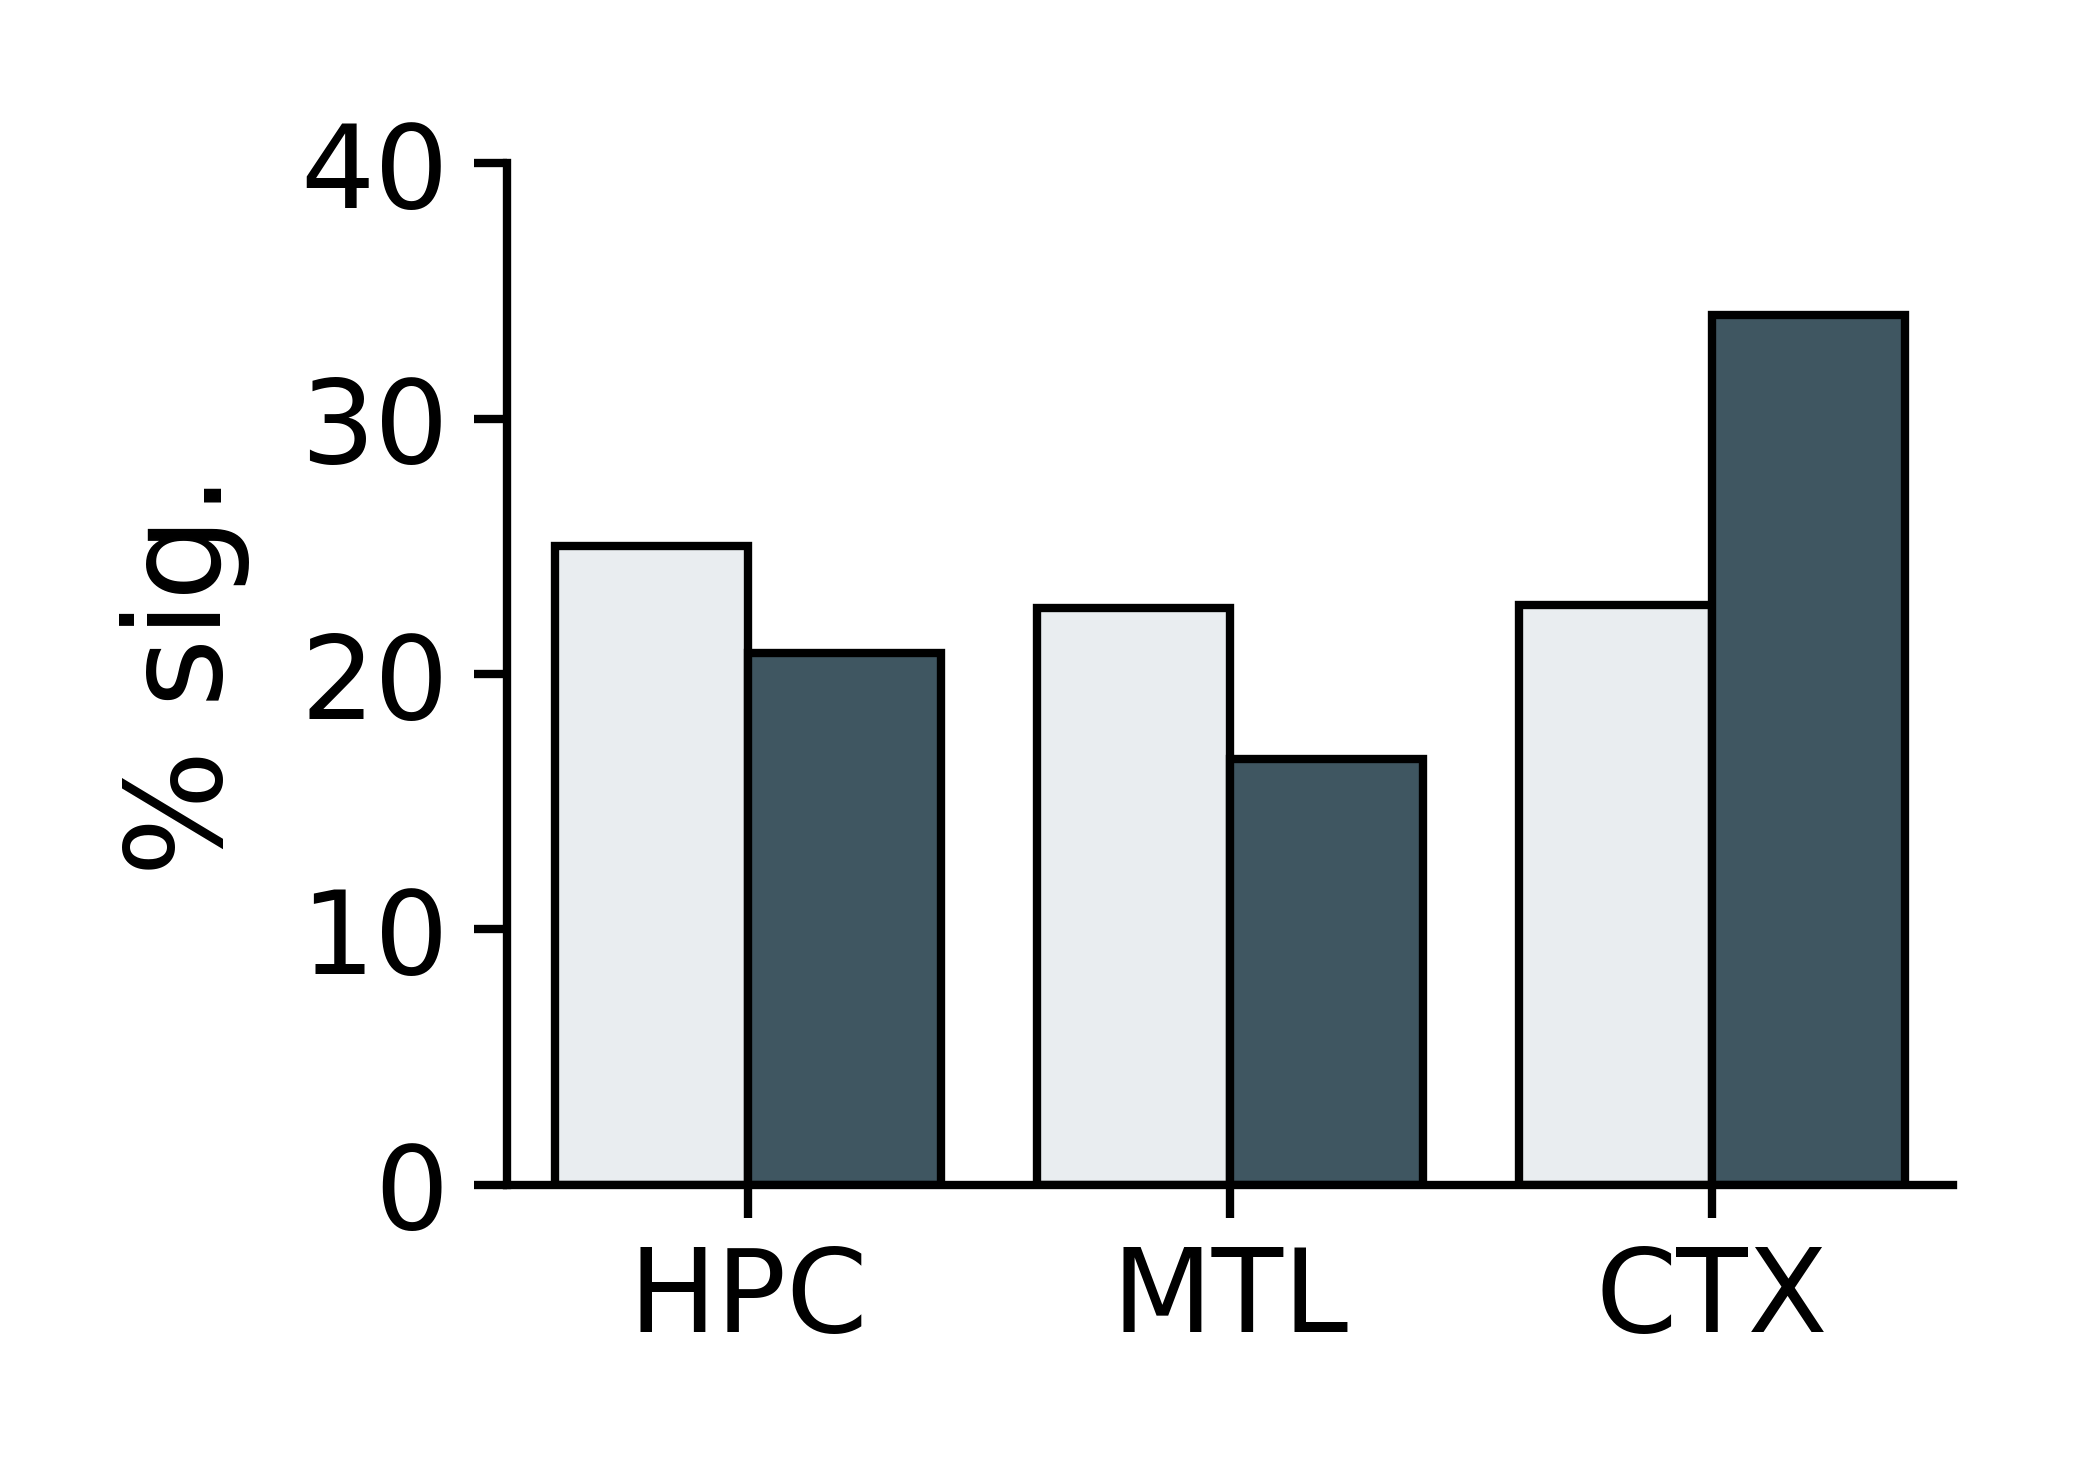

In [187]:
# Plot firing rate percentage by region.
keep_rois = ['HPC', 'MTL', 'CTX']
savefig = 0
overwrite = 0
figsize = (colws[1], colws[1]*0.725)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = 0.4
yticks = [0, 0.1, 0.2, 0.3, 0.4]
yticklabs = [0, 10, 20, 30, 40]
bar_lw = 0.5
spine_lw = 0.5
ticklen = 2
tickpad = 1.5
labelpad = 2
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
plot_err = False
capsize = 2.5
palette = [co['x1'], co['x4']]
xticklabs = keep_rois
sig_col = 'sig_fdr'

# ----------------------------
# Get the data.
dat = unit_fr_diffs.copy()
dat['sig_fdr_x_delaygtnav'] = np.invert(dat['nav_gt_delay']) * dat['sig_fdr']
dat['sig_fdr_x_navgtdelay'] = dat['nav_gt_delay'] * dat['sig_fdr']
dat1 = dat[['roi_gen2', 'sig_fdr_x_delaygtnav']].copy()
dat1.insert(1, 'level', 'delay_gt_nav')
dat1 = dat1.rename(columns={'sig_fdr_x_delaygtnav': 'sig_fdr'})
dat2 = dat[['roi_gen2', 'sig_fdr_x_navgtdelay']].copy()
dat2.insert(1, 'level', 'nav_gt_delay')
dat2 = dat2.rename(columns={'sig_fdr_x_navgtdelay': 'sig_fdr'})
dat = pd.concat((dat1, dat2), axis=0).reset_index(drop=True)
n_units = unit_fr_diffs['subj_sess_unit'].nunique()
print('{} neurons'.format(n_units))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]

_ax = sns.barplot(x='roi_gen2', y='sig_fdr', hue='level',
                  order=keep_rois, hue_order=['delay_gt_nav', 'nav_gt_delay'],
                  data=dat, ax=_ax, palette=palette,
                  saturation=1, alpha=bar_alpha,
                  ci=None, lw=bar_lw, ec='k')
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_rois)))
_ax.set_xticklabels(xticklabs, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs, fontsize=font['tick'])
_ax.set_ylabel('% sig.', fontsize=font['label'], labelpad=labelpad+1)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'goldmine', 
                       'goldmine-firing_rate-sig_pct_by_region-{}neurons.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

399 neurons


/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home1/dscho/anaconda3/envs/pypy310/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/goldmine/goldmine-firing_rates_by_region-means-399neurons.pdf


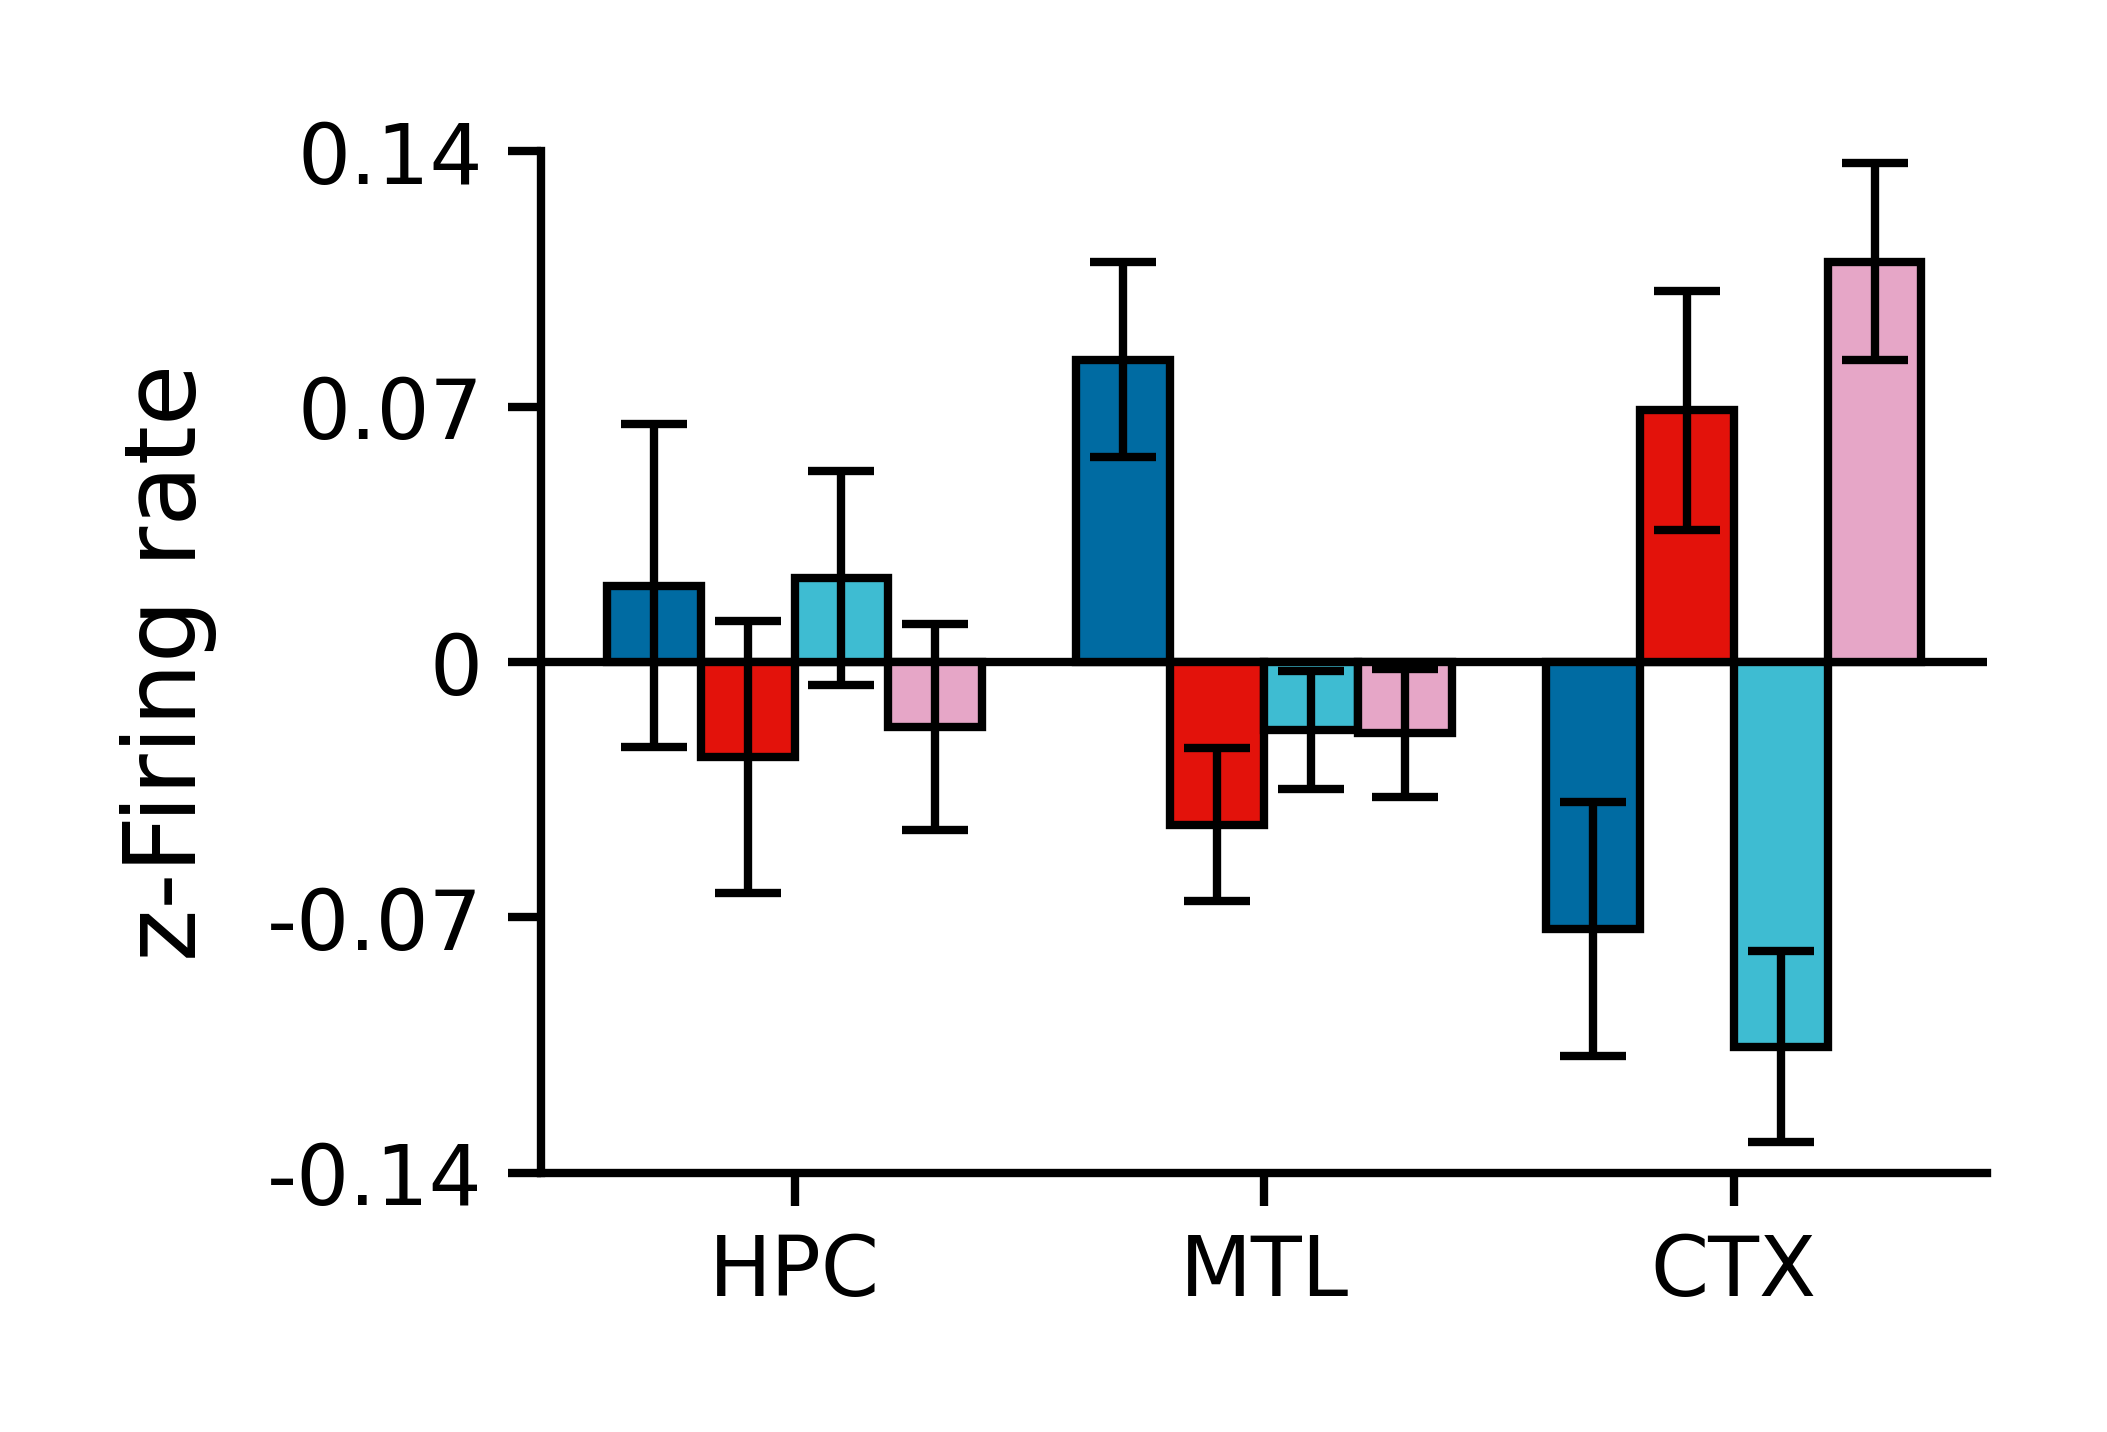

In [147]:
# Plot % of neurons with firing rate diffs between delay and nav.
keep_masks = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
keep_rois = ['HPC', 'MTL', 'CTX']

savefig = 0
overwrite = 1
figsize = (colws[1], colws[1]*0.725)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
ymin = -0.14
ymax = .14
yticks = [-0.14, -0.07, 0, 0.07, 0.14]
yticklabs = [-0.14, -0.07, 0, 0.07, 0.14]
bar_lw = 0.5
ebar_lw = 0.5
spine_lw = 0.5
ticklen = 2
tickpad = 1.5
labelpad = 2
bar_alpha = 1
plot_err = 1
capsize = 2
palette = [co['b'], co['r'], co['c'], co['p2']]
xticklabs = keep_rois

# ----------------------------
# Get the data.
qry = "(mask=={}) & (roi_gen2=={})".format(keep_masks, keep_rois)
dat = unit_frs.query(qry).reset_index(drop=True).copy()
n_units = dat['subj_sess_unit'].nunique()
print('{} neurons'.format(n_units))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]

_ax.axhline(0, lw=spine_lw, color='k', zorder=0)
_ax = sns.barplot(x='roi_gen2', y='z_fr', hue='mask',
                  order=keep_rois, hue_order=keep_masks,
                  data=dat, ax=_ax,
                  palette=palette, saturation=1, alpha=bar_alpha,
                  ci=None, lw=bar_lw, ec='k')
if plot_err:
    errs = unit_frs.groupby(['roi_gen2', 'mask'])['z_fr'].apply(_mean_sem_rng)
    for iBar, mask in enumerate(keep_masks):
        xoffsets = [keep_rois.index(roi) + ((iBar - 1.5) * (0.8 / 4)) for roi in keep_rois]
        _ax.errorbar(xoffsets,
                     [errs[roi, keep_masks[iBar]][0]
                      for roi in keep_rois],
                     yerr=np.array([np.abs(errs[(roi, keep_masks[iBar])][0] -
                                    np.array(errs[(roi, keep_masks[iBar])][1])).tolist()
                                    for roi in keep_rois]).T,
                     lw=0, ecolor='k', elinewidth=ebar_lw, capthick=ebar_lw, capsize=capsize)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_rois)))
_ax.set_xticklabels(xticklabs, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs, fontsize=font['tick'])
_ax.set_ylabel('z-Firing rate', fontsize=font['label'], labelpad=labelpad+1)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'goldmine', 
                       'goldmine-firing_rates_by_region-means-{}neurons.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

In [189]:
# Find the average change in:
# (1) phase-locking strength
# (2) firing rate
# between delay and navigation events, for each neuron.
_pl_mrls = pl_mrls.query("(expmt=='goldmine') & (mask=={})".format(keep_masks)).copy()
_pl_mrls = pd.merge(_pl_mrls,
                    unit_frs[['subj_sess_unit', 'mask', 'fr']],
                    how='inner',
                    on=['subj_sess_unit', 'mask']).rename(columns={'fr_y': 'fr'})
            
idx_cols = ['subj', 'subj_sess_unit', 'unit_hemroi', 'unit_roi_gen',
            'unit_roi_gen2', 'lfp_hemroi', 'lfp_roi_gen', 'lfp_roi_gen2',
            'edge', 'is_local']
_pl_mrls = pd.pivot(_pl_mrls,
                    index=idx_cols,
                    columns=['mask'],
                    values=['max_z_mrl', 'fr']).reset_index()
for stat in ['max_z_mrl', 'fr']:
    _pl_mrls[(stat, 'delay')] = _pl_mrls.loc[:, [(stat, 'Delay1'), (stat, 'Delay2')]].mean(axis=1)
    _pl_mrls[(stat, 'nav')] = _pl_mrls.loc[:, [(stat, 'Encoding'), (stat, 'Retrieval')]].mean(axis=1)
    _pl_mrls[(stat, 'nav-delay')] = _pl_mrls[(stat, 'nav')] - _pl_mrls[(stat, 'delay')]

_pl_mrls.columns = [('_'.join((x, y))) if np.all((len(x)>0, len(y)>0)) else x for (x, y) in _pl_mrls.columns]

print(_pl_mrls.shape)

(386, 24)


In [190]:
_pl_mrls = pd.merge(_pl_mrls,
                    unit_fr_diffs[['subj_sess_unit', 'tval']],
                    how='inner',
                    on=['subj_sess_unit']).rename(columns={'tval': 't_fr_nav-delay'})

for (unit_roi, lfp_roi), dat in _pl_mrls.groupby(['unit_roi_gen2', 'lfp_roi_gen2']):
    n = len(dat)
    rval, pval = stats.pearsonr(dat['max_z_mrl_nav-delay'], dat['t_fr_nav-delay'])
    print('{} to {}: n = {}, r = {:.2f}, p = {:.6f}'.format(unit_roi, lfp_roi, n, rval, pval))

HPC to HPC: n = 49, r = 0.05, p = 0.750191
MTL to HPC: n = 85, r = 0.05, p = 0.672042
MTL to MTL: n = 90, r = -0.12, p = 0.275297
CTX to HPC: n = 75, r = -0.11, p = 0.337898
CTX to CTX: n = 87, r = -0.23, p = 0.029379


HPC to HPC
49 neurons, r=0.05, p=0.75019, slope=0.04, icpt=1.74
max_z_mrl_nav-delay: min=-2.7, max=9.9
t_fr_nav-delay: min=-7.7, max=6.3

MTL to MTL
90 neurons, r=-0.12, p=0.27530, slope=-0.07, icpt=0.73
max_z_mrl_nav-delay: min=-1.5, max=13.7
t_fr_nav-delay: min=-10.7, max=9.3

CTX to CTX
87 neurons, r=-0.23, p=0.02938, slope=-0.13, icpt=0.86
max_z_mrl_nav-delay: min=-10.7, max=15.8
t_fr_nav-delay: min=-8.3, max=23.5

MTL to HPC
85 neurons, r=0.05, p=0.67204, slope=0.04, icpt=1.20
max_z_mrl_nav-delay: min=-1.4, max=13.1
t_fr_nav-delay: min=-9.7, max=9.3

CTX to HPC
75 neurons, r=-0.11, p=0.33790, slope=-0.02, icpt=0.10
max_z_mrl_nav-delay: min=-2.1, max=2.2
t_fr_nav-delay: min=-5.4, max=23.5



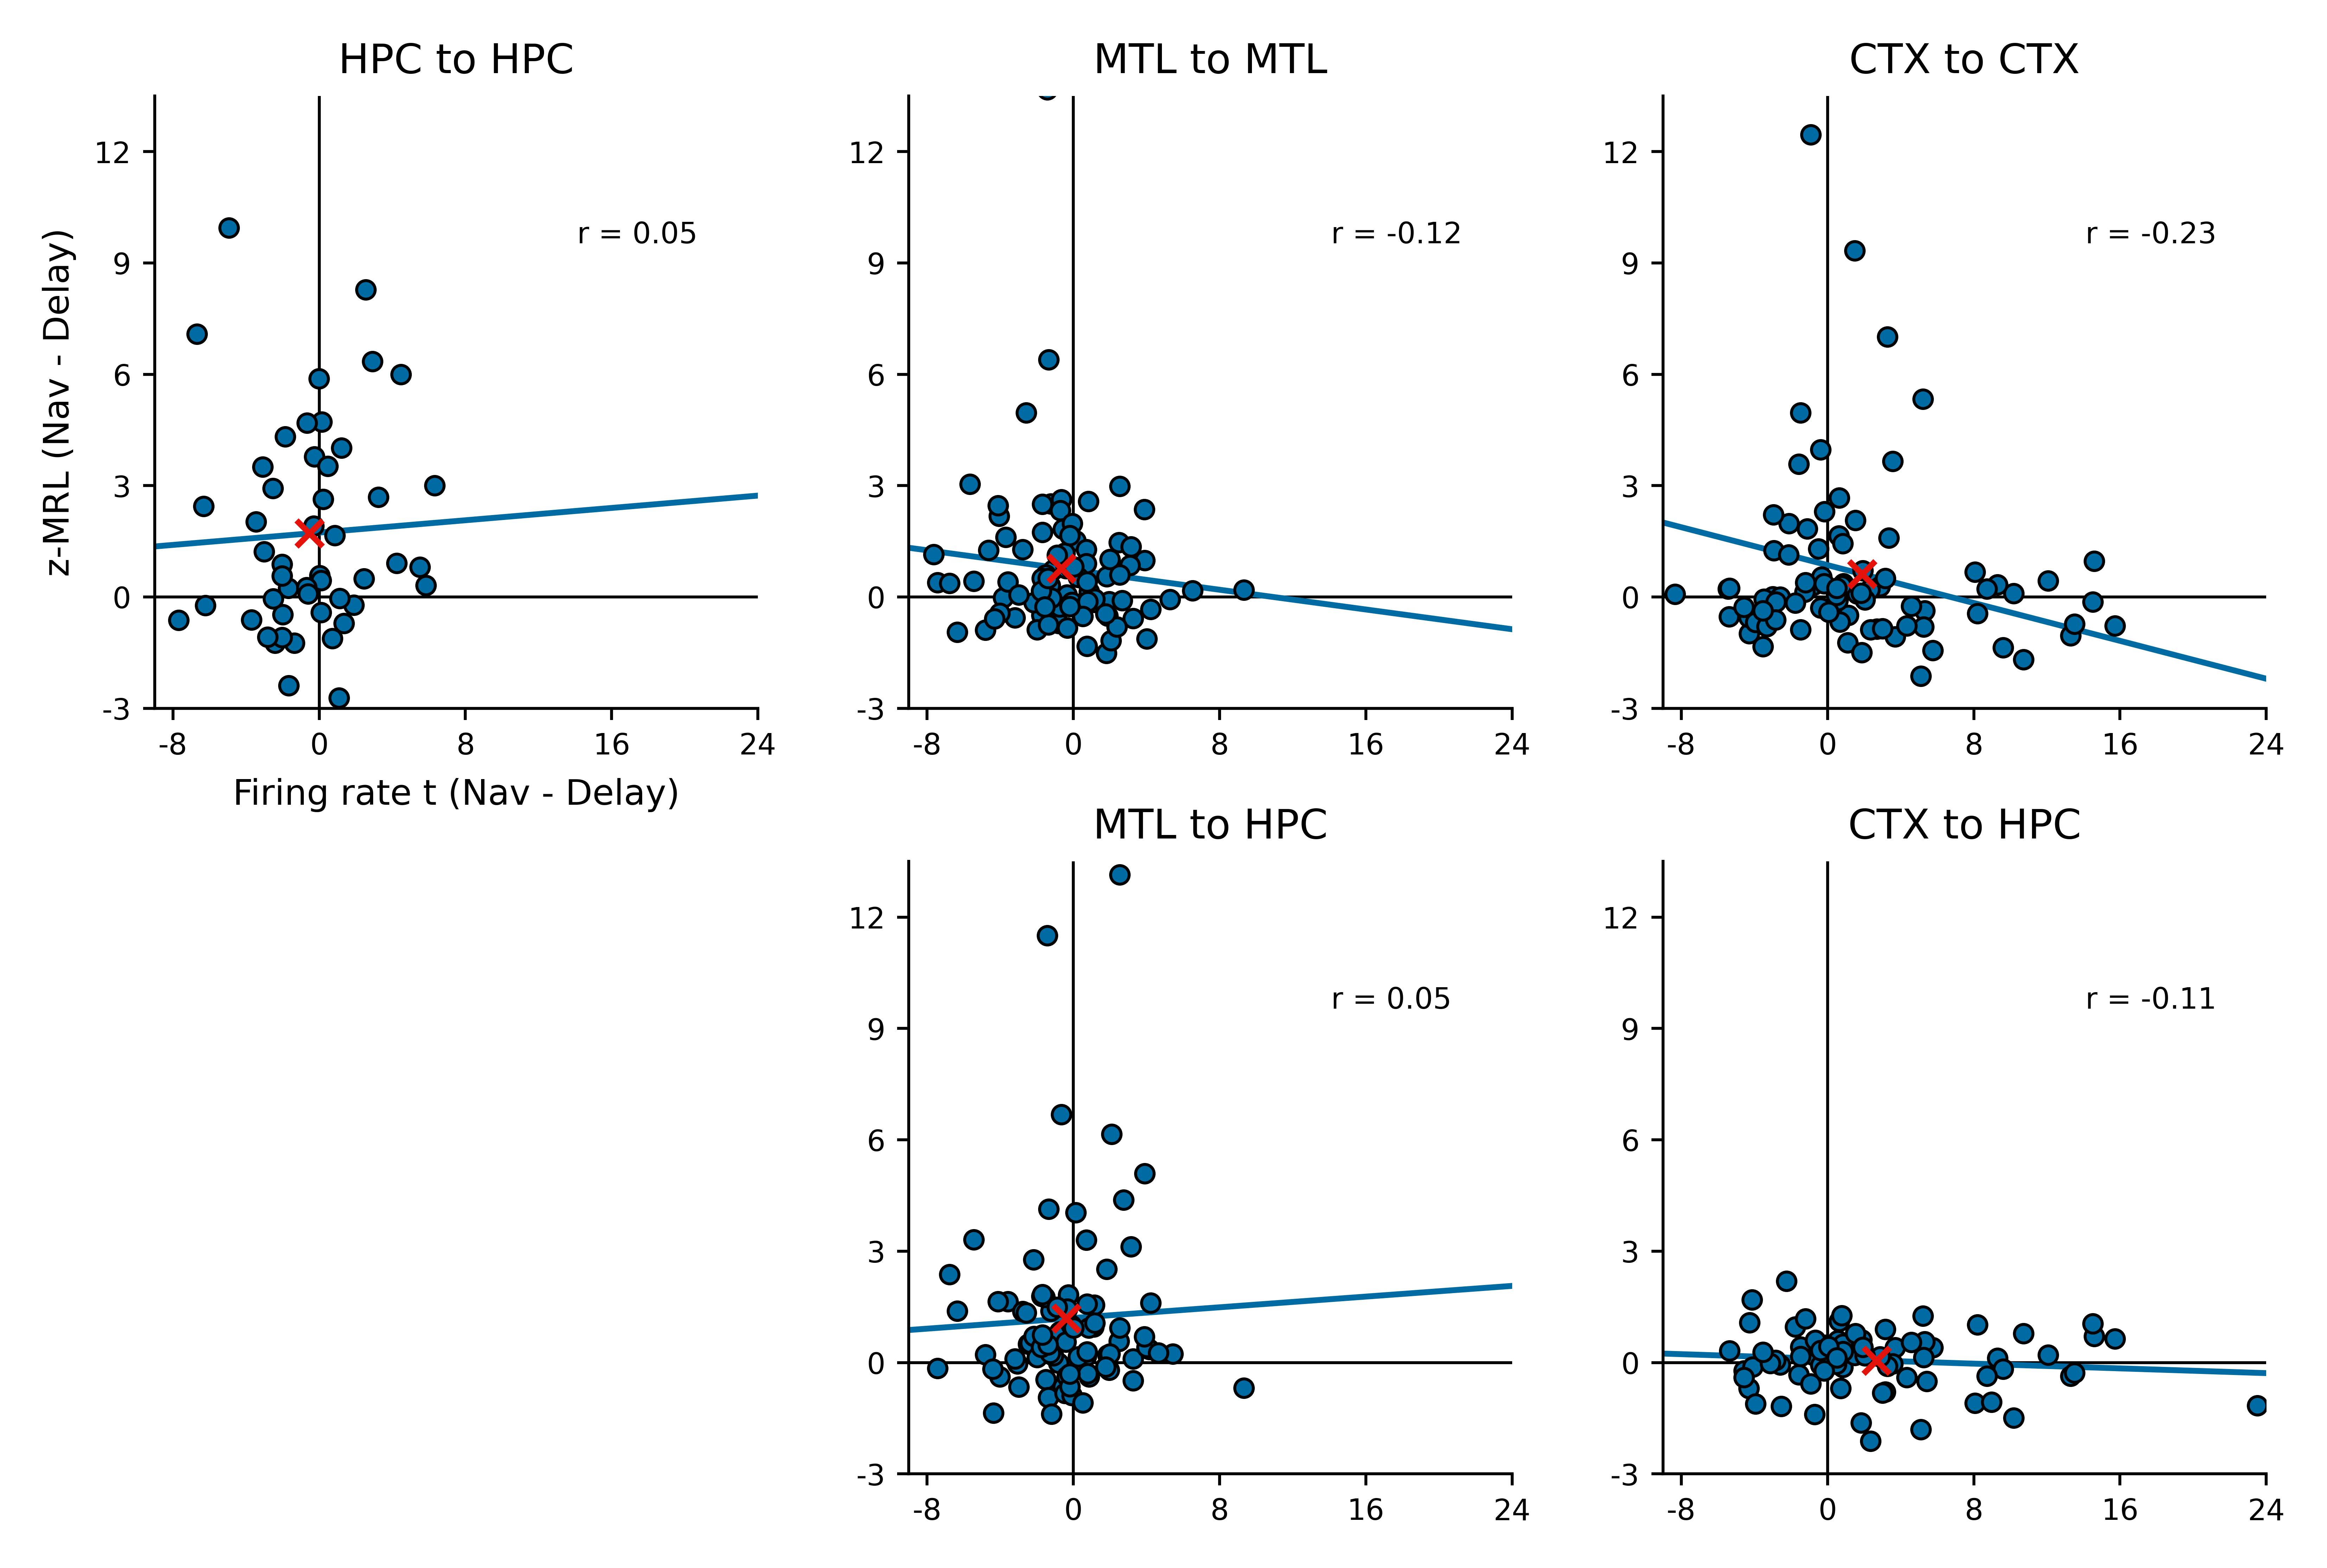

In [193]:
roi_pairs = [
    ('HPC', 'HPC'),
    ('MTL', 'MTL'),
    ('CTX', 'CTX'),
    ('', ''),
    ('MTL', 'HPC'),
    ('CTX', 'HPC'),
]
keep_masks = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
savefig = 0
overwrite = 1
figsize = (colws[3], colws[3]*0.67)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7, 'annot': 5}
spine_lw = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
# xlim = [-16, 16]
# xticks = [-16, -8, 0, 8, 16]
# xticklabs = xticks
# ylim = (-16, 16)
# yticks = [-16, -8, 0, 8, 16]
xlim = [-9, 24]
xticks = [-8, 0, 8, 16, 24]
xticklabs = xticks
yticks = [-3, 0, 3, 6, 9, 12]
yticklabs = yticks
ylim = [-3, 13.5]
yticklabs = yticks
point_size = 10
point_color = co['b']
point_alpha = 1
point_lw = 0.5
point_lcolor = 'k'

plot_ols = True
lw = 1

plot_centroid = True
centroid_size = 20
centroid_color = co['r']

plot_hline = True
hline = 0
hline_color = co['k']
plot_vline = True
vline = 0
vline_color = co['k']
verbose = True

# ------------------------------------
# Plot the data.
plt.close()
fig, ax = plt.subplots(2, 3, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for (iax, (unit_roi, lfp_roi)) in enumerate(roi_pairs):
    _ax = ax[iax]
    if iax == 3:
        _ax.axis('off')
        continue
    
    # Get the data
    dat = _pl_mrls.query("(unit_roi_gen2=='{}') & (lfp_roi_gen2=='{}')".format(unit_roi, lfp_roi))
    n = len(dat)
    a, b, rval, pval, *_ = stats.linregress(dat['t_fr_nav-delay'], dat['max_z_mrl_nav-delay'])
    
    # Plot the data
    if plot_hline:
        _ax.axhline(hline, color=hline_color, lw=spine_lw, zorder=0)
    if plot_vline:
        _ax.axvline(vline, color=vline_color, lw=spine_lw, zorder=0)
    
    if plot_ols:
        xvals = np.linspace(xlim[0], xlim[1], 100)
        yvals = (a * xvals) + b
        _ax.plot(xvals, yvals, color=co['b'], lw=lw, zorder=2)
        _ax.annotate('r = {:.2f}'.format(rval), (0.7, 0.75),
                     xycoords='axes fraction', fontsize=font['annot'],
                     ha='left', va='bottom', zorder=1)
    
    _ax = sns.scatterplot(x='t_fr_nav-delay', y='max_z_mrl_nav-delay', data=dat, ax=_ax,
                          s=point_size, color=point_color, alpha=point_alpha,
                          linewidth=point_lw, edgecolor=point_lcolor,
                          legend=False, zorder=2)
    
    if plot_centroid:
        centroid = (dat['t_fr_nav-delay'].mean(), dat['max_z_mrl_nav-delay'].mean())
        _ax.scatter(dat['t_fr_nav-delay'].mean(), dat['max_z_mrl_nav-delay'].mean(),
                    s=centroid_size, color=centroid_color, alpha=1, marker='x', zorder=3)
    
    if verbose:
        print('{} to {}'.format(unit_roi, lfp_roi))
        print('{} neurons, r={:.2f}, p={:.5f}, slope={:.2f}, icpt={:.2f}'
              .format(n, rval, pval, a, b))
        for col in ['max_z_mrl_nav-delay', 't_fr_nav-delay']:
            print('{}: min={:.1f}, max={:.1f}'
                  .format(col, np.min(dat[col]), np.max(dat[col])))
        print('')

    for spine in ['left', 'bottom']:
        _ax.spines[spine].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
    _ax.set_xlim(xlim)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(yticks, fontsize=font['tick'])
    if iax == 0:
        _ax.set_xlabel('Firing rate t (Nav - Delay)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('z-MRL (Nav - Delay)', fontsize=font['label'], labelpad=labelpad)
    else:
        _ax.set_xlabel('')
        _ax.set_ylabel('')
        
    _ax.set_title('{} to {}'.format(unit_roi, lfp_roi), fontsize=font['fig'], y=0.98)

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'goldmine', 
                       'delta-zMRL_vs_fr-tstat-by-freq_{}-neurons.pdf'
                       .format(_pl_mrls['subj_sess_unit'].nunique()))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

# Get spike_phases

In [124]:
def _get_gold_dug(subj_sess,
                  output_dir='/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events'):
    """Return gold view duration during Encoding and golds dug per trial."""
    gold_views = dio.open_pickle(op.join(output_dir, '{}-gold_views.pkl'.format(subj_sess)))
    
    # Get the no. of (viewed) golds dug on each trial, for each session.
    gold_dug = (gold_views
                .groupby(['subj_sess', 'trial', 'gold_id'])
                .agg({'dur': np.sum,
                      'dig_success': lambda x: np.any(x) * 1})
                .reset_index()
                .groupby(['trial'])
                .agg({'dur': np.sum,
                      'dig_success': np.sum}))
    
    return gold_dug


def _get_is_moving(subj_sess,
                   game_states=['Encoding', 'Retrieval']):
    """Return the proportion of time moving per (trial, gameState)."""
    events = events_proc.load_events(subj_sess, verbose=False)
    is_moving = pd.DataFrame([[trial,
                               game_state,
                               np.mean(np.concatenate(df.apply(lambda x: np.repeat(x['moved_pos'],
                                                                                   x['dur']),
                                                               axis=1).tolist()))]
                              for ((trial, game_state), df) in (
                                  events.positions
                                  .query("(gameState=={})".format(game_states))
                                  .groupby(['trial', 'gameState'])
                              )], columns=['trial', 'gameState', 'is_moving'])
    is_moving = is_moving.set_index(['trial', 'gameState'])['is_moving']
    
    return is_moving

In [125]:
# Load all gold view events.
output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events'
subj_sess = unit_lfp['subj_sess']

# Add trial-wise behavioral metrics.
gold_dug = _get_gold_dug(subj_sess)
is_moving = _get_is_moving(subj_sess)
event_time_spikes['is_moving'] = event_time_spikes.apply(lambda x: is_moving[(x['trial'], x['gameState'])], axis=1)
event_time_spikes['gold_view_dur'] = event_time_spikes['trial'].apply(lambda x: gold_dug['dur'].get(x, 0))
event_time_spikes['gold_dug'] = event_time_spikes['trial'].apply(lambda x: gold_dug['dig_success'].get(x, 0))

In [68]:
def _unit_to_lfp_phase_locking(unit,
                               expmt='goldmine',
                               game_states=['Encoding', 'Retrieval'],
                               freqs=np.arange(1, 31),
                               n_rois=8,
                               mask_phase=True,
                               n_perm=1000,
                               alpha=0.05,
                               circshift=False,
                               data_dir='/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav',
                               output_dir=None,
                               save_output=True,
                               overwrite=False,
                               verbose=True):
    """Calculate unit's phase-locking across events, at each frequency.
    
    Parameters
    ----------
    unit : dict or series
        Contains the spike times vector and identifying info for a unit.
    expmt : str, 'goldmine' | 'ycab'
        Indicates which dataset we're working with.
    game_states : array
        Event intervals to include in the analysis.
    freqs : array
        Frequencies at which spike-phase relations are analyzed.
    n_rois : int
        Number of meta-regions to assign for categorization.
    mask_phase : bool
        If True, only spikes that occur during P-episode-defined
        oscillatory states are included in the analyses. This masking is
        done both for the real spike times and for circularly-shifted
        null spike times.
    n_perm : int
        Number of permutations drawn to construst the null distribution.
        For each permutation, spike times are circ-shifted at random
        within each event, and phase-locking values at each frequency
        are recalculcated across events.
    alpha : float
        Defines the significance threshold for the phase-locking
        empirical p-value.
    data_dir : str
        Filepath to the location where saved inputs are stored.
    output_dir : str | None
        Filepath to the location where the output file is saved.
    save_output : bool
        Output is saved only if True.
    overwrite : bool
        If False and saved output already exists, it is simply returned
        at the top of this function. Otherwise phase-locking is
        calculated and, if save_output is True, any existing output file
        is overwritten.
    verbose : bool
        If True, some info is printed to the standard output.
        
    Returns
    -------
    pl_mrls : dataframe
        Each row corresponds to one unit -> LFPs from one microwire
        bundle.
    """
    
    timer = Timer()
    
    # Load events info.
    event_times = unit_lfp_comparison.load_event_times(
        unit['subj_sess'],
        expmt=expmt,
        game_states=game_states,
        data_dir=data_dir
    )
    
    # Add trial-wise behavioral metrics.
    gold_dug = _get_gold_dug(unit['subj_sess'])
    is_moving = _get_is_moving(unit['subj_sess'])
    event_time_spikes['is_moving'] = event_time_spikes.apply(lambda x: is_moving[(x['trial'], x['gameState'])], axis=1)
    event_time_spikes['gold_view_dur'] = event_time_spikes['trial'].apply(lambda x: gold_dug['dur'].get(x, 0))
    event_time_spikes['gold_dug'] = event_time_spikes['trial'].apply(lambda x: gold_dug['dig_success'].get(x, 0))
    
    # Process the local LFP and all hippocampal ROIs.
    if expmt == 'goldmine':
        mont = spike_preproc.get_montage(unit['subj_sess'])
    elif expmt == 'ycab':
        subj_df = get_subj_df()
        subj_df['subj_sess'] = subj_df['subj_sess'].apply(
            lambda x: str_replace(x, {'env': 'ses', '1a': '1'}))
        mont = (subj_df.query("(subj_sess=='{}')".format(unit['subj_sess']))
                       .groupby(['location'])['chan']
                       .apply(lambda x: np.array([int(chan) for chan in x])))
    roi_map = spike_preproc.roi_mapping(n=n_rois)
    unit_hemroi = unit['hemroi']
    hpc_rois = ['AH', 'MH', 'PH']
    lfp_hemrois = np.unique([unit['hemroi']] + [hemroi for hemroi in mont.keys()
                                                if hemroi[1:] in hpc_rois])
    pl_mrls = []
    for lfp_hemroi in lfp_hemrois:
        # ------------------------------------
        # Data loading

        # Determine which regions we're looking at.
        same_hem = (unit_hemroi[0] == lfp_hemroi[0])
        edge = unit_lfp_comparison._get_edge(unit_hemroi, lfp_hemroi)
        unit_roi_gen = roi_map[unit_hemroi[1:]]
        lfp_roi_gen = roi_map[lfp_hemroi[1:]]
        same_roi_gen = (unit_roi_gen == lfp_roi_gen)
        
        # Load event_times.
        event_times = unit_lfp_comparison.load_event_times(
            unit['subj_sess'],
            expmt=expmt,
            game_states=game_states,
            data_dir=data_dir
        )

        # Calculate spike times relative to the start of each event.
        event_time_spikes = unit_lfp_comparison.load_event_time_spikes(
            event_times,
            unit['spike_times']
        )

        # Load phase values for each event.
        basename_lfp = '{}-{}.pkl'.format(unit['subj_sess'], lfp_hemroi)
        phase = dio.open_pickle(op.join(data_dir, 'spectral', 'phase', basename_lfp))
        if (phase.buffer > 0) & (not phase.clip_buffer):
            phase = phase.loc[:, :, :, phase.buffer:phase.time.size-phase.buffer-1]
            phase.attrs['clip_buffer'] = True
        lfp_chans = [chan for chan in phase.chan.values if chan not in [unit['chan']]]
        if unit['chan'] in phase.chan:
            phase = phase.loc[{'chan': lfp_chans}]
        if not np.array_equal(phase.freq.values, freqs):
            phase = phase.loc[{'freq': [freq for freq in phase.freq.values if freq in freqs]}]
        if np.nanmax(phase.values) > np.pi:
            phase -= np.pi # convert values back to -π to π, with -π being the trough.

        # Load the P-episode mask for each event.
        osc_mask = dio.open_pickle(op.join(data_dir, 'p_episode', basename_lfp))
        if (osc_mask.buffer > 0) & (not osc_mask.clip_buffer):
            osc_mask = osc_mask.loc[:, :, :, osc_mask.buffer:osc_mask.time.size-osc_mask.buffer-1]
            osc_mask.attrs['clip_buffer'] = True
        if unit['chan'] in osc_mask.chan:
            osc_mask = osc_mask.loc[{'chan': [chan for chan in osc_mask.chan.values
                                              if chan not in [unit['chan']]]}]
        if not np.array_equal(osc_mask.freq.values, freqs):
            osc_mask = osc_mask.loc[{'freq': [freq for freq in osc_mask.freq.values
                                              if freq in freqs]}]

        # Ensure that phase, oscillation mask, and spike_times are all in the same event order.
        assert np.array_equal(phase.event.values, osc_mask.event.values)
        assert np.array_equal(phase.event.values,
                              np.array(event_time_spikes.apply(lambda x: (x['gameState'],
                                                                          x['trial']),
                                                               axis=1).values))

        # Calculate P-episode at each frequency, across channels and events.
        peps = 100 * osc_mask.mean(dim=('event', 'chan', 'time')).values
        max_pep = peps.max()
        max_pep_freq = freqs[peps.argmax()]

        # ------------------------------------
        # Calculate phase-locking

        # Get a masked array of spike phases, across events, during active
        # oscillations at each channel and frequency.
        event_dur = phase.time.size
        if mask_phase:
            spike_phases = np.ma.concatenate(event_time_spikes.apply(
                lambda x: unit_lfp_comparison.get_spike_phases(
                    x['spike_times'],
                    phase.values[x['event_idx'], :, :, :],
                    mask=np.invert(osc_mask.values[x['event_idx'], :, :, :]),
                    event_dur=event_dur,
                    circshift=circshift
                ), axis=1).tolist(), axis=-1) # chan x freq x spike
        else:
            spike_phases = np.ma.concatenate(event_time_spikes.apply(
                lambda x: unit_lfp_comparison.get_spike_phases(
                    x['spike_times'],
                    phase.values[x['event_idx'], :, :, :],
                    mask=None,
                    event_dur=event_dur,
                    circshift=circshift
                ), axis=1).tolist(), axis=-1) # chan x freq x spike

        # Calculate mean resultant lengths for each channel and frequency.
        mrls = np.array([[circstats.circmoment(spike_phases[iChan, iFreq, :].compressed())[1]
                          for iFreq in range(spike_phases.shape[1])]
                         for iChan in range(spike_phases.shape[0])]).astype(np.float32) # (chan, freq,)

        # Log how many spikes were counted per frequency,
        # taking the mean across channels.
        n_spikes_mask = np.array([[spike_phases[iChan, iFreq, :].flatten().compressed().size
                                   for iFreq in range(spike_phases.shape[1])]
                                  for iChan in range(spike_phases.shape[0])]).astype(np.float32) # (chan, freq,)
        
        output = pd.Series(od([
                     ('event_time_spikes', event_time_spikes),
                     ('phase', phase),
                     ('osc_mask', osc_mask),
                     ('peps', peps),
                     ('spike_phases', spike_phases),
                     ('mrls', mrls),
                     ('n_spikes_mask', n_spikes_mask)
                    ]))
        
        print(timer)
        
        return output
    
    
def mask_spike_times(spike_times,
                     mask,
                     circshift=False,
                     event_dur=30000):
    """Return spike times that don't overlap with the mask.
    
    Parameters
    ----------
    spike_times : array, shape=(spike,)
        Spike times relative to event onset.
    mask : array, shape=(time,)
        Mask of timepoints to exclude from the analysis.
    circshift : bool
        If True, circ-shifts spike times by a random number
        between 0 and the event duration - 1.
    event_dur : int
        The event duration, in ms.
        
    Returns
    -------
    spike_phases : MaskedArray, shape=(chan, freq, time)
        The phase at each spike time, for each channel and
        frequency. 
    """
    if circshift:
        spike_train = np.zeros(event_dur, dtype=bool)
        spike_train[spike_times] = True
        roll_by = np.random.randint(0, len(spike_train))
        spike_train = np.roll(spike_train, roll_by)
        spike_times = np.where(spike_train)[0]
                 
    spike_times = np.sort(list(set(spike_times) -
                               set(spike_times[np.where(mask[spike_times])[0]])))
    
    return spike_times

In [126]:
event_times = unit_lfp_comparison.load_event_times(
        unit['subj_sess'],
        expmt=expmt,
        game_states=game_states,
        data_dir=data_dir
    )

In [128]:
event_time_spikes.head()

event_idx  trial gameState  start_time  stop_time  \
0          0      1  Encoding      792694     822694   
1          1      2  Encoding      879958     909958   
2          2      3  Encoding      962657     992657   
3          3      4  Encoding     1042722    1072722   
4          4      5  Encoding     1130403    1160403   

                                         spike_times  \
0  [3900, 3906, 4231, 4242, 4388, 4466, 4496, 458...   
1  [263, 493, 1491, 1841, 1858, 1882, 2666, 3223,...   
2  [422, 625, 678, 770, 873, 940, 1016, 1215, 138...   
3  [606, 2302, 2313, 2357, 4727, 4871, 7080, 7090...   
4  [3425, 3712, 4600, 4645, 4665, 4702, 4724, 475...   

                                    spike_times_null  \
0  [79, 109, 539, 596, 667, 679, 948, 1188, 1283,...   
1  [47, 65, 83, 98, 241, 776, 1209, 1447, 1787, 2...   
2  [148, 265, 398, 740, 907, 977, 1041, 1093, 116...   
3  [905, 919, 938, 951, 1040, 1062, 1113, 1150, 1...   
4  [3247, 4098, 4334, 6785, 7369, 7587, 7632, 797...   

                                      spike_times_ma  \
0  [6887, 7170, 7181, 7190, 7443, 7497, 8560, 887...   
1  [4777, 4920, 7440, 7572, 7632, 7645, 7657, 127...   
2  [3125, 3197, 8864, 11181, 11540, 13918, 13964,...   
3  [2302, 2313, 2357, 7342, 7379, 9154, 10837, 12...   
4  [19847, 20520, 20576, 28406, 28451, 28793, 28816]   

                                 spike_times_ma_null  gold_view_dur  gold_dug  \
0     [741, 747, 1072, 1083, 1229, 1307, 1337, 1425]              0         0   
1                                                 []              0         0   
2                                                 []           5283         1   
3                     [1704, 2791, 2833, 2905, 3450]           6065         0   
4  [19222, 19236, 19249, 19267, 19323, 19384, 194...           5899         1   

   is_moving  
0   0.800866  
1   0.486758  
2   0.428538  
3   0.498034  
4   0.425911

In [129]:
#event_times[['trial', 'gameState', 'start_time', 'stop_time']]

In [69]:
def get_steeg(spike_times,
              eeg,
              buffer=0,
              dur=2000):
    """Return spike-triggered EEG traces."""
    steeg = np.array([eeg[buffer + np.arange(x-dur, x+dur+1)]
                      for x in spike_times])
    return steeg


def polar_histogram(phases, bins=16):
    """Count the number of phases in each bin.
    
    Parameters
    ----------
    phases : np.ndarray
        Vector of phase values in radians.
    bins : int
        The number of evenly-spaced bins to
        divide phases into.
        
    Returns
    ------
    counts : np.ndarray
        The number of phases within each bin.
    bin_edges : np.ndarray
        Edge values for each bin.
    bin_centers : np.ndarray
        Center value for each bin.
    """    
    # Define the bins.
    min_phi = 0
    max_phi = 2 * np.pi
    bin_size = (max_phi - min_phi) / bins
    bin_centers = np.linspace(min_phi, max_phi, bins + 1)[:-1]
    bounds = (bin_centers + (bin_size / 2))

    # Format phases from 0-2π.
    if (np.nanmin(phases) < 0.1):
        phases = (np.array(phases)+np.pi) % (2*np.pi)
    elif (np.nanmax(phases) > (2*np.pi)):
        phases = np.array(phases) % (2*np.pi)
    
    # Count no. phases in each bin.
    counts = []
    bin_edges = []
    for i in range(bins):
        if bounds[i-1] > bounds[i]:
            counts.append(len(phases[(phases>=bounds[i-1]) | (phases<bounds[i])]))
        else:
            counts.append(len(phases[(phases>=bounds[i-1]) & (phases<bounds[i])]))
        bin_edges.append((bounds[i-1], bounds[i]))
    counts = np.array(counts)
    bin_edges = np.array(bin_edges)
    
    return counts, bin_edges, bin_centers

In [72]:
keep_expmts = ['goldmine_nav']
min_spikes = 50
cols = ['subj_sess_unit', 'edge', 'unit_hemroi', 'lfp_hemroi', 'n_spikes',
        'fr', 'max_pep', 'max_pep_freq', 'max_n_spikes_mask', 'max_mrl',
        'max_mrl_freq', 'max_z_mrl', 'max_z_mrl_freq']
# -----------------
(pl_mrls
 .query("(edge=='hpc-local') & (same_hem==True) & (max_n_spikes_mask>={}) & (sig==True) & (expmt=={})"
        .format(min_spikes, keep_expmts))
 .sort_values(['max_z_mrl'], ascending=[False])[cols]
 .reset_index(drop=True).iloc[:5])

subj_sess_unit       edge unit_hemroi lfp_hemroi  n_spikes        fr  \
0  U518_ses1-38-1  hpc-local         LMH        LMH     10427  4.827315   
1  U518_ses1-36-1  hpc-local         LMH        LMH     11026  5.104630   
2  U518_ses0-39-1  hpc-local         LMH        LMH      9484  4.390741   
3  U518_ses0-40-1  hpc-local         LMH        LMH     12438  5.758333   
4  U521_ses0-69-1  hpc-local         RMH        RMH      9753  4.515278   

     max_pep  max_pep_freq  max_n_spikes_mask   max_mrl  max_mrl_freq  \
0  20.749722             3        2290.000000  0.363671            14   
1  20.963962             3        2429.333252  0.335394            14   
2  22.162508             3        1961.000000  0.391815            17   
3  21.363835             3        3091.833252  0.289810            13   
4  11.052476            16         999.666687  0.420663            12   

   max_z_mrl  max_z_mrl_freq  
0  33.118236              17  
1  32.162934              16  
2  30.272295              17  
3  27.456103              16  
4  26.240616              16

In [80]:
pl_mrls.query("(subj_sess_unit=='{}') & (edge=='{}') & (same_hem==True)".format(subj_sess_unit, edge))

expmt  subj_sess_unit  subj  subj_sess  unit unit_hemroi  \
1647  goldmine_nav  U518_ses0-39-1  U518  U518_ses0  39-1         LMH   

     unit_roi_gen unit_roi_gen2  n_spikes        fr lfp_hemroi lfp_hpc_div  \
1647          HPC           HPC      9484  4.390741        LMH        post   

     lfp_roi_gen lfp_roi_gen2                 lfp_chans       edge  same_hem  \
1647         HPC          HPC  [34, 35, 36, 37, 38, 40]  hpc-local      True   

      same_roi_gen                                               peps  \
1647          True  [2.2674382716049384, 16.752175925925926, 22.16...   

        max_pep  max_pep_freq  \
1647  22.162508             3   

                                          n_spikes_mask  max_n_spikes_mask  \
1647  [190.0, 1492.5, 1961.0, 792.8333, 330.33334, 1...             1961.0   

                                     n_spikes_mask_null  \
1647  [[206.83333, 1462.0, 1943.1666, 698.0, 297.833...   

      max_n_spikes_mask_null  \
1647              1912.71521   

                                                   mrls   max_mrl  \
1647  [0.110661976, 0.18356055, 0.21563227, 0.162327...  0.391815   

      max_mrl_freq                                          mrls_null  \
1647            17  [[0.09929926693439484, 0.02956230938434601, 0....   

      max_mrl_null  max_mrl_freq_null  \
1647      0.165872                  9   

                                         mean_mrls_null  \
1647  [0.09024346502870322, 0.028175510993693025, 0....   

                                          std_mrls_null  \
1647  [0.027442605074668967, 0.010994652051040332, 0...   

                                            pref_phases  max_pref_phase  \
1647  [-3.0442998, -2.543366, -2.898652, 2.9408548, ...       -2.255617   

      max_z_pref_phase                                    z_n_spikes_mask  \
1647         -2.255617  [0.06828885, 0.7194321, 1.115566, 2.1679487, 3...   

                                                 z_mrls  max_z_mrl  \
1647  [0.7440441953360263, 14.132783693183296, 18.93...  30.272295   

      max_z_mrl_freq  max_z_mrl_null  max_z_mrl_freq_null      pval   sig  
1647              17        2.166867                    1  0.000999  True

In [ ]:
# Plot spike-triggered LFP.

# hpc-local
# ---------
subj_sess_unit = 'U518_ses0-39-1'
# subj_sess_unit = 'U518_ses1-38-1'
# subj_sess_unit = 'U530_ses0-9-1'
# subj_sess_unit = 'U530_ses0-15-1'
# subj_sess_unit = 'U527_ses0-11-1'
# subj_sess_unit = 'U539_ses0-27-1'

# ctx-hpc
# -------
# subj_sess_unit = 'U530_ses0-7-1'
# subj_sess_unit = 'U384_ses1-10-2'
# subj_sess_unit = 'U384_ses1-44-41'
# subj_sess_unit = 'U530_ses0-43-2'
# subj_sess_unit = 'U395_ses3-3-2'
# subj_sess_unit = 'U527_ses0-23-1'

edge = 'hpc-local'
# edge = 'ctx-hpc'

# -------------------------
unit_lfp = pl_mrls.query("(subj_sess_unit=='{}') & (edge=='{}') & (same_hem==True)".format(subj_sess_unit, edge)).iloc[0]
unit = spikes.query("(subj_sess_unit=='{}')".format(subj_sess_unit)).iloc[0]
expmt = unit['expmt']
if expmt == 'goldmine':
    game_states = ['Encoding', 'Retrieval']
    data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav'
else:
    game_states = ['YCab']
    data_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab'
    
x = _unit_to_lfp_phase_locking(unit, expmt=expmt, game_states=game_states, data_dir=data_dir, circshift=False)
event_time_spikes = x['event_time_spikes']
phase = x['phase']
osc_mask = x['osc_mask']
spike_phases = x['spike_phases']
mrls = x['mrls']
n_spikes_mask = x['n_spikes_mask']
del x

x = _unit_to_lfp_phase_locking(unit, expmt=expmt, game_states=game_states, data_dir=data_dir, circshift=True)
event_time_spikes_null = x['event_time_spikes']
spike_phases_null = x['spike_phases']
mrls_null = x['mrls']
del x

subj_sess = unit_lfp['subj_sess']
roi = unit_lfp['lfp_hemroi']
buffer = 2500
l_freq = 0.1
h_freq = 80
notch_freqs = [60]
chan_exclusion_thresh = 2
verbose = True

if expmt == 'goldmine':
    event_eeg = eeg_preproc.load_event_eeg(subj_sess,
                                           regions=[roi],
                                           game_states=game_states,
                                           buffer=buffer,
                                           l_freq=l_freq,
                                           h_freq=h_freq,
                                           notch_freqs=notch_freqs,
                                           chan_exclusion_thresh=chan_exclusion_thresh,
                                           verbose=verbose)
    event_eeg = event_eeg[roi].stack(event=('gameState', 'trial')).transpose('event', 'chan', 'time')
else:
    # -----------------------
    # Load EEG for each channel and event.
    mont = (subj_df.query("(subj_sess=='{}')".format(subj_sess))
                   .groupby(['location'])['chan']
                   .apply(lambda x: np.array([int(chan) for chan in x])))
    regions = [roi]
    sr = 1000
    session_cut = 60000 # cut this many samples from start and end of the session
    event_len = 30000
    buffer = 2500
    l_freq = 0.1
    h_freq = 80
    notch_freqs = [60]
    chan_exclusion_thresh = 2
    output_dir = op.join('/scratch/dscho/ycab/eeg',
                         subj_sess.split('_')[0],
                         subj_sess.split('_')[1],
                         'micro_lfps',
                         'V-to-muV_sr1000_bandpass0.1-80_notch60')
    verbose = True

    time_eeg = eeg_preproc.load_time_eeg(subj_sess,
                                         mont=mont,
                                         regions=regions,
                                         l_freq=l_freq,
                                         h_freq=h_freq,
                                         notch_freqs=notch_freqs,
                                         chan_exclusion_thresh=chan_exclusion_thresh,
                                         verbose=verbose,
                                         output_dir=output_dir)
    time_eeg = time_eeg[roi]
    chans = time_eeg.index.values
    # start_cut samples are cut from session start, on top of session_cut, to make for even epoching.
    split_every = int(event_len)
    start_cut = time_eeg.iloc[:, session_cut:time_eeg.shape[1]-session_cut].values.shape[1] % split_every
    n_splits = int(time_eeg.iloc[:, session_cut+start_cut:-session_cut].shape[1] / split_every)
    start_stop = aop.rolling_window(np.arange(session_cut+start_cut,
                                              time_eeg.shape[1]-session_cut+1,
                                              split_every), 2)
    event_idx = np.array([np.arange(start-buffer, stop+buffer)
                          for (start, stop) in start_stop.tolist()])
    event_eeg = np.swapaxes(time_eeg.values[:, event_idx], 0, 1)[None, :, :, :] # gameState x trial x chan x time
    event_eeg = {roi: xarray.DataArray(event_eeg,
                                       name=(subj_sess, roi),
                                       coords=[('gameState', ['YCab']),
                                               ('trial', np.arange(1, event_eeg.shape[1]+1)),
                                               ('chan', chans),
                                               ('time', np.arange(event_eeg.shape[-1]))],
                                       dims=['gameState', 'trial', 'chan', 'time'],
                                       attrs={'sr': sr,
                                              'buffer': buffer,
                                              'chan_exclusion_thresh': chan_exclusion_thresh,
                                              'session_cut': session_cut,
                                              'start_cut': start_cut})}
    event_eeg = event_eeg[roi].stack(event=('gameState', 'trial')).transpose('event', 'chan', 'time')
        
print('event_eeg:', event_eeg.shape)

Ran in 25.3s
Ran in 24.8s
U518_ses0
---------
Excluded LMH channel 33 (index 0)
Kept 7/8 (88%) channels across 1 regions
Ran in 5.0s

event_eeg: (72, 7, 35000)


In [76]:
iChan = 4
event_dur = osc_mask.time.size

# _osc_mask = np.any(osc_mask.isel(chan=iChan), axis=1).values  # (event, time)
_osc_mask = np.any(osc_mask.isel(chan=iChan).sel(freq=[unit_lfp['max_z_mrl_freq']]), axis=1).values  # (event, time)
_osc_mask_null = np.any(osc_mask.isel(chan=iChan).sel(freq=[unit_lfp['max_z_mrl_freq_null']]), axis=1).values  # (event, time)
# _osc_mask = np.any(osc_mask.isel(chan=iChan).sel(freq=[3]), axis=1).values  # (event, time)
event_time_spikes['spike_times_null'] = (event_time_spikes.apply(lambda x:
                                                                 mask_spike_times(x['spike_times'],
                                                                                  np.zeros(_osc_mask_null[x['event_idx'], :].size),
                                                                                  event_dur=event_dur,
                                                                                  circshift=True),
                                                                 axis=1).tolist())
event_time_spikes['spike_times_ma'] = (event_time_spikes.apply(lambda x:
                                                               mask_spike_times(x['spike_times'],
                                                                                np.invert(_osc_mask[x['event_idx'], :]),
                                                                                event_dur=event_dur,
                                                                                circshift=False),
                                                               axis=1).tolist())
event_time_spikes['spike_times_ma_null'] = (event_time_spikes.apply(lambda x:
                                                                    mask_spike_times(x['spike_times'],
                                                                                     np.invert(_osc_mask_null[x['event_idx'], :]),
                                                                                     event_dur=event_dur,
                                                                                     circshift=True),
                                                                    axis=1).tolist())

In [112]:
# Load all gold view events.
output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events'
subj_sess = unit_lfp['subj_sess']

gold_views = dio.open_pickle(op.join(output_dir, '{}-gold_views.pkl'.format(subj_sess)))

# Get the no. of (viewed) golds dug on each trial, for each session.
gold_dug = (gold_views
            .groupby(['subj_sess', 'trial', 'gold_id'])
            .agg({'dur': np.sum,
                  'dig_success': lambda x: np.any(x) * 1})
            .reset_index()
            .groupby(['trial'])
            .agg({'dur': np.sum,
                  'dig_success': np.sum}))

print('gold_views: {}, gold_dug: {}'.format(gold_views.shape, gold_dug.shape))

# --------------------------
# Get prop. time spent moving during each Encoding trial.
game_states = ['Encoding', 'Retrieval']
subj_sess = unit_lfp['subj_sess']

is_moving = []
events = events_proc.load_events(subj_sess, verbose=False)
is_moving = pd.DataFrame([[trial,
                           game_state,
                           np.mean(np.concatenate(df.apply(lambda x: np.repeat(x['moved_pos'],
                                                                               x['dur']),
                                                           axis=1).tolist()))]
                          for ((trial, game_state), df) in (
                              events.positions
                              .query("(gameState=={})".format(game_states))
                              .groupby(['trial', 'gameState'])
                          )], columns=['trial', 'gameState', 'is_moving'])
is_moving = is_moving.set_index(['trial', 'gameState'])['is_moving']

# --------------------------
event_time_spikes['is_moving'] = event_time_spikes.apply(lambda x: is_moving[(x['trial'], x['gameState'])], axis=1)
event_time_spikes['gold_view_dur'] = event_time_spikes['trial'].apply(lambda x: gold_dug['dur'].get(x, 0))
event_time_spikes['gold_dug'] = event_time_spikes['trial'].apply(lambda x: gold_dug['dig_success'].get(x, 0))

gold_views: (46, 10), gold_dug: (26, 2)
is_moving: (72,)


In [110]:
gold_dug.head()

dur  dig_success
subj_sess trial                   
U518_ses0 3      5283            1
          4      6065            0
          5      5899            1
          6      3269            0
          7      4349            1

In [84]:
is_moving

is_moving
subj_sess trial gameState           
U518_ses0 1     Encoding    0.800866
                Retrieval   0.404251
          2     Encoding    0.486758
                Retrieval   0.528518
          3     Encoding    0.428538
                Retrieval   0.452974
          4     Encoding    0.498034
                Retrieval   0.230418
          5     Encoding    0.425911
                Retrieval   0.617917
          6     Encoding    0.506363
                Retrieval   0.510945
          7     Encoding    0.719059
                Retrieval   0.605764
          8     Encoding    0.603625
                Retrieval   0.405074
          9     Encoding    0.683548
                Retrieval   0.560886
          10    Encoding    0.649887
                Retrieval   0.636882
          11    Encoding    0.605623
                Retrieval   0.677849
          12    Encoding    0.278003
                Retrieval   0.106584
          13    Encoding    0.517507
                Retrieval   0.684614
          14    Encoding    0.315709
                Retrieval   0.174840
          15    Encoding    0.519506
                Retrieval   0.376041
          16    Encoding    0.452459
                Retrieval   0.430408
          17    Encoding    0.412400
                Retrieval   0.597368
          18    Encoding    0.653551
                Retrieval   0.704274
          19    Encoding    0.365347
                Retrieval   0.355642
          20    Encoding    0.491388
                Retrieval   0.674951
          21    Encoding    0.533682
                Retrieval   0.452307
          22    Encoding    0.742429
                Retrieval   0.752397
          23    Encoding    0.505147
                Retrieval   0.745069
          24    Encoding    0.528069
                Retrieval   0.626033
          25    Encoding    0.476449
                Retrieval   0.359195
          26    Encoding    0.491955
                Retrieval   0.645656
          27    Encoding    0.528618
                Retrieval   0.664523
          28    Encoding    0.739023
                Retrieval   0.660603
          29    Encoding    0.672739
                Retrieval   0.669099
          30    Encoding    0.656905
                Retrieval   0.709211
          31    Encoding    0.505416
                Retrieval   0.492487
          32    Encoding    0.749650
                Retrieval   0.745261
          33    Encoding    0.266582
                Retrieval   0.418700
          34    Encoding    0.671164
                Retrieval   0.569596
          35    Encoding    0.567687
                Retrieval   0.543044
          36    Encoding    0.691941
                Retrieval   0.509778